# Prioritize notebook

# Loading Modules

In [6]:
from importlib import reload
import question_answering
question_answering = reload(question_answering)
from question_answering import aggregate_multihop_answer, get_cb_answer, get_singlehop_ob_answer, get_multihop_ob_answer
from question_answering import togetherai_caller

Loading cache from ./cache.jsonl
Loaded 5750 cached responses


In [7]:
def are_answers_equivalent_using_llm(gold, candidate):
    """
    Compare two answers to determine their semantic equivalence using an LLM.
    Returns True if answers are equivalent; False otherwise.

    Args:
        gold (str): The gold answer.
        candidate (str): The candidate answer.
    """
    # Few-shot prompt
    prompt = f"""
    I want you to compare two answers and determine if they are equivalent.
    You should respond with "Yes" if the two answers have the same meaning, even if they are written differently. 
    Respond with "No" if they do not have the same meaning.

    Here are some examples:

    Gold Answer: "two"
    Candidate Answer: "2"
    Are these answers equivalent? Yes

    Gold Answer: "Paris"
    Candidate Answer: "the capital city of France"
    Are these answers equivalent? Yes

    Gold Answer: "four hundred years"
    Candidate Answer: "400 years"
    Are these answers equivalent? Yes

    Gold Answer: "climate change"
    Candidate Answer: "global warming"
    Are these answers equivalent? Yes

    Gold Answer: "The Eiffel Tower"
    Candidate Answer: "a landmark in Paris"
    Are these answers equivalent? Yes

    Gold Answer: "3 meters"
    Candidate Answer: "300 centimeters"
    Are these answers equivalent? Yes

    Gold Answer: "apple"
    Candidate Answer: "orange"
    Are these answers equivalent? No

    Gold Answer: "2023"
    Candidate Answer: "2022"
    Are these answers equivalent? No

    Gold Answer: "Canada"
    Candidate Answer: "United States"
    Are these answers equivalent? No

    Now, here is the pair for you to evaluate:

    Gold Answer: "{gold}"
    Candidate Answer: "{candidate}"
    Are these answers equivalent?
    """

    # Make API call
    try:
        # print("Prompt:", prompt)
        # Use LLM API to get the reformulated question
        response, tag = togetherai_caller.req2provider(prompt=prompt, max_tokens=None, stop= None, use_cache=True)
        response = response[0]
        answer = response['message']['content'].strip().lower()
        
        if "yes" in answer:
            return True
        elif "no" in answer:
            return False
        else:
            raise ValueError(f"Unexpected LLM response: {answer}")

    except Exception as e:
        print(f"Error during LLM API call: {e}")
        return False


In [8]:
are_answers_equivalent_using_llm("Two", "2")

True

In [9]:
import re
import string
import copy

def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

# Some Analysis

In [10]:
import json

# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset-hotpotqa.json"))


# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            answer = node.get("answer", [None])[0]  # Extract the cb_answer

            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]
                print(f"Question: {question_text}, Gold: {gold_answer}, answer: {answer}")
                # Compare cb_answer_text with the gold answer
                if are_answers_equivalent_using_llm(gold_answer, answer):
                    correct_answers += 1


# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"correct answers match rate: {accuracy:.2f}%")

Question: What is the length of the river into which Pack Creek runs after it goes through the Spanish Valley?, Gold: 1450 mi, answer: 2,330 kilometers or 1,450 miles.
Question: North Midland Divisional Engineers took part in a battle during WWII that went on for how many weeks ?, Gold: six weeks, answer: 281.
Question: What trio was the songwriter of 'What Are We Doin' Lonesome' from?, Gold: trio with his younger brothers Steve and Rudy, answer: Larry Gatlin & the Gatlin Brothers.
Question: Baraki Barak District is situated in the western part of a province whose capital is what?, Gold: Puli Alam, answer: Pul-i-Alam.
Question: Atlas Shrugged was a film based on the books by a proponent of what philosophy?, Gold: Objectivism, answer: Objectivism.
Question: Which has more members, Dada or Alt-J?, Gold: Alt-J, answer: Alt-J.
Question: 'She's a Mystery to Me' is a song on an album released in 1989 by what label?, Gold: Virgin, answer: Virgin.
Question: Jalen Jones plays basketball for an 

# Closed book answers

In [11]:
import json

# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset-hotpotqa.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_cb_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []
# Initialize lists to store lengths
correct_lengths = []
incorrect_lengths = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            cb_answer = node.get("cb_answer", [None])  # Extract the cb_answer
            cb_answer_text = cb_answer[0]
            cb_logprob = cb_answer[1]  # Extract logprobs
            cb_logprobs = cb_answer[3]  # Extract logprobs, now i am taking the whole sequence

            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]

                # Compare cb_answer_text with the gold answer
                # if normalize_answer(cb_answer_text) == normalize_answer(gold_answer):
                if are_answers_equivalent_using_llm(gold_answer, cb_answer_text):
                    print(f"CB Answer: {cb_answer_text}, Gold Answer: {gold_answer} : Correct")
                    correct_cb_answers += 1
                    correct_logprobs.append(cb_logprob)  # Save logprobs for correct cases
                    correct_lengths.append(len(cb_logprobs))  # Save lengths for correct cases
                    # X.append([cb_logprob])  # Feature
                    X.append(cb_logprobs)  # Feature
                    y.append(1)  # Label (correct)

                else:
                    print(f"CB Answer: {cb_answer_text}, Gold Answer: {gold_answer} : Incorrect")
                    incorrect_logprobs.append(cb_logprob)  # Save logprobs for incorrect cases
                    incorrect_lengths.append(len(cb_logprobs))
                    # X.append([cb_logprob])  # Feature
                    X.append(cb_logprobs)  # Feature
                    y.append(0)  # Label (incorrect)

# Calculate the accuracy
accuracy = (correct_cb_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times cb_answer matches gold answer: {correct_cb_answers}")
print(f"Closed-book match rate: {accuracy:.2f}%")

CB Answer: 2,330 kilometers., Gold Answer: 1450 mi : Correct
CB Answer: 104., Gold Answer: six weeks : Incorrect
CB Answer: Rogers., Gold Answer: trio with his younger brothers Steve and Rudy : Incorrect
CB Answer: Pul-i-Alam., Gold Answer: Puli Alam : Correct
CB Answer: Objectivism., Gold Answer: Objectivism : Correct
CB Answer: Dada., Gold Answer: Alt-J : Incorrect
CB Answer: Virgin Records., Gold Answer: Virgin : Incorrect
CB Answer: American Airlines Center., Gold Answer: Smoothie King Center : Incorrect
CB Answer: Qualcomm Stadium., Gold Answer: Qualcomm : Incorrect
CB Answer: 1,807,000., Gold Answer: 1800000 sqft : Incorrect
CB Answer: no., Gold Answer: no : Correct
CB Answer: Bolshoi Theatre., Gold Answer: Bolshoi Theatre : Correct
CB Answer: NCAA Division I., Gold Answer: the 2016 World Indoor Championships : Incorrect
CB Answer: it allowed guests to insert themselves into various movie and TV clips., Gold Answer: the first to utilize Audio-Animatronics : Incorrect
CB Answer: i

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import numpy as np

# Pad/truncate sequences to the maximum log prob sequence length
max_length = max(len(seq) for seq in X)
X_cb_padded = pad_sequences(X, maxlen=max_length, padding="post", truncating="post", value=-100, dtype="float32")

In [13]:
import numpy as np

# Calculate statistics for correct cases
correct_mean = np.mean(correct_logprobs) if correct_logprobs else 0
correct_std = np.std(correct_logprobs) if correct_logprobs else 0

# Calculate statistics for incorrect cases
incorrect_mean = np.mean(incorrect_logprobs) if incorrect_logprobs else 0
incorrect_std = np.std(incorrect_logprobs) if incorrect_logprobs else 0

# Print the results
print("Correct Cases:")
print(f"  Number of cases: {len(correct_logprobs)}")
print(f"  Mean logprobs: {correct_mean:.4f}")
print(f"  Standard deviation of logprobs: {correct_std:.4f}")

print("\nIncorrect Cases:")
print(f"  Number of cases: {len(incorrect_logprobs)}")
print(f"  Mean logprobs: {incorrect_mean:.4f}")
print(f"  Standard deviation of logprobs: {incorrect_std:.4f}")

Correct Cases:
  Number of cases: 47
  Mean logprobs: -2.1832
  Standard deviation of logprobs: 14.4224

Incorrect Cases:
  Number of cases: 53
  Mean logprobs: -3.8875
  Standard deviation of logprobs: 19.0333


Correct Cases:
  Number of cases: 47
  Mean logprobs: -2.1832
  Standard deviation of logprobs: 14.4224

Incorrect Cases:
  Number of cases: 53
  Mean logprobs: -3.8875
  Standard deviation of logprobs: 19.0333


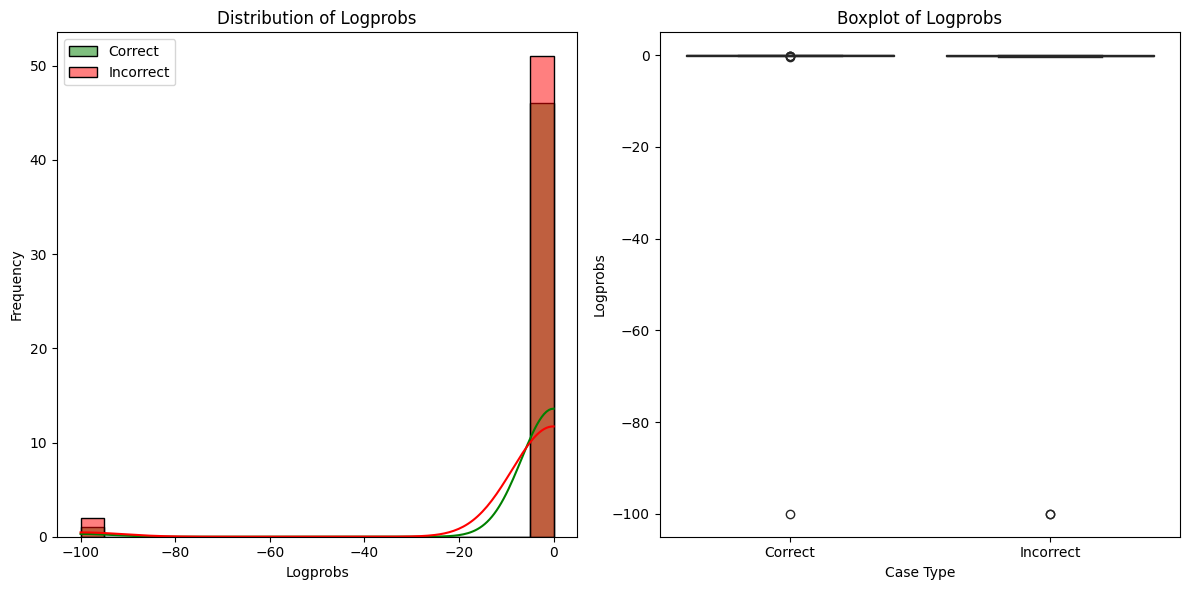

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate statistics for correct cases
correct_mean = np.mean(correct_logprobs) if correct_logprobs else 0
correct_std = np.std(correct_logprobs) if correct_logprobs else 0

# Calculate statistics for incorrect cases
incorrect_mean = np.mean(incorrect_logprobs) if incorrect_logprobs else 0
incorrect_std = np.std(incorrect_logprobs) if incorrect_logprobs else 0

# Print the results
print("Correct Cases:")
print(f"  Number of cases: {len(correct_logprobs)}")
print(f"  Mean logprobs: {correct_mean:.4f}")
print(f"  Standard deviation of logprobs: {correct_std:.4f}")

print("\nIncorrect Cases:")
print(f"  Number of cases: {len(incorrect_logprobs)}")
print(f"  Mean logprobs: {incorrect_mean:.4f}")
print(f"  Standard deviation of logprobs: {incorrect_std:.4f}")

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_logprobs, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_logprobs, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_logprobs, incorrect_logprobs], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()


In [15]:
# Compute mean and standard deviation
cb_logprob_correct_mean = np.mean(correct_logprobs)
cb_logprob_correct_std = np.std(correct_logprobs)
cb_logprob_incorrect_mean = np.mean(incorrect_logprobs)
cb_logprob_incorrect_std = np.std(incorrect_logprobs)

print("Correct - Mean:", cb_logprob_correct_mean, "Std:", cb_logprob_correct_std)
print("Incorrect - Mean:", cb_logprob_incorrect_mean, "Std:", cb_logprob_incorrect_std)

Correct - Mean: -2.1832469491774975 Std: 14.422393364822296
Incorrect - Mean: -3.8874924251091825 Std: 19.033299923238943


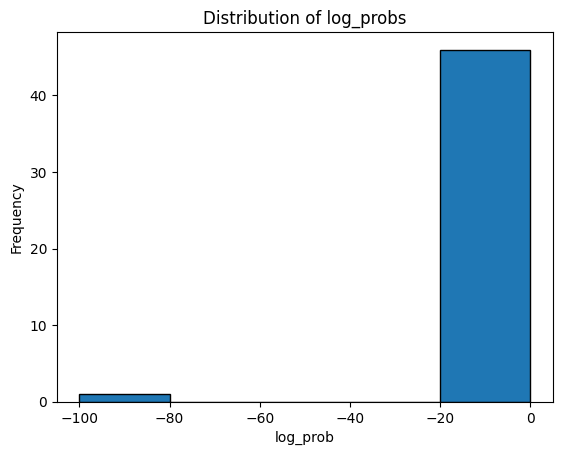

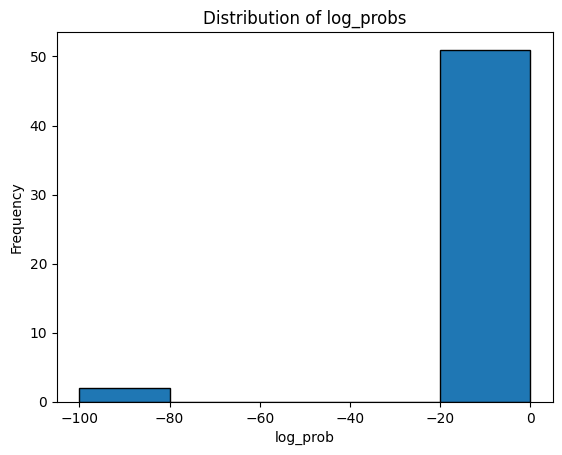

In [16]:
import matplotlib.pyplot as plt

# Plot histogram of log_probs
plt.hist(correct_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of log_probs
plt.hist(incorrect_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

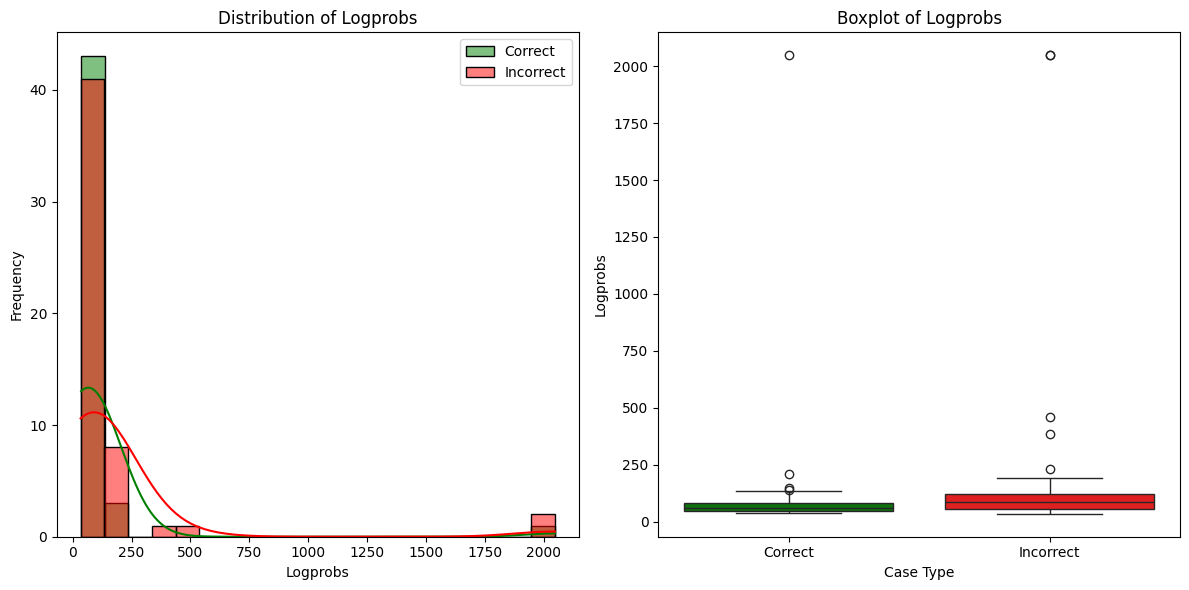

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_lengths, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_lengths, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_lengths, incorrect_lengths], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()


In [18]:
# Compute mean and standard deviation
cb_length_correct_mean = np.mean(correct_lengths)
cb_length_correct_std = np.std(correct_lengths)
cb_length_incorrect_mean = np.mean(incorrect_lengths)
cb_length_incorrect_std = np.std(incorrect_lengths)

print("Correct - Mean:", cb_length_correct_mean, "Std:", cb_length_correct_std)
print("Incorrect - Mean:", cb_length_incorrect_mean, "Std:", cb_length_incorrect_std)

Correct - Mean: 110.53191489361703 Std: 287.55364724737774
Incorrect - Mean: 176.1509433962264 Std: 378.3759434406232


Class Distribution: [53 47]
Model Evaluation (Adjusted Threshold): 0.0
  Accuracy: 0.5500
  Precision: 0.5500
  Recall: 1.0000
  F1-Score: 0.7097
  ROC AUC: 0.5253


/Users/ahmed.ehab/Desktop/Guided-Research/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


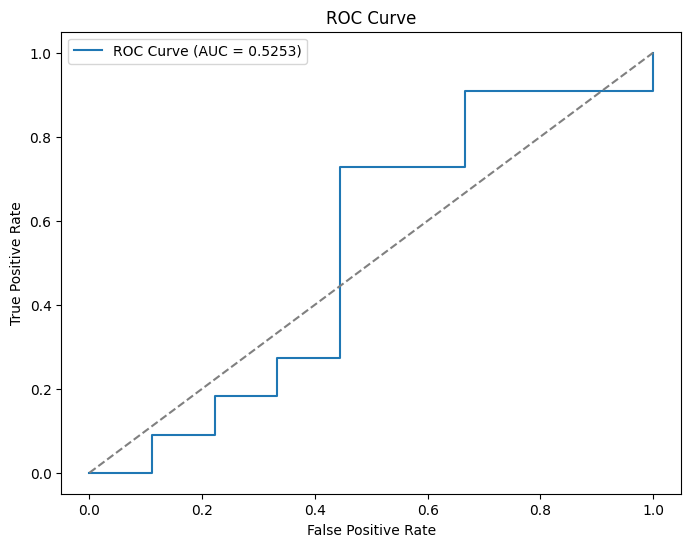

Model Evaluation (Adjusted Threshold): 0.1
  Accuracy: 0.6000
  Precision: 0.6364
  Recall: 0.6364
  F1-Score: 0.6364
  ROC AUC: 0.5253


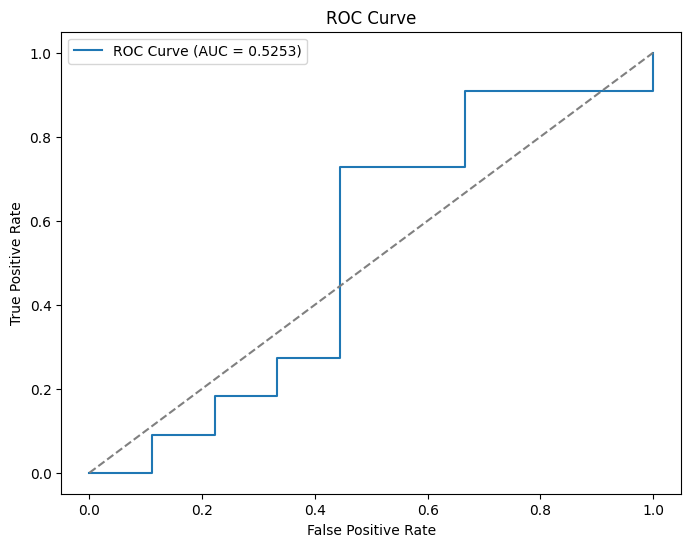

Model Evaluation (Adjusted Threshold): 0.2
  Accuracy: 0.6000
  Precision: 0.6364
  Recall: 0.6364
  F1-Score: 0.6364
  ROC AUC: 0.5253


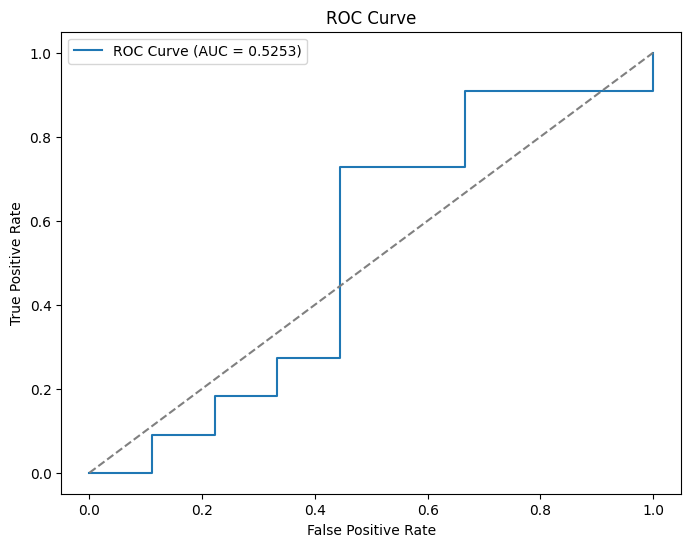

Model Evaluation (Adjusted Threshold): 0.3
  Accuracy: 0.6000
  Precision: 0.6364
  Recall: 0.6364
  F1-Score: 0.6364
  ROC AUC: 0.5253


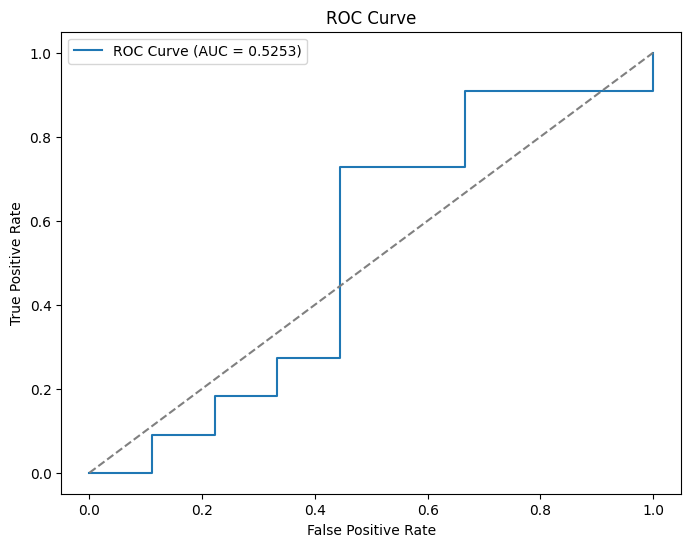

Model Evaluation (Adjusted Threshold): 0.4
  Accuracy: 0.6000
  Precision: 0.6364
  Recall: 0.6364
  F1-Score: 0.6364
  ROC AUC: 0.5253


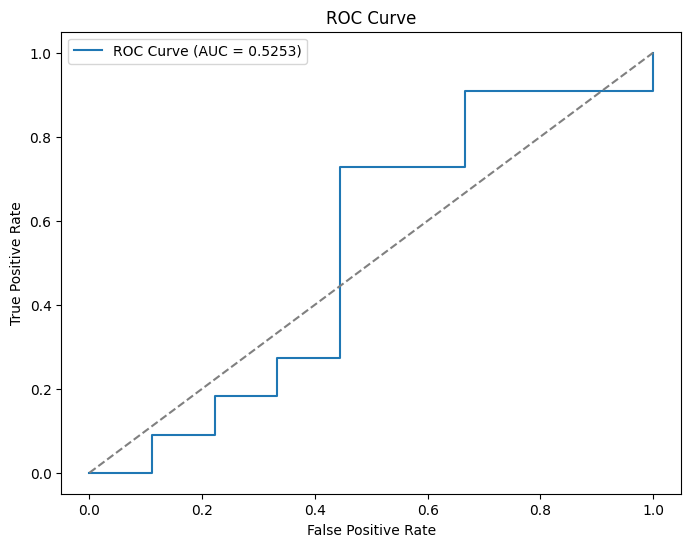

Model Evaluation (Adjusted Threshold): 0.5
  Accuracy: 0.6000
  Precision: 0.6364
  Recall: 0.6364
  F1-Score: 0.6364
  ROC AUC: 0.5253


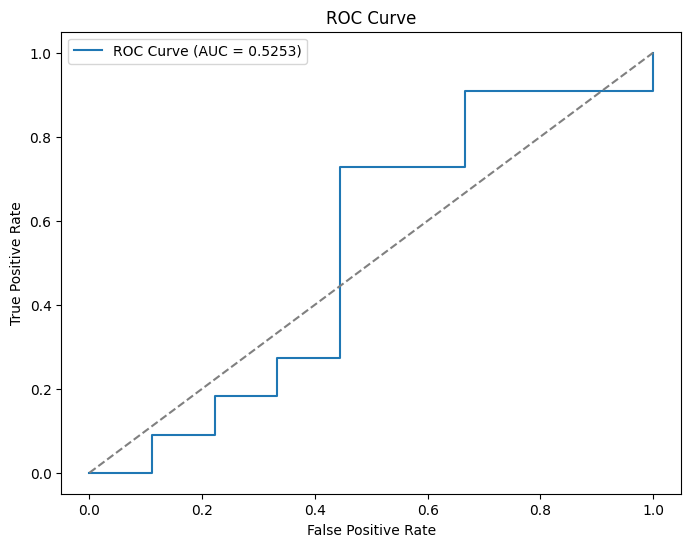

Model Evaluation (Adjusted Threshold): 0.6
  Accuracy: 0.4500
  Precision: 0.5000
  Recall: 0.2727
  F1-Score: 0.3529
  ROC AUC: 0.5253


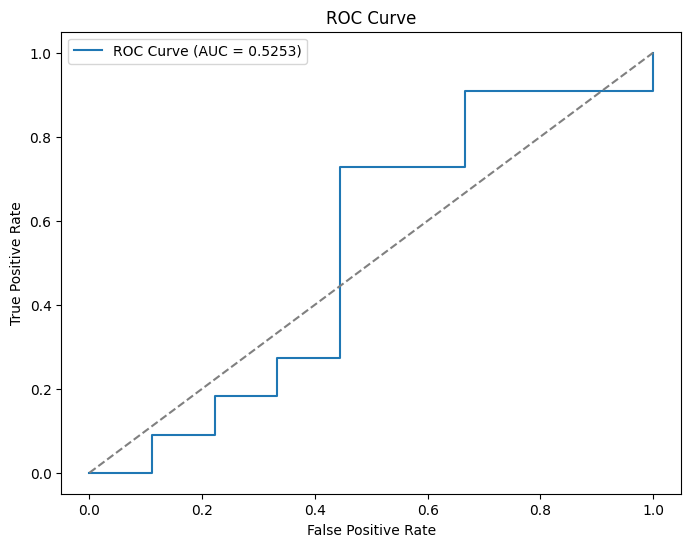

Model Evaluation (Adjusted Threshold): 0.7
  Accuracy: 0.4500
  Precision: 0.5000
  Recall: 0.2727
  F1-Score: 0.3529
  ROC AUC: 0.5253


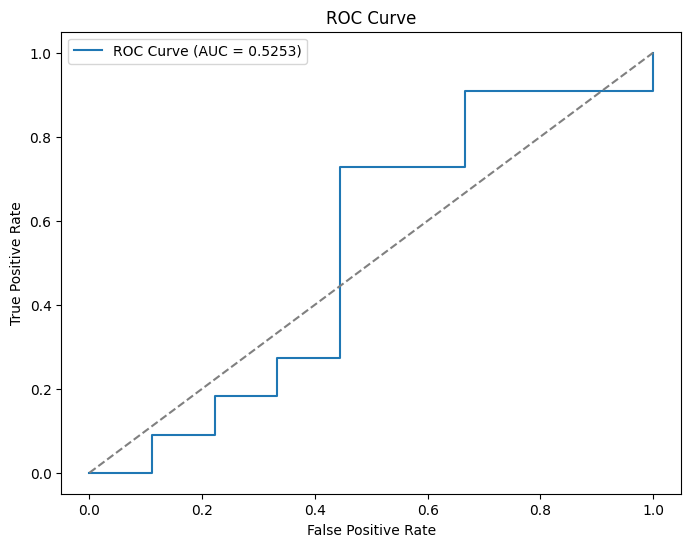

Model Evaluation (Adjusted Threshold): 0.8
  Accuracy: 0.4500
  Precision: 0.5000
  Recall: 0.2727
  F1-Score: 0.3529
  ROC AUC: 0.5253


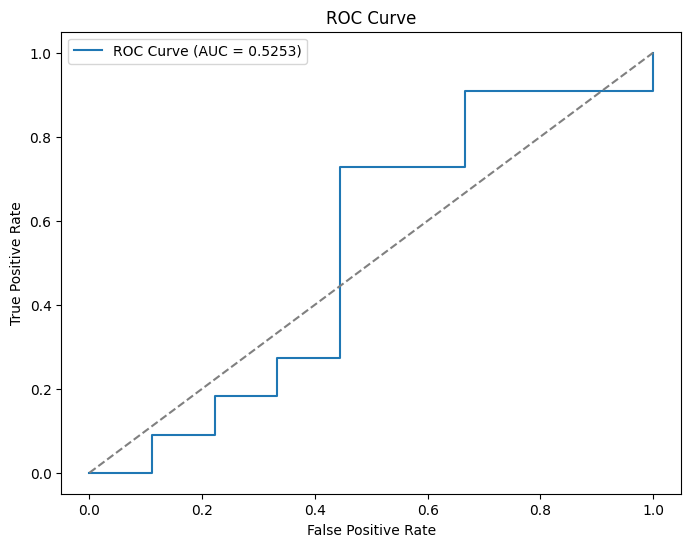

Model Evaluation (Adjusted Threshold): 0.9
  Accuracy: 0.4500
  Precision: 0.5000
  Recall: 0.2727
  F1-Score: 0.3529
  ROC AUC: 0.5253


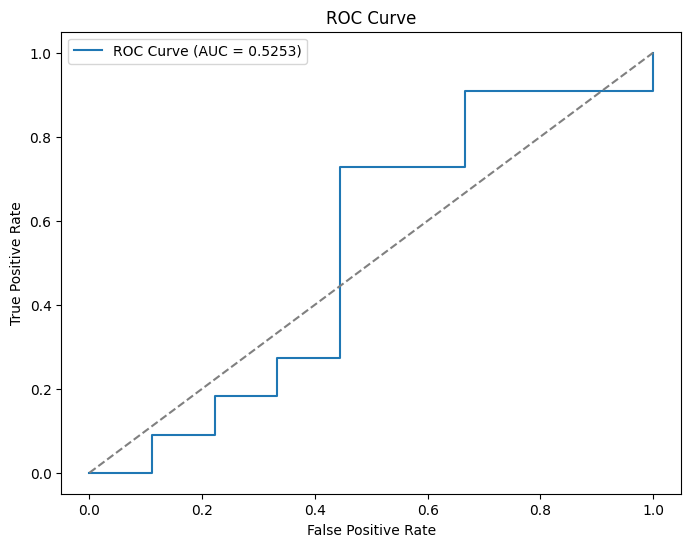

In [19]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt


# # Convert to numpy arrays
# X = np.array(X)
# y = np.array(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # Check class distribution
# print("Class Distribution:", np.bincount(y))

# # Train a Logistic Regression model with class weights
# model = LogisticRegression(class_weight="balanced")
# model.fit(X_train, y_train)

# # Make predictions
# y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# # Adjust threshold
# threshold = 0.3  # Experiment with different thresholds
# y_pred_adj = (y_pred_proba >= threshold).astype(int)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred_adj)
# precision = precision_score(y_test, y_pred_adj)
# recall = recall_score(y_test, y_pred_adj)
# f1 = f1_score(y_test, y_pred_adj)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# print("Model Evaluation (Adjusted Threshold):")
# print(f"  Accuracy: {accuracy:.4f}")
# print(f"  Precision: {precision:.4f}")
# print(f"  Recall: {recall:.4f}")
# print(f"  F1-Score: {f1:.4f}")
# print(f"  ROC AUC: {roc_auc:.4f}")

# # Plot the ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cb_padded, y, test_size=0.2, random_state=42)

# Check class distribution
print("Class Distribution:", np.bincount(y))

# Train a Logistic Regression model with class weights
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Adjust threshold
for i in range(0, 10):
    threshold = i/10  # Experiment with different thresholds
    # threshold = 0.2  # Experiment with different thresholds
    y_pred_adj = (y_pred_proba >= threshold).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_adj)
    precision = precision_score(y_test, y_pred_adj)
    recall = recall_score(y_test, y_pred_adj)
    f1 = f1_score(y_test, y_pred_adj)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Model Evaluation (Adjusted Threshold): {threshold}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# Child answer

In [20]:
import json

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_child_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []
# Initialize lists to store lengths
correct_lengths = []
incorrect_lengths = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            child_answer = node.get("child_answer", [None])  # Extract the child_answer
            child_answer_text = child_answer[0]
            child_logprob = child_answer[1]  # Extract logprobs
            child_logprobs = child_answer[3]  # Extract logprobs

            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]

                # Compare child_answer_text with the gold answer
                # if normalize_answer(child_answer_text) == normalize_answer(gold_answer):
                if are_answers_equivalent_using_llm(gold_answer, child_answer_text):
                    print(f"OB Answer: {child_answer_text}, Gold Answer: {gold_answer} : Correct")
                    correct_child_answers += 1
                    correct_logprobs.append(child_logprob)  # Save logprobs for correct cases
                    correct_lengths.append(len(child_logprobs))
                    # X.append([child_logprob])  # Feature
                    X.append(child_logprobs)  # Feature
                    y.append(1)  # Label (correct)
                else:
                    print(f"OB Answer: {child_answer_text}, Gold Answer: {gold_answer} : Incorrect")
                    if child_logprob > -10:
                        incorrect_logprobs.append(child_logprob)  # Save logprobs for incorrect cases
                        incorrect_lengths.append(len(child_logprobs))
                        # X.append([child_logprob])  # Feature
                        X.append(child_logprobs)  # Feature
                        y.append(0)  # Label (incorrect)

# Calculate the accuracy
accuracy = (correct_child_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times child_answer matches gold answer: {correct_child_answers}")
print(f"Open-book match rate: {accuracy:.2f}%")

OB Answer: 2,330 kilometers or 1,450 miles., Gold Answer: 1450 mi : Correct
OB Answer: 281., Gold Answer: six weeks : Incorrect
OB Answer: Larry Gatlin & the Gatlin Brothers., Gold Answer: trio with his younger brothers Steve and Rudy : Correct
OB Answer: Pul-i-Alam., Gold Answer: Puli Alam : Correct
OB Answer: Objectivism., Gold Answer: Objectivism : Correct
OB Answer: Alt-J., Gold Answer: Alt-J : Correct
OB Answer: Virgin., Gold Answer: Virgin : Correct
OB Answer: Smoothie King Center., Gold Answer: Smoothie King Center : Correct
OB Answer: Qualcomm Stadium., Gold Answer: Qualcomm : Incorrect
OB Answer: 1,800,000 sqft., Gold Answer: 1800000 sqft : Correct
OB Answer: No., Gold Answer: no : Correct
OB Answer: Bolshoi Theatre., Gold Answer: Bolshoi Theatre : Correct
OB Answer: 2016 World Indoor Championships., Gold Answer: the 2016 World Indoor Championships : Correct
OB Answer: it was the first Circle-Vision show with an actual plot and utilizing Audio-Animatronics., Gold Answer: the f

Correct Cases:
  Number of cases: 62
  Mean logprobs: -0.0306
  Standard deviation of logprobs: 0.0194

Incorrect Cases:
  Number of cases: 37
  Mean logprobs: -0.0457
  Standard deviation of logprobs: 0.0225


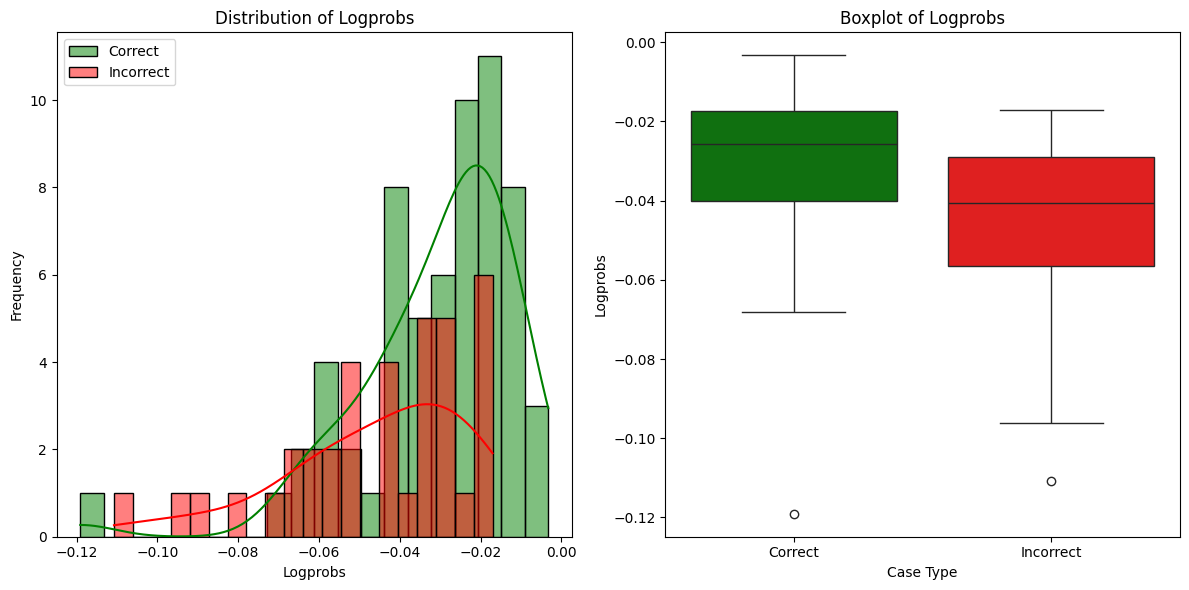

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate statistics for correct cases
correct_mean = np.mean(correct_logprobs) if correct_logprobs else 0
correct_std = np.std(correct_logprobs) if correct_logprobs else 0

# Calculate statistics for incorrect cases
incorrect_mean = np.mean(incorrect_logprobs) if incorrect_logprobs else 0
incorrect_std = np.std(incorrect_logprobs) if incorrect_logprobs else 0

# Print the results
print("Correct Cases:")
print(f"  Number of cases: {len(correct_logprobs)}")
print(f"  Mean logprobs: {correct_mean:.4f}")
print(f"  Standard deviation of logprobs: {correct_std:.4f}")

print("\nIncorrect Cases:")
print(f"  Number of cases: {len(incorrect_logprobs)}")
print(f"  Mean logprobs: {incorrect_mean:.4f}")
print(f"  Standard deviation of logprobs: {incorrect_std:.4f}")

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_logprobs, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_logprobs, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_logprobs, incorrect_logprobs], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()


In [22]:
# Compute mean and standard deviation
child_logprob_correct_mean = np.mean(correct_logprobs)
child_logprob_correct_std = np.std(correct_logprobs)
child_logprob_incorrect_mean = np.mean(incorrect_logprobs)
child_logprob_incorrect_std = np.std(incorrect_logprobs)

print("Correct - Mean:", child_logprob_correct_mean, "Std:", child_logprob_correct_std)
print("Incorrect - Mean:", child_logprob_incorrect_mean, "Std:", child_logprob_incorrect_std)

Correct - Mean: -0.030608867915514443 Std: 0.019404167304885145
Incorrect - Mean: -0.04569014039153852 Std: 0.02252077850748555


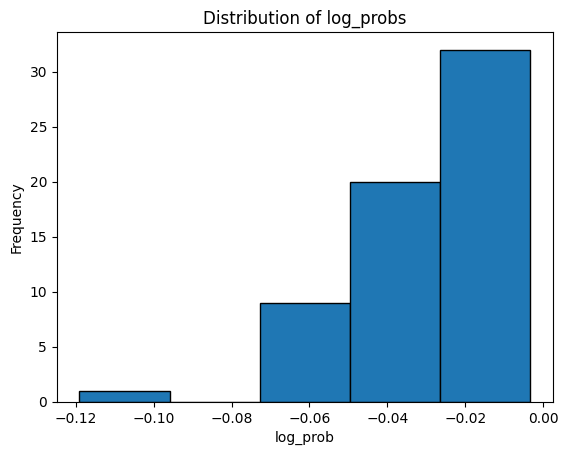

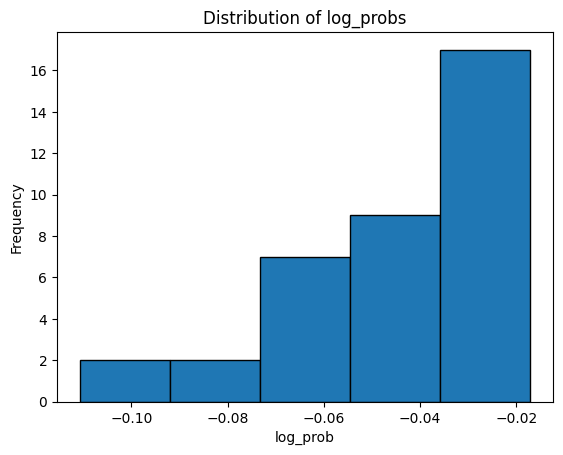

In [23]:
import matplotlib.pyplot as plt

# Plot histogram of log_probs
plt.hist(correct_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of log_probs
plt.hist(incorrect_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

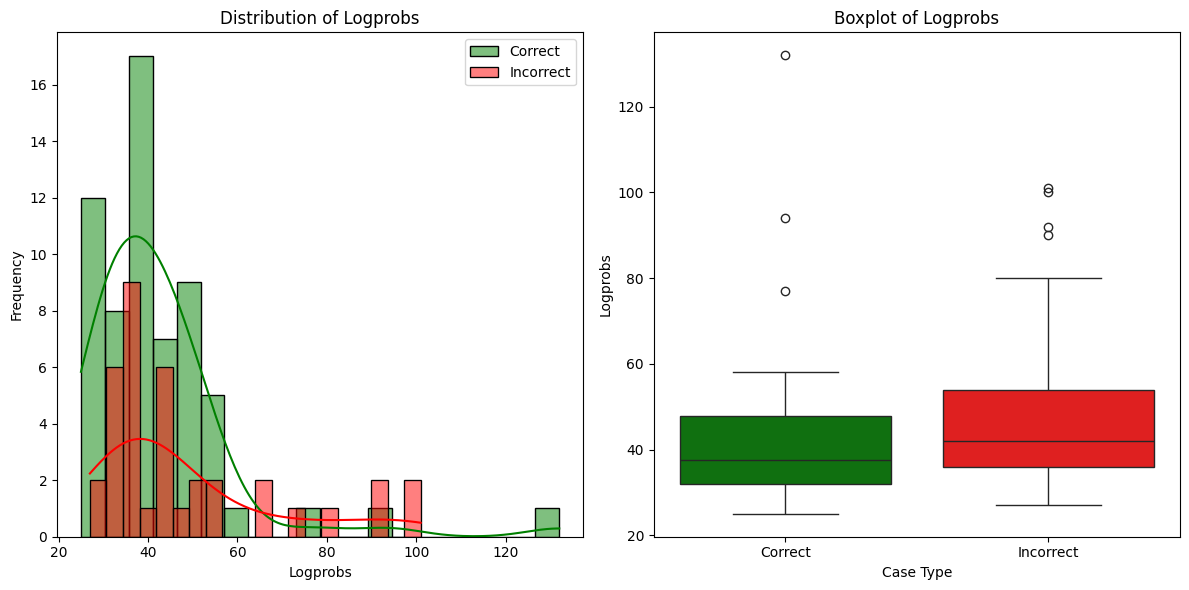

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_lengths, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_lengths, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_lengths, incorrect_lengths], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()

In [25]:
# Compute mean and standard deviation
child_length_correct_mean = np.mean(correct_lengths)
child_length_correct_std = np.std(correct_lengths)
child_length_incorrect_mean = np.mean(incorrect_lengths)
child_length_incorrect_std = np.std(incorrect_lengths)

print("Correct - Mean:", child_length_correct_mean, "Std:", child_length_correct_std)
print("Incorrect - Mean:", child_length_incorrect_mean, "Std:", child_length_incorrect_std)

Correct - Mean: 41.983870967741936 Std: 16.52904768199527
Incorrect - Mean: 48.78378378378378 Std: 20.317925962378887


# Openbook answer

In [26]:
import json

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_ob_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []
# Initialize lists to store lengths
correct_lengths = []
incorrect_lengths = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            ob_answer = node.get("ob_answer", [None])  # Extract the ob_answer
            ob_answer_text = ob_answer[0]
            ob_logprob = ob_answer[1]  # Extract logprobs
            ob_logprobs = ob_answer[3]  # Extract logprobs

            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]

                # Compare ob_answer_text with the gold answer
                # if normalize_answer(ob_answer_text) == normalize_answer(gold_answer):
                if are_answers_equivalent_using_llm(gold_answer, ob_answer_text):
                    print(f"OB Answer: {ob_answer_text}, Gold Answer: {gold_answer} : Correct")
                    correct_ob_answers += 1
                    correct_logprobs.append(ob_logprob)  # Save logprobs for correct cases
                    correct_lengths.append(len(ob_logprobs))
                    # X.append([ob_logprob])  # Feature
                    X.append(ob_logprobs)  # Feature
                    y.append(1)  # Label (correct)
                else:
                    print(f"OB Answer: {ob_answer_text}, Gold Answer: {gold_answer} : Incorrect")
                    if ob_logprob > -10:
                        incorrect_logprobs.append(ob_logprob)  # Save logprobs for incorrect cases
                        incorrect_lengths.append(len(ob_logprobs))
                        # X.append([ob_logprob])  # Feature
                        X.append(ob_logprobs)  # Feature
                        y.append(0)  # Label (incorrect)

# Calculate the accuracy
accuracy = (correct_ob_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times ob_answer matches gold answer: {correct_ob_answers}")
print(f"Open-book match rate: {accuracy:.2f}%")

OB Answer: Unknown., Gold Answer: 1450 mi : Incorrect
OB Answer: Unknown., Gold Answer: six weeks : Incorrect
OB Answer: Larry Gatlin & the Gatlin Brothers Band., Gold Answer: trio with his younger brothers Steve and Rudy : Correct
OB Answer: Unknown., Gold Answer: Puli Alam : Incorrect
OB Answer: Objectivism., Gold Answer: Objectivism : Correct
OB Answer: Unknown., Gold Answer: Alt-J : Incorrect
OB Answer: Unknown., Gold Answer: Virgin : Incorrect
OB Answer: Smoothie King Center., Gold Answer: Smoothie King Center : Correct
OB Answer: Unknown., Gold Answer: Qualcomm : Incorrect
OB Answer: Unknown., Gold Answer: 1800000 sqft : Incorrect
OB Answer: No., Gold Answer: no : Correct
OB Answer: Bolshoi Theatre., Gold Answer: Bolshoi Theatre : Correct
OB Answer: 2016 World Indoor Championships., Gold Answer: the 2016 World Indoor Championships : Correct
OB Answer: Circle-Vision., Gold Answer: the first to utilize Audio-Animatronics : Incorrect
OB Answer: Ice hockey., Gold Answer: ice hockey :

Correct Cases:
  Number of cases: 43
  Mean logprobs: -0.0380
  Standard deviation of logprobs: 0.0302

Incorrect Cases:
  Number of cases: 57
  Mean logprobs: -0.0846
  Standard deviation of logprobs: 0.0489


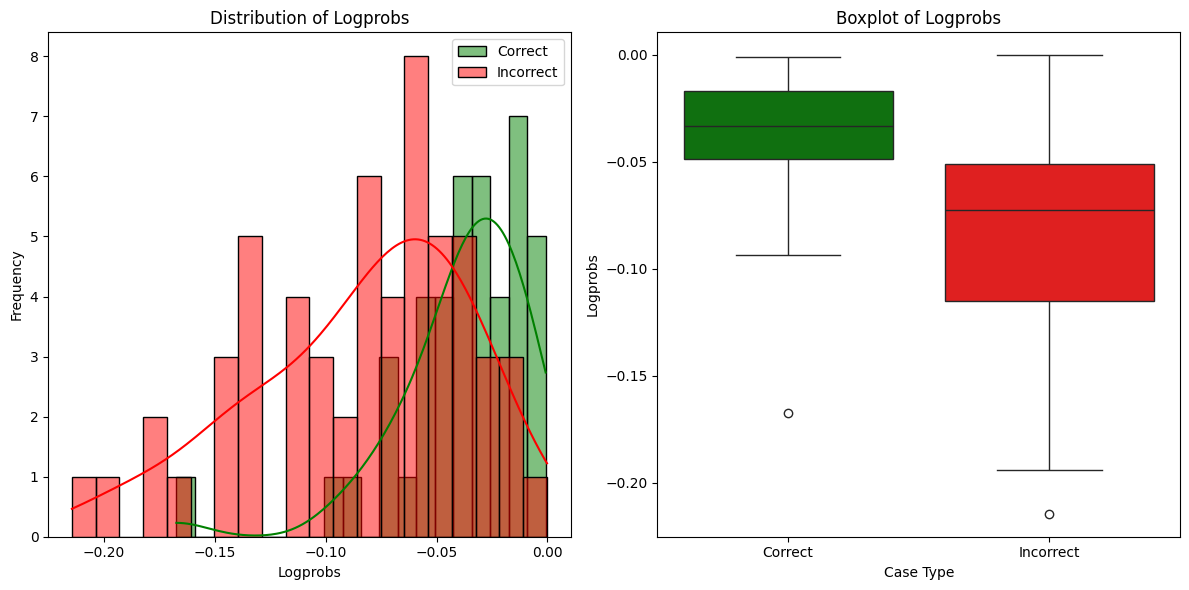

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate statistics for correct cases
correct_mean = np.mean(correct_logprobs) if correct_logprobs else 0
correct_std = np.std(correct_logprobs) if correct_logprobs else 0

# Calculate statistics for incorrect cases
incorrect_mean = np.mean(incorrect_logprobs) if incorrect_logprobs else 0
incorrect_std = np.std(incorrect_logprobs) if incorrect_logprobs else 0

# Print the results
print("Correct Cases:")
print(f"  Number of cases: {len(correct_logprobs)}")
print(f"  Mean logprobs: {correct_mean:.4f}")
print(f"  Standard deviation of logprobs: {correct_std:.4f}")

print("\nIncorrect Cases:")
print(f"  Number of cases: {len(incorrect_logprobs)}")
print(f"  Mean logprobs: {incorrect_mean:.4f}")
print(f"  Standard deviation of logprobs: {incorrect_std:.4f}")

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_logprobs, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_logprobs, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_logprobs, incorrect_logprobs], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()

In [28]:
# Compute mean and standard deviation
ob_logprob_correct_mean = np.mean(correct_logprobs)
ob_logprob_correct_std = np.std(correct_logprobs)
ob_logprob_incorrect_mean = np.mean(incorrect_logprobs)
ob_logprob_incorrect_std = np.std(incorrect_logprobs)

print("Correct - Mean:", ob_logprob_correct_mean, "Std:", ob_logprob_correct_std)
print("Incorrect - Mean:", ob_logprob_incorrect_mean, "Std:", ob_logprob_incorrect_std)

Correct - Mean: -0.038047327679942046 Std: 0.030174532822124452
Incorrect - Mean: -0.08461304454673864 Std: 0.048904918733294896


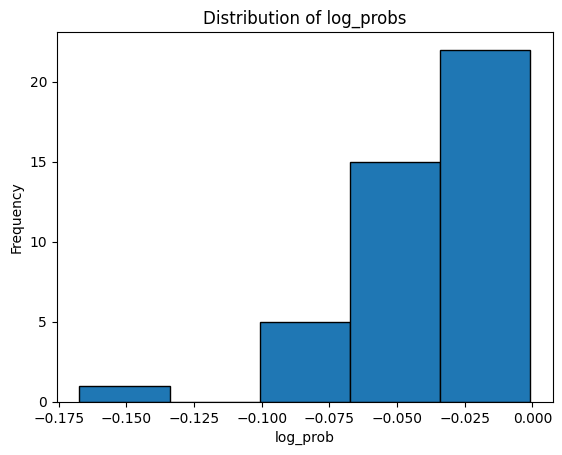

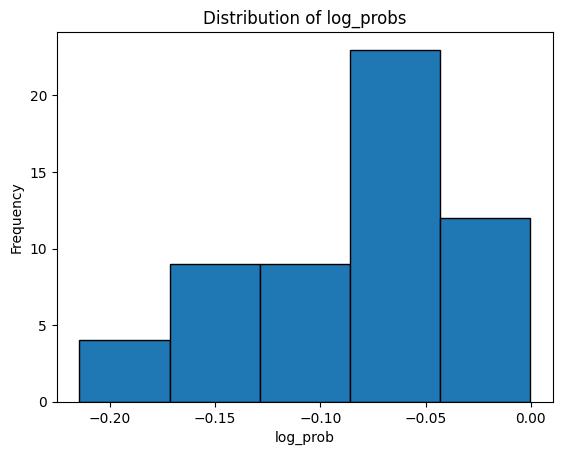

In [29]:
import matplotlib.pyplot as plt

# Plot histogram of log_probs
plt.hist(correct_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of log_probs
plt.hist(incorrect_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

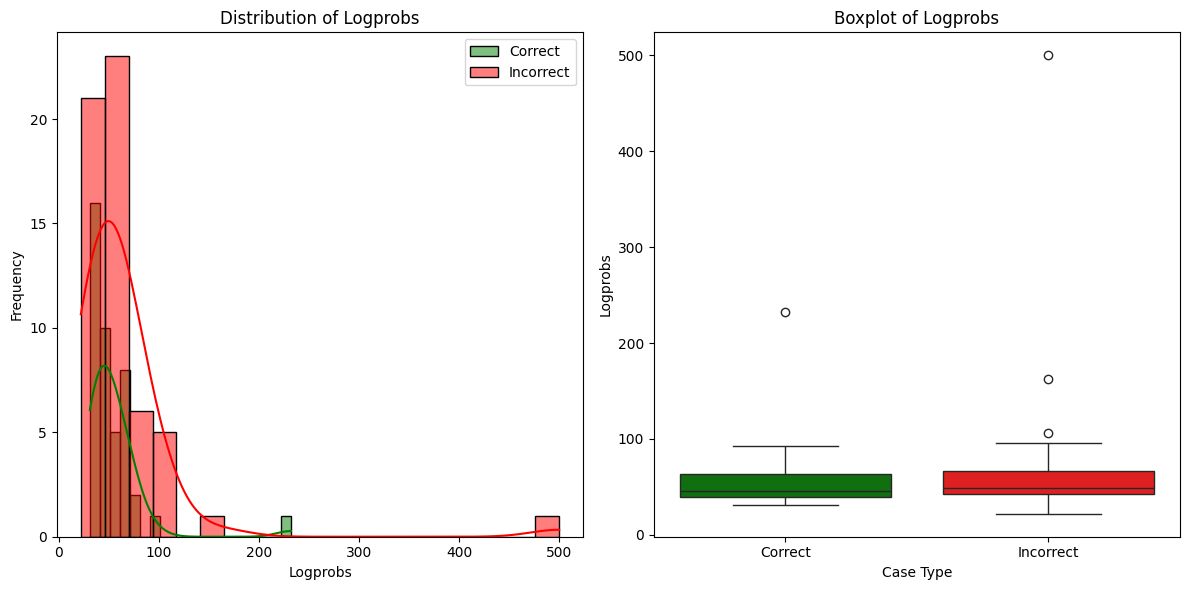

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_lengths, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_lengths, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_lengths, incorrect_lengths], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()

In [31]:
# Compute mean and standard deviation
ob_length_correct_mean = np.mean(correct_lengths)
ob_length_correct_std = np.std(correct_lengths)
ob_length_incorrect_mean = np.mean(incorrect_lengths)
ob_length_incorrect_std = np.std(incorrect_lengths)

print("Correct - Mean:", ob_length_correct_mean, "Std:", ob_length_correct_std)
print("Incorrect - Mean:", ob_length_incorrect_mean, "Std:", ob_length_incorrect_std)

Correct - Mean: 54.2093023255814 Std: 30.94748600792841
Incorrect - Mean: 63.08771929824562 Std: 63.37531776500962


In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad/truncate sequences to the maximum log prob sequence length
max_length = max(len(seq) for seq in X)
X_ob_padded = pad_sequences(X, maxlen=max_length, padding="post", truncating="post", value=-100, dtype="float32")
X_ob_padded

array([[-1.2695312e-01,  0.0000000e+00, -1.8188477e-02, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-5.7421875e-01, -1.1672974e-03,  0.0000000e+00, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-6.1035156e-04, -1.6015625e-01, -5.7421875e-01, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       ...,
       [-7.0312500e-02, -5.7421875e-01, -9.8437500e-01, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-8.8500977e-03,  0.0000000e+00,  0.0000000e+00, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-8.2031250e-02,  0.0000000e+00,  0.0000000e+00, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02]], dtype=float32)

Class Distribution: [57 43]
Model Evaluation (Adjusted Threshold):
  Accuracy: 0.7000
  Precision: 0.8000
  Recall: 0.6667
  F1-Score: 0.7273
  ROC AUC: 0.7708


/Users/ahmed.ehab/Desktop/Guided-Research/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


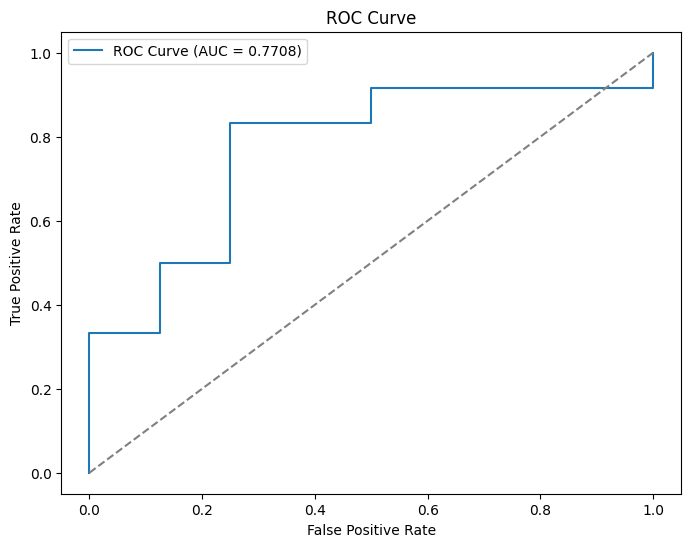

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.7000
  Precision: 0.8000
  Recall: 0.6667
  F1-Score: 0.7273
  ROC AUC: 0.7708


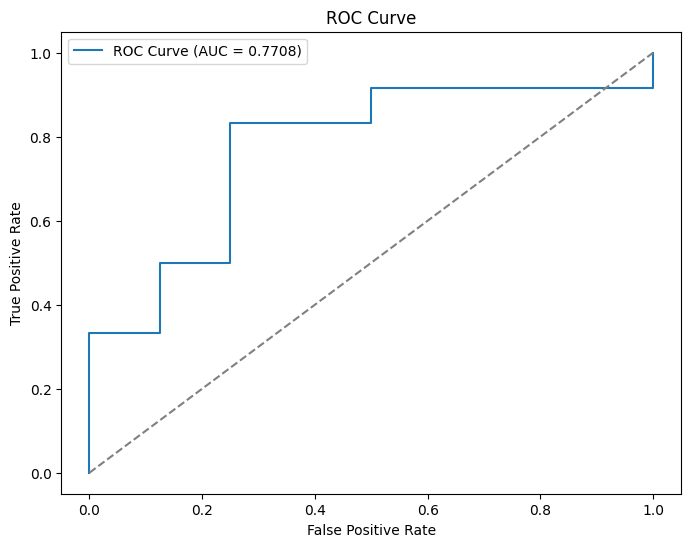

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.7000
  Precision: 0.8000
  Recall: 0.6667
  F1-Score: 0.7273
  ROC AUC: 0.7708


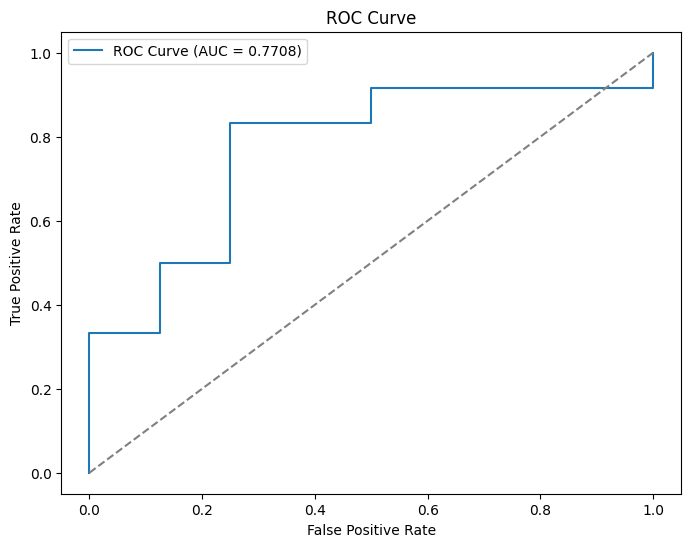

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.7000
  Precision: 0.8000
  Recall: 0.6667
  F1-Score: 0.7273
  ROC AUC: 0.7708


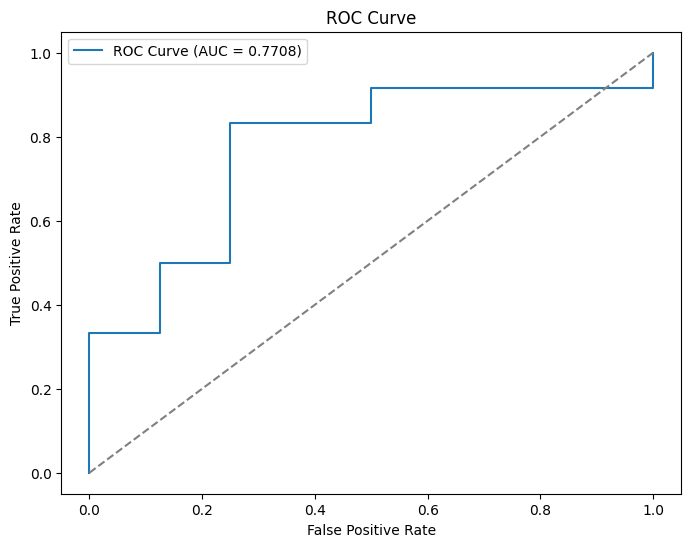

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.7000
  Precision: 0.8000
  Recall: 0.6667
  F1-Score: 0.7273
  ROC AUC: 0.7708


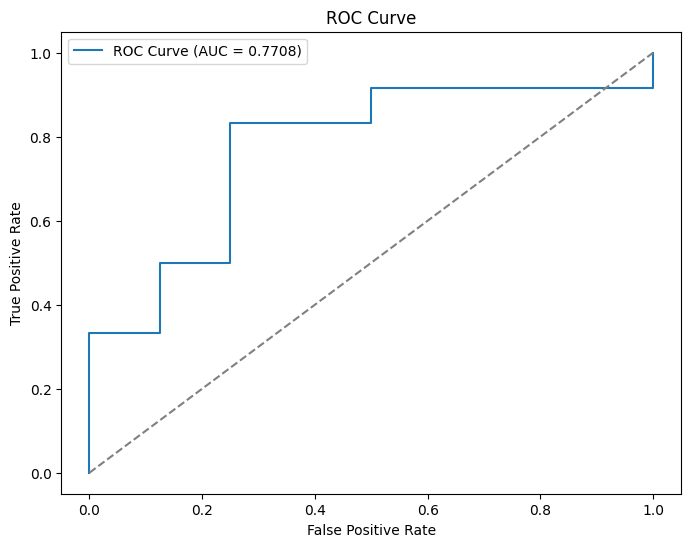

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.6500
  Precision: 0.7778
  Recall: 0.5833
  F1-Score: 0.6667
  ROC AUC: 0.7708


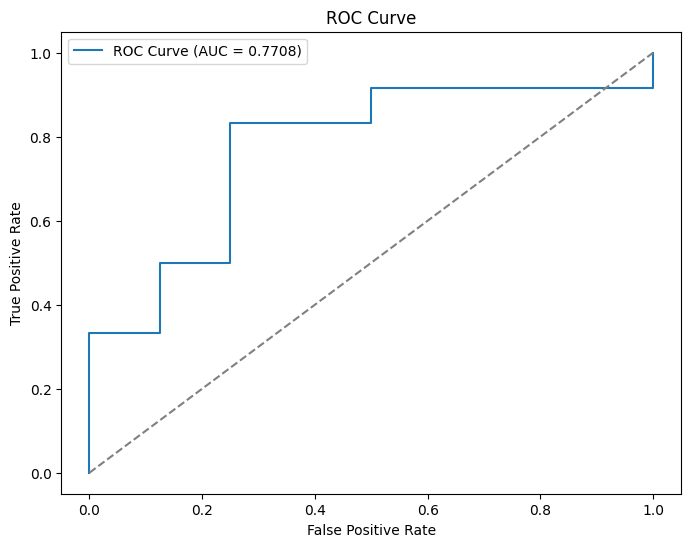

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.5500
  Precision: 0.8000
  Recall: 0.3333
  F1-Score: 0.4706
  ROC AUC: 0.7708


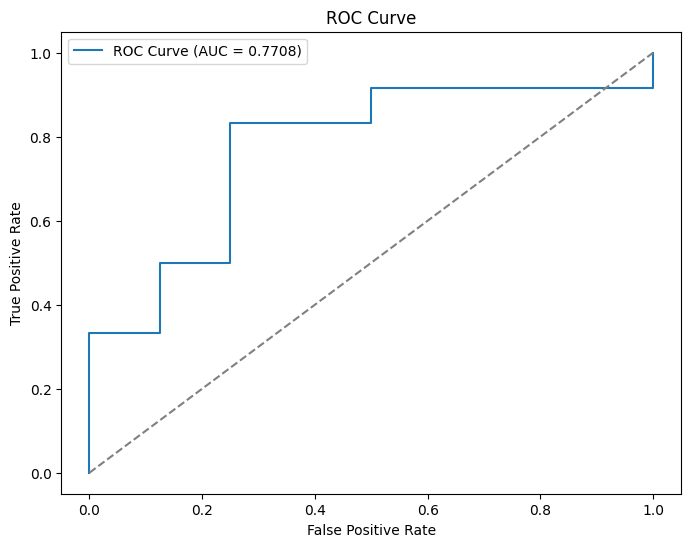

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.5500
  Precision: 0.8000
  Recall: 0.3333
  F1-Score: 0.4706
  ROC AUC: 0.7708


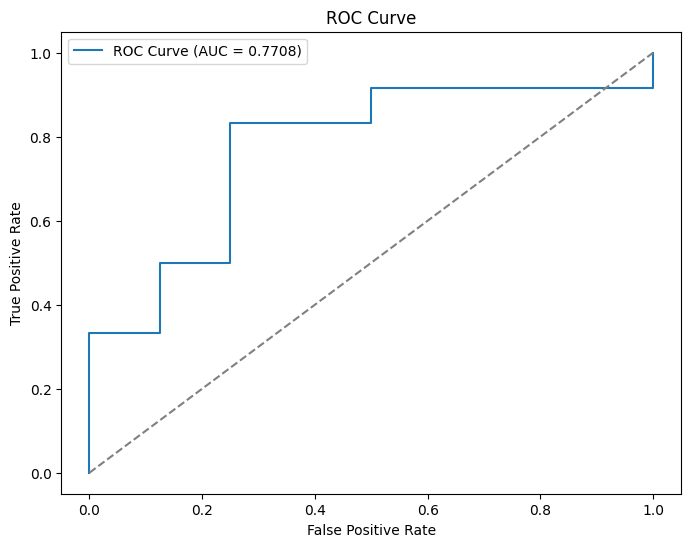

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.5500
  Precision: 0.8000
  Recall: 0.3333
  F1-Score: 0.4706
  ROC AUC: 0.7708


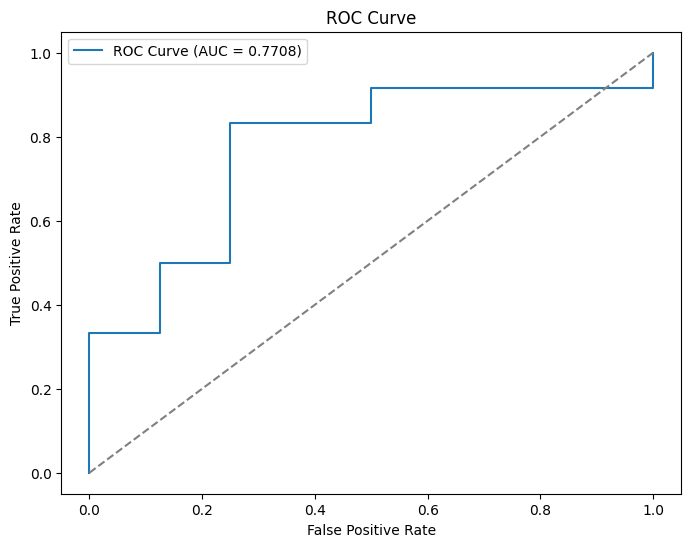

In [33]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # Convert to numpy arrays
# X = np.array(X)
# y = np.array(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # Check class distribution
# print("Class Distribution:", np.bincount(y))

# # Train a Logistic Regression model with class weights
# model = LogisticRegression(class_weight="balanced")
# model.fit(X_train, y_train)

# # Make predictions
# y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# # Adjust threshold
# threshold = 0.3  # Experiment with different thresholds
# y_pred_adj = (y_pred_proba >= threshold).astype(int)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred_adj)
# precision = precision_score(y_test, y_pred_adj)
# recall = recall_score(y_test, y_pred_adj)
# f1 = f1_score(y_test, y_pred_adj)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# print("Model Evaluation (Adjusted Threshold):")
# print(f"  Accuracy: {accuracy:.4f}")
# print(f"  Precision: {precision:.4f}")
# print(f"  Recall: {recall:.4f}")
# print(f"  F1-Score: {f1:.4f}")
# print(f"  ROC AUC: {roc_auc:.4f}")

# # Plot the ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()



import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ob_padded, y, test_size=0.2, random_state=42)

# Check class distribution
print("Class Distribution:", np.bincount(y))

# Train a Logistic Regression model with class weights
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# loop on thresholds from 0.1 to 0.9
for i in range(1, 10):
    threshold = i / 10

    # Adjust threshold
    # threshold = i  # Experiment with different thresholds
    y_pred_adj = (y_pred_proba >= threshold).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_adj)
    precision = precision_score(y_test, y_pred_adj)
    recall = recall_score(y_test, y_pred_adj)
    f1 = f1_score(y_test, y_pred_adj)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Model Evaluation (Adjusted Threshold):")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Prepare the dataset (X and y from previous steps)
# X: logprobs, y: labels (1 for correct, 0 for incorrect)

# Train a Logistic Regression model
# model = LogisticRegression(class_weight="balanced")
# model.fit(X, y)

# # Generate a range of logprobs values for visualization
# logprobs_range = np.linspace(np.min(X), np.max(X), 1000).reshape(-1, 1)

# # Predict probabilities for the range of logprobs values
# probabilities = model.predict_proba(logprobs_range)[:, 1]  # Probability of being correct

# # Find the decision boundary (where probability = 0.5)
# decision_boundary = logprobs_range[np.argmin(np.abs(probabilities - 0.5))]

# # Plot the decision boundary and examples
# plt.figure(figsize=(10, 6))

# # Plot correct and incorrect examples
# plt.scatter(X[y == 1], np.zeros_like(X[y == 1]), color="green", label="Correct", alpha=0.6)
# plt.scatter(X[y == 0], np.zeros_like(X[y == 0]), color="red", label="Incorrect", alpha=0.6)

# # Plot the predicted probabilities
# plt.plot(logprobs_range, probabilities, color="blue", label="Predicted Probability (Correct)")

# # Plot the decision boundary
# plt.axvline(x=decision_boundary, color="black", linestyle="--", label="Decision Boundary (p=0.5)")

# # Add labels and legend
# plt.xlabel("Logprobs")
# plt.ylabel("Probability / Examples")
# plt.title("Decision Boundary and Examples")
# plt.legend()
# plt.grid(True)
# plt.show()

# If both cb and ob combined, the total matches with gold answers are: 53
### Cb alone: 39, Ob alone: 34
### So the best we can do from our model, is to get the 53 correct

In [35]:
import json

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            ob_answer = node.get("ob_answer", [None])  # Extract the ob_answer
            ob_answer_text = ob_answer[0]
            cb_answer_text = node.get("cb_answer", [None])[0]


            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]

                # Compare ob_answer_text with the gold answer
                # if normalize_answer(ob_answer_text) == normalize_answer(gold_answer) or normalize_answer(cb_answer_text) == normalize_answer(gold_answer):
                if are_answers_equivalent_using_llm(gold_answer, ob_answer_text) or are_answers_equivalent_using_llm(gold_answer, cb_answer_text):
                    print(f"OB Answer: {ob_answer_text}, CB Answer: {cb_answer_text}, Gold Answer: {gold_answer} : Correct")
                    correct_answers += 1
                else:
                    print(f"OB Answer: {ob_answer_text}, CB Answer: {cb_answer_text}, Gold Answer: {gold_answer} : Incorrect")

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times cb_answer & ob_answer matches gold answer: {correct_answers}")
print(f"Closed-book & Open-book match rate: {accuracy:.2f}%")

OB Answer: Unknown., CB Answer: 2,330 kilometers., Gold Answer: 1450 mi : Correct
OB Answer: Unknown., CB Answer: 104., Gold Answer: six weeks : Incorrect
OB Answer: Larry Gatlin & the Gatlin Brothers Band., CB Answer: Rogers., Gold Answer: trio with his younger brothers Steve and Rudy : Correct
OB Answer: Unknown., CB Answer: Pul-i-Alam., Gold Answer: Puli Alam : Correct
OB Answer: Objectivism., CB Answer: Objectivism., Gold Answer: Objectivism : Correct
OB Answer: Unknown., CB Answer: Dada., Gold Answer: Alt-J : Incorrect
OB Answer: Unknown., CB Answer: Virgin Records., Gold Answer: Virgin : Incorrect
OB Answer: Smoothie King Center., CB Answer: American Airlines Center., Gold Answer: Smoothie King Center : Correct
OB Answer: Unknown., CB Answer: Qualcomm Stadium., Gold Answer: Qualcomm : Incorrect
OB Answer: Unknown., CB Answer: 1,807,000., Gold Answer: 1800000 sqft : Incorrect
OB Answer: No., CB Answer: no., Gold Answer: no : Correct
OB Answer: Bolshoi Theatre., CB Answer: Bolshoi 

In [36]:
import numpy as np

# Extract features and labels for parent nodes
X_cb = []  # CB logprobs
X_ob = []  # OB logprobs
X_child = []  # Child logprobs
y_cb = []  # 1 if CB answer matches final answer, else 0
y_ob = []  # 1 if OB answer matches final answer, else 0
y_child = []  # 1 if Child answer matches final answer, else 0

for example in data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            print(node)
            cb_answer = node.get("cb_answer", [None, None])[0]
            ob_answer = node.get("ob_answer", [None, None])[0]
            child_answer = node.get("child_answer", [None, None])[0]
            cb_logprob = node.get("cb_answer", [None, None])[3]
            ob_logprob = node.get("ob_answer", [None, None])[3]
            child_logprob = node.get("child_answer", [None, None])[3]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]

            # Check if CB answer matches final answer
            # if normalize_answer(cb_answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, cb_answer):
                y_cb.append(1)
            else:
                y_cb.append(0)
            # X_cb.append([cb_logprob])
            X_cb.append(cb_logprob)

            # Check if OB answer matches final answer
            # if normalize_answer(ob_answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, ob_answer):
                y_ob.append(1)
            else:
                y_ob.append(0)
            # X_ob.append([ob_logprob])
            X_ob.append(ob_logprob)

            # Check if Child answer matches final answer
            # if child_answer and normalize_answer(child_answer) == normalize_answer(final_answer):
            if child_answer and are_answers_equivalent_using_llm(final_answer, child_answer):
                y_child.append(1)
            else:
                y_child.append(0)
            # X_child.append([child_logprob])
            X_child.append(child_logprob)

# Pad/truncate sequences to the maximum log prob sequence length
cb_max_length = max(len(seq) for seq in X_cb)
X_cb_padded = pad_sequences(X_cb, maxlen=cb_max_length, padding="post", truncating="post", value=-100, dtype="float32")
ob_max_length = max(len(seq) for seq in X_ob)
X_ob_padded = pad_sequences(X_ob, maxlen=ob_max_length, padding="post", truncating="post", value=-100, dtype="float32")
child_max_length = max(len(seq) for seq in X_child)
X_child_padded = pad_sequences(X_child, maxlen=child_max_length, padding="post", truncating="post", value=-100, dtype="float32")

# Convert to numpy arrays
X_cb = np.array(X_cb_padded)
X_ob = np.array(X_ob_padded)
X_child = np.array(X_child_padded)
y_cb = np.array(y_cb)
y_ob = np.array(y_ob)
y_child = np.array(y_child)

{'idx': 2, 'question_text': 'What is the length of the river into which Pack Creek runs after it goes through the Spanish Valley?', 'sons': [0, 1], 'qd_logprob': -0.004028471539149616, 'question': 'What is the length of the river into which Pack Creek runs after it goes through the Spanish Valley?', 'cb_answer': ['2,330 kilometers.', -0.02823499480124424, 'The river into which Pack Creek runs after it goes through the Spanish Valley is the Colorado River. The length of the Colorado River is approximately 2,330 kilometers. So the answer is: 2,330 kilometers.', [-0.25390625, -0.07763672, -4.029274e-05, 0, 0, 0, -5.9604645e-07, -0.0005531311, 0, -5.9604645e-07, 0, 0, 0, 0, -1.1920929e-07, 0, -8.1539154e-05, 0, 0, -3.33786e-05, -0.0052490234, 0, 0, -3.5762787e-07, 0, 0, -0.014160156, 0, -0.0019302368, 0, -3.7431717e-05, 0, -0.578125, 0, 0, 0, 0, 0, 0, -1.2993813e-05, 0, 0, -1.0728836e-06, -2.3841858e-07, -1.0251999e-05]], 'ob_answer': ['Unknown.', -0.03611261820892971, 'Pack Creek flows th

In [37]:
X_cb

array([[-2.5390625e-01, -7.7636719e-02, -4.0292740e-05, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-3.8867188e-01, -6.2255859e-02, -5.9604645e-07, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-9.4985962e-04, -8.6059570e-03, -7.9101562e-02, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       ...,
       [-1.1596680e-03, -3.8623810e-05, -7.9296875e-01, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-1.4221191e-02,  0.0000000e+00,  0.0000000e+00, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-1.3504028e-03, -1.3113022e-06, -3.3760071e-04, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02]], dtype=float32)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into train and test sets
X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(X_cb, y_cb, test_size=0.2, random_state=42)
X_ob_train, X_ob_test, y_ob_train, y_ob_test = train_test_split(X_ob, y_ob, test_size=0.2, random_state=42)
X_child_train, X_child_test, y_child_train, y_child_test = train_test_split(X_child, y_child, test_size=0.2, random_state=42)

# Train CB model
# cb_model = LogisticRegression(class_weight="balanced")
cb_model = RandomForestClassifier(class_weight="balanced", random_state=42)
cb_model.fit(X_cb_train, y_cb_train)

# Evaluate CB model
y_cb_pred = cb_model.predict(X_cb_test)
print("CB Model Accuracy:", accuracy_score(y_cb_test, y_cb_pred))

# Train OB model
# ob_model = LogisticRegression(class_weight="balanced")
ob_model = RandomForestClassifier(class_weight="balanced", random_state=42)
ob_model.fit(X_ob_train, y_ob_train)

# Evaluate OB model
y_ob_pred = ob_model.predict(X_ob_test)
print("OB Model Accuracy:", accuracy_score(y_ob_test, y_ob_pred))

# Train Child model
# child_model = LogisticRegression(class_weight="balanced")
child_model = RandomForestClassifier(class_weight="balanced", random_state=42)
child_model.fit(X_child_train, y_child_train)

# Evaluate Child model
y_child_pred = child_model.predict(X_child_test)
print("Child Model Accuracy:", accuracy_score(y_child_test, y_child_pred))

CB Model Accuracy: 0.55
OB Model Accuracy: 0.75
Child Model Accuracy: 0.7


# Greedy Solver

In [39]:
def find_node_by_idx(idx):
    # Function to find a node by its index in the tree
    for example in data:
        for node in example:
            if node.get("idx") == idx:
                return node
    return None

def aggregate_answers(answers):
    # Example aggregation logic: majority voting
    from collections import Counter
    if not answers:
        return None
    counter = Counter(answers)
    return counter.most_common(1)[0][0]

def greedy_solver(node, cb_model, ob_model):
    # Step 1: Check CB answer
    print('node.get("cb_answer")', node.get("cb_answer"))
    cb_answer, cb_logprob, _, cb_logprobs = node.get("cb_answer")
    # cb_reliable = cb_model.predict([[cb_logprob]])[0] == 1  # Predict reliability
    cb_logprobs_padded = pad_sequences([cb_logprobs], maxlen=cb_max_length, padding="post", truncating="post", value=-100, dtype="float32")
    cb_reliable = cb_model.predict(cb_logprobs_padded)[0] == 1  # Predict reliability
    if cb_reliable:
        print("CB answer is reliable")
        return cb_answer, "CB"  # Accept CB answer

    # Step 2: Check OB answer
    ob_answer, ob_logprob, _, ob_logprobs = node.get("ob_answer")
    # ob_reliable = ob_model.predict([[ob_logprob]])[0] == 1  # Predict reliability
    ob_logprobs_padded = pad_sequences([ob_logprobs], maxlen=ob_max_length, padding="post", truncating="post", value=-100, dtype="float32")
    ob_reliable = ob_model.predict(ob_logprobs_padded)[0] == 1  # Predict reliability
    if ob_reliable:
        print("CB answer is reliable")
        return ob_answer, "OB"  # Accept OB answer

    # Step 3: Expand the Tree (Child Aggregation)
    if "sons" in node and node["sons"]:  # Check if node has children
        child_abswer, child_logprob, _, child_logprobs = node.get("child_answer")
        # child_reliable = child_model.predict([[child_logprob]])[0] == 1
        child_logprobs_padded = pad_sequences([child_logprobs], maxlen=child_max_length, padding="post", truncating="post", value=-100, dtype="float32")
        child_reliable = child_model.predict(child_logprobs_padded)[0] == 1  # Predict reliability
        if child_reliable:
            print("Child answer is reliable")
            return child_answer, "Child"  # Accept Child answer

    # If no method produces a reliable answer, return the best available
    print("No reliable answer found, returning the best available answer")
    if cb_logprob > ob_logprob and cb_logprob > child_logprob:
        print("Best Answer: CB, Best Method: CB")
        return cb_answer, "CB"
    elif ob_logprob > cb_logprob and ob_logprob > child_logprob:
        print("Best Answer: OB, Best Method: OB")
        return ob_answer, "OB"
    else:
        print("Best Answer: Child, Best Method: Child")
        return child_answer, "Child"

In [40]:
# Run the greedy solver on all parent nodes
results = []
correct_answers = 0
total_parent_nodes = 0
for example in data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer, method = greedy_solver(node, cb_model, ob_model)
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, answer):
                correct_answers += 1
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "method": method
            })

# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Greedy Solver match rate: {accuracy:.2f}%")

node.get("cb_answer") ['2,330 kilometers.', -0.02823499480124424, 'The river into which Pack Creek runs after it goes through the Spanish Valley is the Colorado River. The length of the Colorado River is approximately 2,330 kilometers. So the answer is: 2,330 kilometers.', [-0.25390625, -0.07763672, -4.029274e-05, 0, 0, 0, -5.9604645e-07, -0.0005531311, 0, -5.9604645e-07, 0, 0, 0, 0, -1.1920929e-07, 0, -8.1539154e-05, 0, 0, -3.33786e-05, -0.0052490234, 0, 0, -3.5762787e-07, 0, 0, -0.014160156, 0, -0.0019302368, 0, -3.7431717e-05, 0, -0.578125, 0, 0, 0, 0, 0, 0, -1.2993813e-05, 0, 0, -1.0728836e-06, -2.3841858e-07, -1.0251999e-05]]
Child answer is reliable
node.get("cb_answer") ['104.', -0.22189754229402112, 'The North Midland Divisional Engineers took part in a battle during WWII known as the Siege of Malta or more specifically, the North Midland Divisional Engineers were part of the Malta Garrison during the Siege of Malta. The Siege of Malta went on for 2 years, but a more specific a

In [41]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
for example in data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, answer):
                correct_answers += 1
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Greedy Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the length of the river into which Pack Creek runs after it goes through the Spanish Valley?
  Answer: land bridge.
  Method: Child

Node 2:
  Question: North Midland Divisional Engineers took part in a battle during WWII that went on for how many weeks ?
  Answer: land bridge.
  Method: Child

Node 2:
  Question: What trio was the songwriter of 'What Are We Doin' Lonesome' from?
  Answer: Larry Gatlin & the Gatlin Brothers Band.
  Method: OB

Node 2:
  Question: Baraki Barak District is situated in the western part of a province whose capital is what?
  Answer: Pul-i-Alam.
  Method: CB

Node 2:
  Question: Atlas Shrugged was a film based on the books by a proponent of what philosophy?
  Answer: Objectivism.
  Method: CB

Node 2:
  Question: Which has more members, Dada or Alt-J?
  Answer: land bridge.
  Method: Child

Node 2:
  Question: 'She's a Mystery to Me' is a song on an album released in 1989 by what label?
  Answer: land bridge.
  Method: Child

Nod

## Try it on hotpot data as our test data (need to rerun the models on results-testset-hotpotqa since in greedy we need logprobs!)

In [69]:
# Load test data
with open('results-testset-hotpotqa.json', 'r') as file:
    test_data = json.load(file)

raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        # TODO:: should add it later but run prompts again 
        # question = re.sub(r'\s+', ' ', question)
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        # If question not found in question_decompositions, this means something went wrong in the proccess maybe in json parsing in prev steps of tree generation
        print("ERROR CASE", e)

In [70]:
# Run the greedy solver on all parent nodes
results = []
correct_answers = 0
total_parent_nodes = 0
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer, method = greedy_solver(node, cb_model, ob_model)
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, answer):
                correct_answers += 1
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "method": method
            })

# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Greedy Solver match rate: {accuracy:.2f}%")

node.get("cb_answer") ['American.', -0.036275435172858146, "The foreign-born victim of Singapore's caning punishment before Oliver Fricker experienced the same is Michael Fay. Michael Fay is an American. So the answer is: American.", [-0.2265625, -0.0002002716, -0.38671875, -9.679794e-05, -1.6093254e-05, 0, 0, 0, 0, 0, -0.00016975403, -0.011047363, -1.1920929e-07, -4.2915344e-06, -0.04296875, -5.9604645e-07, -7.1525574e-07, -0.004119873, -1.9550323e-05, -0.25976562, -0.0015029907, -8.34465e-07, 0, -0.0052490234, -0.0007095337, -1.1920929e-07, -0.040283203, -0.0042419434, -1.1920929e-07, -3.33786e-06, 0, 0, 0, 0, -9.179115e-06]]
CB answer is reliable
node.get("cb_answer") ['The Picture of Dorian Gray.', -0.027692482379997198, 'The main character Dorian Gray is from the novel "The Picture of Dorian Gray". The novel "The Picture of Dorian Gray" is a philosophical novel whose editor feared the story was indecent, and deleted roughly five hundred words before publication. So the answer is: 

In [ ]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, answer):
                correct_answers += 1
            
            if answer == node.get("cb_answer"):
                method = "CB"
            elif answer == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"

            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "method": method,
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Prob Tree Solver match rate: {accuracy:.2f}%")

# Resampling a tree from a question

In [37]:
from Tree_Generation.tree_resampling import TreeResamplingPipeline
# tree_resampling_pipeline = TreeResamplingPipeline()
tree_resampling_pipeline = TreeResamplingPipeline(use_cache=True)
question = "what is the population size of the smallest city in the world?"
tree_resampling_pipeline.resample_tree(question=question)

Loading cache from ./cache_0.7.jsonl
Loaded 566 cached responses


[{'idx': 0,
  'question_text': 'What is the smallest city in the world?',
  'sons': [],
  'qd_logprob': None,
  'fa': 2},
 {'idx': 1,
  'question_text': 'What is the population size of <1>?',
  'sons': [],
  'qd_logprob': None,
  'fa': 2},
 {'idx': 2,
  'question_text': 'what is the population size of the smallest city in the world?',
  'sons': [0, 1],
  'qd_logprob': -5.6896892894761904e-05}]

# RL Approach 

In [ ]:
# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset-hotpotqa.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)


In [39]:
import numpy as np
import random
from collections import defaultdict

# Define the state space, action space, and Q-table
action_space = ['CB', 'OB', 'Child']  # Possible actions
Q = defaultdict(lambda: np.zeros(len(action_space)))  # Q-table

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.98
epsilon_min = 0.01

# Initialize global counters for success rates
success_counts = {"cb": 0, "ob": 0, "child": 0}
attempt_counts = {"cb": 0, "ob": 0, "child": 0}

# Define the reward function
def get_reward(chosen_answer, gold_answer):
    # if normalize_answer(chosen_answer) == normalize_answer(gold_answer):
    if are_answers_equivalent_using_llm(gold_answer, chosen_answer):
        return 1
    else:
        return -1

# Function to update success rates dynamically
def update_success_rate(answer_type, is_correct):
    """
    Update the success rate for a given answer type.
    :param answer_type: "cb", "ob", or "child"
    :param is_correct: True if the answer was correct, False otherwise
    """
    global success_counts, attempt_counts
    answer_type = answer_type.lower()
    attempt_counts[answer_type] += 1
    if is_correct:
        success_counts[answer_type] += 1

def get_success_rate(answer_type):
    """
    Get the current success rate for a given answer type.
    :param answer_type: "cb", "ob", or "child"
    :return: Success rate (float)
    """
    global success_counts, attempt_counts
    if attempt_counts[answer_type] == 0:
        # Default success rates (can be adjusted based on prior knowledge)
        default_rates = {"cb": 0.32, "ob": 0.32, "child": 0.42}
        return default_rates[answer_type]
    return success_counts[answer_type] / attempt_counts[answer_type]

# Q-learning algorithm
def q_learning(node, gold_answer):
    global epsilon
    state = tuple(get_state(node))  # Convert state to tuple
    if random.uniform(0, 1) < epsilon:
        action = random.choice(action_space)  # Explore action space
    else:
        # action = action_space[np.argmax(Q[state])]  # Exploit learned values
        max_q_value = np.max(Q[state])  # Find the maximum Q-value
        best_actions = [action_space[i] for i, q in enumerate(Q[state]) if q == max_q_value]  # Get all actions with max Q-value
        action = np.random.choice(best_actions)  # Choose randomly among them


    # Simulate the action (choose answer based on action)
    if action == 'CB':
        answer = node.get("cb_answer")[0]
    elif action == 'OB':
        answer = node.get("ob_answer")[0]
    else:
        answer = node.get("child_answer")[0]

    # Compute reward
    reward = get_reward(answer, gold_answer)
    next_state = tuple(get_state(node))  # Convert next_state to tuple

    # Update Q-value
    old_value = Q[state][action_space.index(action)]
    next_max = np.max(Q[next_state])
    Q[state][action_space.index(action)] = old_value + alpha * (reward + gamma * next_max - old_value)

    # Update success rate for the chosen action
    is_correct = (reward == 1)
    update_success_rate(action.lower(), is_correct)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    return answer, action

def discretize_z_score(z):
    if z < -2:
        return 0  # Very low confidence
    elif -2 <= z < 0:
        return 1  # Low confidence
    elif 0 <= z < 2:
        return 2  # High confidence
    else:
        return 3  # Very high confidence
    
def compute_discretized_logprob_features(logprob, correct_mean, correct_std, incorrect_mean, incorrect_std):
    # Z-score for correct distribution
    z_correct = (logprob - correct_mean) / correct_std
    # Z-score for incorrect distribution
    z_incorrect = (logprob - incorrect_mean) / incorrect_std
    # Discretize Z-scores
    z_correct_bin = discretize_z_score(z_correct)
    z_incorrect_bin = discretize_z_score(z_incorrect)
    return [z_correct_bin, z_incorrect_bin]

# Function to get the state representation
def get_state(node, depth=0):
    # Extract log probabilities
    cb_logprob = node.get("cb_answer", [None, None])[1] or -100  # Default if missing
    ob_logprob = node.get("ob_answer", [None, None])[1] or -100
    child_logprob = node.get("child_answer", [None, None])[1] or -100

    # Extract answers
    cb_answer = node.get("cb_answer", [None])[0] or ""
    ob_answer = node.get("ob_answer", [None])[0] or ""
    child_answer = node.get("child_answer", [None])[0] or ""

    # Extract log_probs for each token
    cb_logprobs = node.get("cb_answer", [None, None, None, None])[3] or []
    ob_logprobs = node.get("ob_answer", [None, None, None, None])[3] or []
    child_logprobs = node.get("child_answer", [None, None, None, None])[3] or []

    # Compute answer lengths
    cb_answer_length = len(cb_logprobs)
    ob_answer_length = len(ob_logprobs)
    child_answer_length = len(child_logprobs)

    # Presence of children
    has_children = 1 if len(node.get("sons", [])) else 0

    # Question features
    question_text = node.get("question_text", "")
    question_length = len(question_text.split())
    question_type = encode_question_type(question_text)  # Implement this function

    # Confidence scores
    # cb_confidence = np.exp(cb_logprob)
    # ob_confidence = np.exp(ob_logprob)
    # child_confidence = np.exp(child_logprob)

    # Structural features
    num_children = len(node.get("sons", []))

    # Historical performance (dynamic success rates)
    cb_success_rate = get_success_rate("cb")
    ob_success_rate = get_success_rate("ob")
    child_success_rate = get_success_rate("child")

    # Build state vector
    state = [
        # removed log_probs for now because they are continuous and need to be discretized
        cb_logprob,
        ob_logprob,
        child_logprob,
        # *compute_discretized_logprob_features(cb_logprob, cb_logprob_correct_mean, cb_logprob_correct_std, cb_logprob_incorrect_mean, cb_logprob_incorrect_std),  # Discretized CB features
        # *compute_discretized_logprob_features(ob_logprob, ob_logprob_correct_mean, ob_logprob_correct_std, ob_logprob_incorrect_mean, ob_logprob_incorrect_std),  # Discretized OB features
        # *compute_discretized_logprob_features(child_logprob, child_logprob_correct_mean, child_logprob_correct_std, child_logprob_incorrect_mean, child_logprob_incorrect_std),  # Discretized Child features
        
        # *compute_discretized_logprob_features(cb_answer_length, cb_length_correct_mean, cb_length_correct_std, cb_length_incorrect_mean, cb_length_incorrect_std),  # Discretized CB features
        # *compute_discretized_logprob_features(ob_answer_length, ob_length_correct_mean, ob_length_correct_std, ob_length_incorrect_mean, ob_length_incorrect_std),  # Discretized OB features
        # *compute_discretized_logprob_features(child_answer_length, child_length_correct_mean, child_length_correct_std, child_length_incorrect_mean, child_length_incorrect_std),  # Discretized Child features
        # cb_answer_length,
        # ob_answer_length,
        # child_answer_length,
        # has_children,
        # question_length,
        # question_type,
        # ob_logprob > -10, # added them to avoid unknown answer
        # child_logprob > -10, # added them to avoid unknown answer
        # cb_confidence,
        # ob_confidence,
        # child_confidence,
        # depth,
        # num_children,
        # cb_success_rate,
        # ob_success_rate,
        # child_success_rate
    ]

    return state

def encode_question_type(question_text):
    # Example: Encode question type based on the first word
    first_word = question_text.strip().split()[0].lower()
    if first_word == "what":
        return 0
    elif first_word == "where":
        return 1
    elif first_word == "how":
        return 2
    else:
        return 3  # Other

# Hyperparameters for multiple iterations
num_iterations = 2000  # Number of iterations over the dataset

max_percentage, max_correct = 0, None
best_Q = None

# Run the Q-learning algorithm for multiple iterations
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")
    results = []
    correct_answers = 0
    total_parent_nodes = 0

    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                question_text = node.get("question_text", "").strip()
                final_answer, _ = q2gold[question_text]
                answer, method = q_learning(node, final_answer)
                # if normalize_answer(answer) == normalize_answer(final_answer):
                if are_answers_equivalent_using_llm(final_answer, answer):
                    correct_answers += 1
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": answer,
                    "method": method
                })

    # Print the results for this iteration
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    max_percentage = max(max_percentage, accuracy)
    if max_percentage == accuracy:
        max_correct = correct_answers
        best_Q = Q.copy()

    print(f"Total parent nodes: {total_parent_nodes}")
    print(f"Times answer matches gold answer: {correct_answers}")
    print(f"Q-learning Solver match rate: {accuracy:.2f}%")
    print()

Iteration 1/2000
Total parent nodes: 95
Times answer matches gold answer: 45
Q-learning Solver match rate: 47.37%

Iteration 2/2000
Total parent nodes: 95
Times answer matches gold answer: 58
Q-learning Solver match rate: 61.05%

Iteration 3/2000
Total parent nodes: 95
Times answer matches gold answer: 67
Q-learning Solver match rate: 70.53%

Iteration 4/2000
Total parent nodes: 95
Times answer matches gold answer: 67
Q-learning Solver match rate: 70.53%

Iteration 5/2000
Total parent nodes: 95
Times answer matches gold answer: 67
Q-learning Solver match rate: 70.53%

Iteration 6/2000
Total parent nodes: 95
Times answer matches gold answer: 66
Q-learning Solver match rate: 69.47%

Iteration 7/2000
Total parent nodes: 95
Times answer matches gold answer: 67
Q-learning Solver match rate: 70.53%

Iteration 8/2000
Total parent nodes: 95
Times answer matches gold answer: 67
Q-learning Solver match rate: 70.53%

Iteration 9/2000
Total parent nodes: 95
Times answer matches gold answer: 67
Q-l

In [40]:
attempt_counts, success_counts

({'cb': 62680, 'ob': 50773, 'child': 76547},
 {'cb': 43805, 'ob': 31897, 'child': 57782})

In [41]:
max_percentage, max_correct

(70.52631578947368, 67)

Child
Child
Child
Child
CB
OB
Child
Child
OB
CB
Child
OB
OB
Child
OB
CB
OB
OB
OB
OB
CB
Child
Child
CB
OB
OB
CB
OB
CB
Child
CB
OB
CB
CB
OB
Child
Child
Child
OB
CB
Child
Child
OB
CB
OB
OB
CB
Child
CB
CB
Child
CB
OB
Child
CB
CB
Child
Child
Child
CB
OB
Child
Child
Child
CB
CB
OB
OB
OB
OB
Child
Child
CB
Child
Child
OB
Child
Child
OB
Child
CB
CB
Child
Child
Child
CB
CB
OB
Child
OB
OB
OB
OB
Child
CB


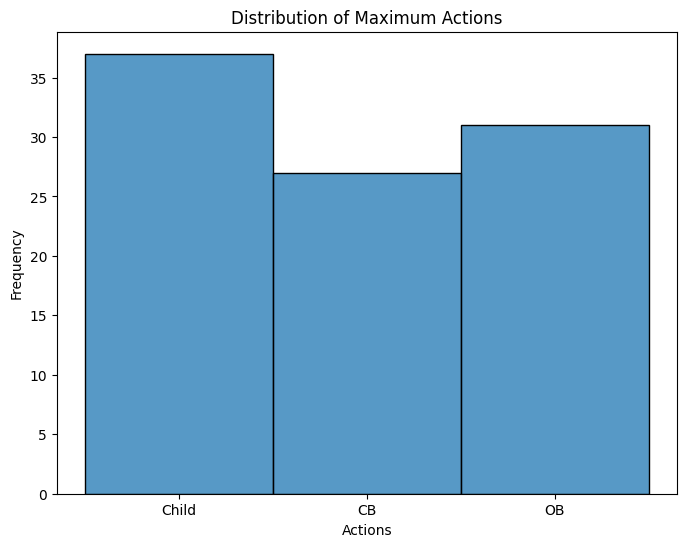

In [42]:
actions = []
for val in Q.values():
    # print action
    print(action_space[np.argmax(val)])
    actions.append(action_space[np.argmax(val)])

# Plot the distribution of actions
plt.figure(figsize=(8, 6))
sns.histplot(actions, bins=3, discrete=True)
plt.title("Distribution of Maximum Actions")
plt.xlabel("Actions")
plt.ylabel("Frequency")
plt.show()

## Try it on test set data of hotpot qa 

In [ ]:
import json
import numpy as np
import random
from collections import defaultdict


# Function to select an action using the trained Q-table (no exploration)
def select_action(state):
    """ Select the best action using the trained Q-values. """
    max_q_value = np.max(Q[state])  # Get max Q-value
    best_actions = [action_space[i] for i, q in enumerate(Q[state]) if q == max_q_value]  # Get all actions with max Q-value
    print("best_actions", best_actions)
    return np.random.choice(best_actions)  # Choose randomly if multiple exist



# Function to make predictions on test data
def run_inference(test_data):
    """ Run inference on the test data using the trained Q-table. """
    correct_answers = 0
    total_parent_nodes = 0
    results = []
    
    for example in test_data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                print(node["question_text"])
                state = tuple(get_state(node))  # Convert to tuple for Q-table lookup
                action = select_action(state)  # Use trained Q-table

                # Choose the answer based on the selected action
                if action == 'CB':
                    answer = node.get("cb_answer")[0]
                elif action == 'OB':
                    answer = node.get("ob_answer")[0]
                else:
                    if "child_answer" not in node:
                        action = "CB"
                        answer = node.get("cb_answer")[0]
                    else:
                        answer = node.get("child_answer")[0]

                if "unknown" in answer.lower().strip():
                    action = "CB"
                    answer = node.get("cb_answer")[0]
                    
                total_parent_nodes += 1
                final_answer, _ = q2gold[node["question_text"].strip()]
                print("final_answer", final_answer)
                print("answer", answer)
                # if normalize_answer(answer) == normalize_answer(final_answer):
                if are_answers_equivalent_using_llm(final_answer, answer):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": answer,
                    "gold": final_answer,
                    "method": action
                })

    return results, correct_answers, total_parent_nodes

# Load test data
with open('results-testset-hotpotqa.json', 'r') as file:
    test_data = json.load(file)

raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        # TODO:: should add it later but run prompts again 
        # question = re.sub(r'\s+', ' ', question)
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        # If question not found in question_decompositions, this means something went wrong in the proccess maybe in json parsing in prev steps of tree generation
        print("ERROR CASE", e)

# Run inference
Q = best_Q.copy()
rl_predictions, correct_answers, total_parent_nodes = run_inference(test_data)

# Print results
for pred in rl_predictions:  # Print only the first 10 for preview
    print(f"Q: {pred['question']}\nA: {pred['answer']} (Method: {pred['method']})\n")

What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
best_actions ['CB', 'OB', 'Child']
final_answer American
answer United States.
Who wrote the 1970 international hit song Murray Head is most recognized for?
best_actions ['CB', 'OB', 'Child']
final_answer Andrew Lloyd Webber and Tim Rice
answer Bonnie Bramlett, Leon Russell, and Delaney Bramlett.
Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
best_actions ['CB', 'OB', 'Child']
final_answer Wembley Stadium
answer Old Trafford.
Where was Nexon who was composed by Adam Gubman located at?
best_actions ['CB', 'OB', 'Child']
final_answer South Korea
answer Tokyo, Japan.
What event in 1920 was established by the director of the play "The Miracle"?
best_actions ['CB', 'OB', 'Child']
final_answer Salzburg Festival
answer the Salzburg Festival.
Chun Woo-hee's notable films include a South Korean horror film about

In [ ]:
# Print the results
for result in rl_predictions:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"RL Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: Bonnie Bramlett, Leon Russell, and Delaney Bramlett.
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: Child

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: the Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: Child

Node 2:
  Question: Chun Woo-hee's no

In [ ]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable films include a 

In [ ]:
# compare between rl_predictions and results
for rl_pred, prob_tree_result in zip(rl_predictions, results):
    if rl_pred['method'] == prob_tree_result['method']:
        continue
    print(f"Question: {rl_pred['question']}, Gold Answer: {q2gold[rl_pred['question']][0]}")
    print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
    print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
    print()


Question: Who wrote the 1970 international hit song Murray Head is most recognized for?, Gold Answer: Andrew Lloyd Webber and Tim Rice
RL Prediction: Bonnie Bramlett, Leon Russell, and Delaney Bramlett., ProbTree Result: The writers of "Jesus Christ Superstar".
RL Method: Child, ProbTree Method: OB

Question: What event in 1920 was established by the director of the play "The Miracle"?, Gold Answer: Salzburg Festival
RL Prediction: the Salzburg Festival., ProbTree Result: Salzburg Festival.
RL Method: Child, ProbTree Method: CB

Question: Chun Woo-hee's notable films include a South Korean horror film about  a policeman who investigates a series of mysterious killings and what?, Gold Answer: illnesses
RL Prediction: illnesses., ProbTree Result: The Wailing.
RL Method: OB, ProbTree Method: CB

Question: Are Catasetum and Origanum in the same family?, Gold Answer: no
RL Prediction: no., ProbTree Result: No.
RL Method: Child, ProbTree Method: OB

Question: Cooperative Living Organization 

# RL Approach with deep learning using question only in state

In [ ]:
# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset-hotpotqa.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# def get_state(node, depth=0):
#     # Extract raw features
#     cb_logprob = node.get("cb_answer", [None, None])[1] or -100
#     ob_logprob = node.get("ob_answer", [None, None])[1] or -100
#     child_logprob = node.get("child_answer", [None, None])[1] or -100
#     has_children = 1 if len(node.get("sons", [])) else 0
#     question_length = len(node.get("question_text", "").split())
#     question_type = encode_question_type(node.get("question_text", ""))
#     num_children = len(node.get("sons", []))
#     cb_success_rate = get_success_rate("cb")
#     ob_success_rate = get_success_rate("ob")
#     child_success_rate = get_success_rate("child")

#     # Build state vector
#     state = [
#         cb_logprob,
#         ob_logprob,
#         # child_logprob,
#         has_children,
#         question_length,
#         question_type,
#         num_children,
#         cb_success_rate,
#         ob_success_rate,
#         child_success_rate
#     ]
#     return torch.FloatTensor(state)

def pad_or_truncate(logprobs, max_length=50, pad_value=-100):
    if len(logprobs) < max_length:
        # Pad with pad_value
        return logprobs + [pad_value] * (max_length - len(logprobs))
    else:
        # Truncate to max_length
        return logprobs[:max_length]

# # Define the reward function
# def get_reward(chosen_answer, gold_answer):
#     if normalize_answer(chosen_answer) == normalize_answer(gold_answer):
#         return 1
#     else:
#         return -1

from sentence_transformers import SentenceTransformer, util
# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
# def get_reward(chosen_answer, gold_answer):
#     # Compute embeddings for the chosen and gold answers
#     chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
#     gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
#     # Compute cosine similarity
#     similarity = util.cos_sim(chosen_embedding, gold_embedding).item()
#     return similarity  # Reward is the similarity score (between -1 and 1)

def get_reward(chosen_answer, gold_answer, action, num_llm_calls, alpha=1.0, beta=0.1):
    """
    Reward function with tradeoff between accuracy and efficiency.
    :param chosen_answer: Answer chosen by the agent.
    :param gold_answer: Ground truth answer.
    :param action: The action selected by the agent (0=CB, 1=OB, 2=Child).
    :param num_llm_calls: The number of LLM calls made during the current decision.
    :param alpha: Weight for accuracy reward.
    :param beta: Weight for efficiency penalty.
    :return: A reward value that balances accuracy and efficiency.
    """
    # Compute Accuracy Reward
    chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
    gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
    similarity = util.cos_sim(chosen_embedding, gold_embedding).item()  # Value between -1 (opposite) and 1 (exact match)
    accuracy_reward = max(0, similarity)  # Ensure rewards are non-negative

    # Define LLM cost for each action
    ACTION_COSTS = {
        0: 1,  # CB cost
        1: 1,  # OB cost (higher than CB because of retrieval)
        2: 1,  # Child decomposition cost (higher due to multiple child evaluations)
    }

    # Compute Efficiency Penalty
    action_cost = ACTION_COSTS.get(action, 1)  # Default to 1 if action is unrecognized
    efficiency_penalty = num_llm_calls * action_cost  # Penalize based on LLM usage

    # Combine Accuracy and Efficiency
    reward = alpha * accuracy_reward - beta * efficiency_penalty

    return reward


def get_state(node, depth=0, max_length=50):
    # Extract raw features
    cb_logprob = node.get("cb_answer", [None, None, None, []])[3] or []
    ob_logprob = node.get("ob_answer", [None, None, None, []])[3] or []
    # child_logprob = node.get("child_answer", [None, None, None, []])[3] or []

    # Pad or truncate logprobs each is of length 50
    cb_logprob = pad_or_truncate(cb_logprob, max_length)
    ob_logprob = pad_or_truncate(ob_logprob, max_length)
    # child_logprob = pad_or_truncate(child_logprob, max_length)

    # Other features (7)
    has_children = 1 if len(node.get("sons", [])) else 0
    question_length = len(node.get("question_text", "").split())
    question_type = encode_question_type(node.get("question_text", ""))
    num_children = len(node.get("sons", []))
    cb_success_rate = get_success_rate("cb")
    ob_success_rate = get_success_rate("ob")
    child_success_rate = get_success_rate("child")

    # Semantic features
    # Each embedding is a 384-dimensional vector and they are total 3 = 1152
    question_text = node.get("question_text", "")
    question_embedding = model.encode(question_text, convert_to_tensor=False)
    cb_answer_embedding = model.encode(node.get("cb_answer", [""])[0], convert_to_tensor=False)
    ob_answer_embedding = model.encode(node.get("ob_answer", [""])[0], convert_to_tensor=False)
    # child_answer_embedding = model.encode(node.get("child_answer", [""])[0], convert_to_tensor=False)

    # Confidence and uncertainty (total 2)
    cb_confidence = node.get("cb_answer", [None, None, None, []])[1] or 0.0
    ob_confidence = node.get("ob_answer", [None, None, None, []])[1] or 0.0
    child_confidence = node.get("child_answer", [None, None, None, []])[1] or 0.0

    # Structural features (total 2)
    tree_depth = depth
    tree_position = 0 if depth == 0 else 1  # 0 for root, 1 for intermediate/leaf

    # Temporal features (example: sliding window of last 3 actions) 
    # action_history = node.get("action_history", [0, 0, 0])  # Placeholder for action history
    # action_success_history = node.get("action_success_history", [0, 0, 0])  # Placeholder for success history

    # External knowledge features
    # num_retrieved_documents = node.get("num_retrieved_documents", 0)
    # entity_linking_confidence = node.get("entity_linking_confidence", 0.0)

    # Answer quality (total 2)
    cb_answer_length = len(node.get("cb_answer", [""])[0].split())
    ob_answer_length = len(node.get("ob_answer", [""])[0].split())
    # child_answer_length = len(node.get("child_answer", [""])[0].split())

    # Build state vector
    state = (
        # cb_logprob +  # CB log probabilities
        # ob_logprob +  # OB log probabilities
        [has_children, question_length, question_type, num_children, cb_success_rate, ob_success_rate, child_success_rate] +  # Basic features
        list(question_embedding) +  # Semantic embedding of the question
        # list(cb_answer_embedding) +  # Semantic embedding of the CB answer
        # list(ob_answer_embedding) +  # Semantic embedding of the OB answer
        [cb_confidence, ob_confidence] +  # Confidence scores for CB and OB
        [tree_depth, tree_position] +  # Structural features
        [cb_answer_length, ob_answer_length]  # Answer quality features
    )

    # maybe try question only by masking all and add log probs for the solved one and try adding verification step in the end.

    return torch.FloatTensor(state)

HAS_CHILDREN_INDEX = 0


class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3, gamma=0.99):
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.replay_buffer = []

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            if state[HAS_CHILDREN_INDEX] == 0: # has children = 0, because child is not possible
                return random.randint(0, len(action_space) - 2)
            else:
                return random.randint(0, len(action_space) - 1)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                if state[HAS_CHILDREN_INDEX] == 0: # has children = 0
                    q_values[-1] = -float('inf')
                return torch.argmax(q_values).item()

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        batch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.stack(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.stack(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q-values for current states
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # update the success rates
        for i, action in enumerate(actions):
            if rewards[i] == 1:
                update_success_rate(action_space[action], True)
            else:
                update_success_rate(action_space[action], False)

        # Compute loss and update the network
        loss = nn.MSELoss()(q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [ ]:
# state_dim = 7 + 384 + 2 + 2 + 2  # 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
# action_dim = len(action_space)  # Number of actions (CB, OB, Child)
# hidden_dim = 128  # Hidden layer size
# lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
# gamma = 0.99  # Discount factor
# epsilon = 1.0  # Initial exploration rate
# epsilon_min = 0.01  # Minimum exploration rate
# epsilon_decay = 0.98  # Decay rate for exploration
# batch_size = 128  # Mini-batch size
# num_episodes = 20  # Number of training episodes

# agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)

In [ ]:
import os
import torch
import copy

# Create directory for saved models
os.makedirs("saved_models_question_only_state", exist_ok=True)

# Define different configurations for alpha and beta
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"}
]

# Dictionary to store results
accuracy_rewards_numcalls = {}

# Loop through different settings
for config in configurations:
    alpha = config["alpha"]
    beta = config["beta"]
    config_name = config["name"]
    state_dim = 7 + 384 + 2 + 2 + 2  # 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
    action_dim = len(action_space)  # Number of actions (CB, OB, Child)
    hidden_dim = 128  # Hidden layer size
    lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
    gamma = 0.99  # Discount factor
    epsilon = 1.0  # Initial exploration rate
    epsilon_min = 0.01  # Minimum exploration rate
    epsilon_decay = 0.98  # Decay rate for exploration
    batch_size = 128  # Mini-batch size
    num_episodes = 20  # Number of training episodes

    agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)

    print(f"\nTraining with {config_name} (alpha={alpha}, beta={beta})")

    max_accuracy = 0
    best_agent = None

    # Store rewards, accuracy and total number of LLM calls for each episode
    rewards_list = []
    accuracy_list = []
    total_num_llm_calls_list = []

    # Set model to training mode
    agent.q_network.train()

    for episode in range(num_episodes):
        print(f"Episode {episode + 1}/{num_episodes}")
        total_reward = 0
        correct_answers = 0
        total_parent_nodes = 0
        total_num_llm_calls = 0

        for example in data:
            for node in example:
                if "fa" not in node:  # Only process parent nodes
                    total_parent_nodes += 1
                    state = get_state(node)  
                    action = agent.select_action(state, epsilon)  
                    chosen_answer = None
                    fallback_used = False  
                    num_llm_calls = None

                    # Simulate the action
                    if action == 0:  
                        chosen_answer = node.get("cb_answer", [None])
                        num_llm_calls = 1
                    elif action == 1:  
                        chosen_answer = node.get("ob_answer", [None])
                        num_llm_calls = 1
                    elif action == 2:  
                        tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                        child_experiences = []

                        for node_ in tree_with_answers_chosen_by_agent:
                            question = node_["question_text"].strip()
                            ref_tokens = re.findall(r"<\d+>", question)
                            topic_entities = []
                            for ref_token in ref_tokens:
                                if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                    ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                    if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                        question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                        topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                            node_["question"] = question
                        
                            if len(node_["sons"]) == 0:
                                child_state = get_state(node_, depth=1)
                                child_action = agent.select_action(child_state, epsilon)
                                if child_action == 0:  
                                    node_["cb_answer"] = get_cb_answer(question)
                                    child_answer = node_.get("cb_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 1  
                                        node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                        child_answer = node_.get("ob_answer", [None])
                                elif child_action == 1:  
                                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 0  
                                        node_["cb_answer"] = get_cb_answer(question)
                                        child_answer = node_.get("cb_answer", [None])

                                node_["answer"] = child_answer
                                child_experiences.append((child_state, child_action, 0, child_state, False))  
                            else:
                                node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                                chosen_answer = node["child_answer"]
                        
                        num_llm_calls = len(child_experiences) + 1 + 1  # number of children + 1 (decomposition) + 1 (aggregation)

                    if "unknown" in chosen_answer[0].lower().strip():
                        fallback_used = True
                        if action == 0:  
                            fallback_action = 1
                            node["ob_answer"] = get_singlehop_ob_answer(node["question_text"].strip(), [])
                            chosen_answer = node.get("ob_answer", [None])
                        elif action == 1:  
                            fallback_action = 0
                            node["cb_answer"] = get_cb_answer(node["question_text"].strip())
                            chosen_answer = node.get("cb_answer", [None])
                        elif action == 2:  
                            fallback_action = 0
                            node["cb_answer"] = get_cb_answer(node["question_text"].strip())
                            chosen_answer = node.get("cb_answer", [None])

                    # Compute reward
                    gold_answer, _ = q2gold[node["question_text"].strip()]
                    reward = get_reward(chosen_answer[0], gold_answer, action, num_llm_calls, alpha, beta)
                    total_reward += reward

                    # if normalize_answer(chosen_answer[0]) == normalize_answer(gold_answer):
                    if are_answers_equivalent_using_llm(gold_answer, chosen_answer[0]):
                        correct_answers += 1

                    next_state = get_state(node)

                    if not fallback_used:
                        agent.replay_buffer.append((state, action, reward, next_state, False))  
                    else:
                        agent.replay_buffer.append((state, fallback_action, reward, next_state, False))

                    if action == 2:
                        num_children = len(node.get("sons", []))
                        child_reward = reward / num_children  
                        for child_state, child_action, _, next_child_state, done in child_experiences:
                            agent.replay_buffer.append((child_state, child_action, reward, next_child_state, done))

                    # update total number of llm calls in this episode
                    total_num_llm_calls += num_llm_calls

                    agent.train(batch_size)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % 10 == 0:
            agent.update_target_network()

        accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
        rewards_list.append(total_reward)
        accuracy_list.append(accuracy)
        total_num_llm_calls_list.append(total_num_llm_calls)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_agent = copy.deepcopy(agent)

        print(f"Total Reward: {total_reward}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Total LLM Calls in this episode: {total_num_llm_calls}")
        print(f"Epsilon: {epsilon:.4f}")
        print()

    # Store the rewards and accuracy for this configuration
    accuracy_rewards_numcalls[config_name] = {
        "rewards": rewards_list,
        "accuracy": accuracy_list,
        "num_calls": total_num_llm_calls_list
    }

    # Save model after training with each configuration
    model_path = f"saved_models_question_only_state/agent_{config_name}.pth"
    torch.save(agent.q_network.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the best model overall
    if best_agent is not None:
        best_model_path = f"saved_models_question_only_state/best_agent_{config_name}.pth"
        torch.save(best_agent.q_network.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")



Training with High_Accuracy (alpha=2.0, beta=0.05)
Episode 1/20
Total Reward: 118.81674919128423
Accuracy: 53.68%
Total LLM Calls in this episode: 178
Epsilon: 0.9950

Episode 2/20
Total Reward: 111.85218155980118
Accuracy: 46.32%
Total LLM Calls in this episode: 183
Epsilon: 0.9900

Episode 3/20


KeyboardInterrupt: 

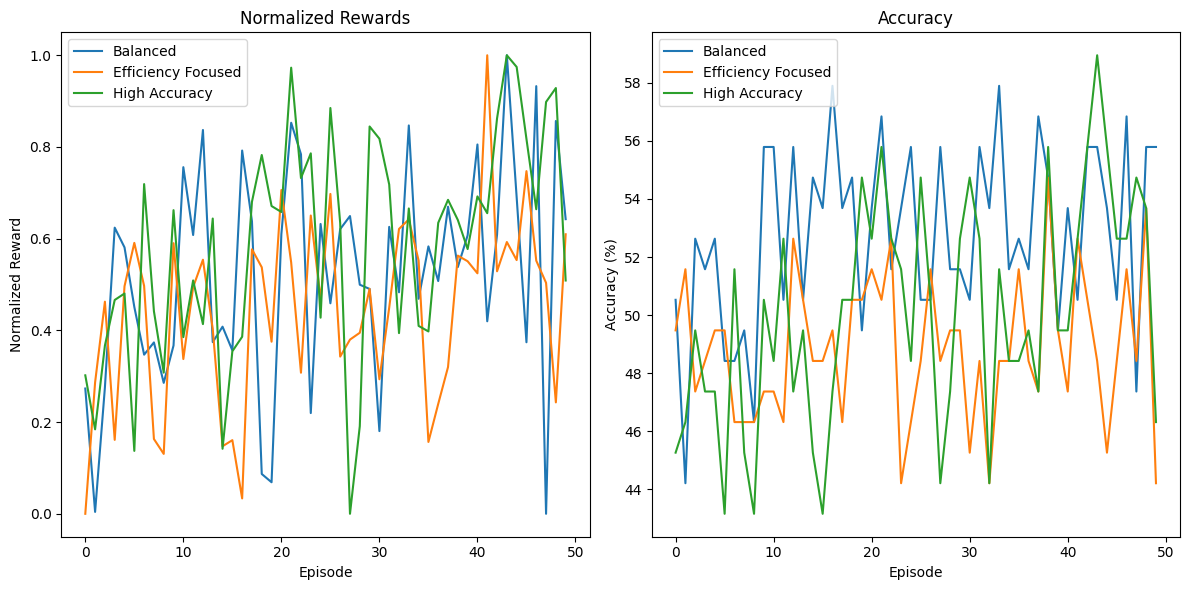

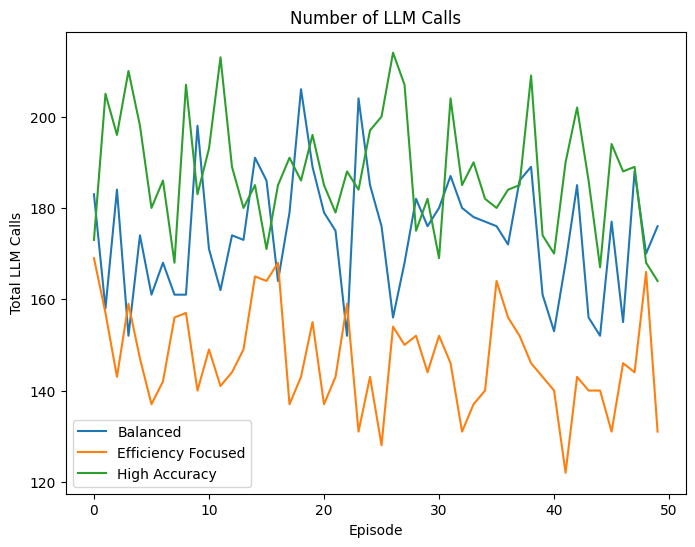

In [ ]:
import matplotlib.pyplot as plt

# Get rewards, accuracy and number of LLM calls for each configuration
balanced_rewards = accuracy_rewards_numcalls["Balanced"]["rewards"]
balanced_accuracy = accuracy_rewards_numcalls["Balanced"]["accuracy"]
balanced_num_calls = accuracy_rewards_numcalls["Balanced"]["num_calls"]

efficiency_rewards = accuracy_rewards_numcalls["Efficiency_Focused"]["rewards"]
efficiency_accuracy = accuracy_rewards_numcalls["Efficiency_Focused"]["accuracy"]
efficiency_num_calls = accuracy_rewards_numcalls["Efficiency_Focused"]["num_calls"]

high_accuracy_accuracy = accuracy_rewards_numcalls["High_Accuracy"]["accuracy"]
high_accuracy_rewards = accuracy_rewards_numcalls["High_Accuracy"]["rewards"]
high_accuracy_num_calls = accuracy_rewards_numcalls["High_Accuracy"]["num_calls"]

# min max scaling for rewards
balanced_rewards = (balanced_rewards - np.min(balanced_rewards)) / (np.max(balanced_rewards) - np.min(balanced_rewards))
efficiency_rewards = (efficiency_rewards - np.min(efficiency_rewards)) / (np.max(efficiency_rewards) - np.min(efficiency_rewards))
high_accuracy_rewards = (high_accuracy_rewards - np.min(high_accuracy_rewards)) / (np.max(high_accuracy_rewards) - np.min(high_accuracy_rewards))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(balanced_rewards, label="Balanced")
plt.plot(efficiency_rewards, label="Efficiency Focused")
plt.plot(high_accuracy_rewards, label="High Accuracy")
plt.title("Normalized Rewards")
plt.xlabel("Episode")
plt.ylabel("Normalized Reward")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(balanced_accuracy, label="Balanced")
plt.plot(efficiency_accuracy, label="Efficiency Focused")
plt.plot(high_accuracy_accuracy, label="High Accuracy")
plt.title("Accuracy")
plt.xlabel("Episode")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(balanced_num_calls, label="Balanced")
plt.plot(efficiency_num_calls, label="Efficiency Focused")
plt.plot(high_accuracy_num_calls, label="High Accuracy")
plt.title("Number of LLM Calls")
plt.xlabel("Episode")
plt.ylabel("Total LLM Calls")
plt.legend()
plt.show()

## Try it on test set data of hotpot qa 

In [ ]:
# Evaluate the agent on the test data
def evaluate_agent(agent, data):
    agent.q_network.eval()  # Set the model to evaluation mode
    correct_answers = 0
    total_parent_nodes = 0
    results = []
    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                state = get_state(node)
                action = agent.select_action(state, epsilon=0)  # No exploration during evaluation
                chosen_answer = None
                fallback_used = False  # Track if a fallback was used
                fallback_action = None

                # Simulate the action (choose answer based on action)
                if action == 0:  # CB
                    chosen_answer = node.get("cb_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to OB
                        chosen_answer = node.get("ob_answer", [None])[0]
                        fallback_action = 1
                        fallback_used = True
                elif action == 1:  # OB
                    chosen_answer = node.get("ob_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB
                        chosen_answer = node.get("cb_answer", [None])[0]
                        fallback_action = 0
                        fallback_used = True
                elif action == 2:  # Child
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                    for child_idx in node.get("sons", []):
                        child = example[child_idx]
                        child_state = get_state(child, depth=1)
                        child_action = agent.select_action(child_state, epsilon=0)  # Greedy policy
                        if child_action == 0:  # CB
                            child_answer = child.get("cb_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to OB
                                child_answer = child.get("ob_answer", [None])
                        elif child_action == 1:  # OB
                            child_answer = child.get("ob_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to CB
                                child_answer = child.get("cb_answer", [None])

                        tree_with_answers_chosen_by_agent[child_idx]["answer"] = child_answer

                    # Generate child_answer for the parent node
                    # print("tree_with_answers_chosen_by_agent", tree_with_answers_chosen_by_agent)
                    node["child_answer"], node["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                    chosen_answer = node["child_answer"][0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB or OB
                        chosen_answer = node.get("cb_answer", [None])[0]  # Try CB first
                        # fallback_used = True
                        if "unknown" in chosen_answer.lower().strip():
                            chosen_answer = node.get("ob_answer", [None])[0]  # Try OB next

                # Compute reward
                gold_answer, _ = q2gold[node["question_text"].strip()]
                # if chosen_answer and normalize_answer(chosen_answer) == normalize_answer(gold_answer):
                if chosen_answer and are_answers_equivalent_using_llm(chosen_answer, gold_answer):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": chosen_answer,
                    "gold": gold_answer,
                    "method": action_space[action] if not fallback_used else action_space[fallback_action]
                })

    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    return results, correct_answers, total_parent_nodes

import json
import torch

# Load test data
with open('results-testset-hotpotqa.json', 'r') as file:
    test_data = json.load(file)

# Load ground truth answers
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        print("ERROR CASE", e)

# List of trained models to evaluate
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"}
]

predictions_per_config = {}
correct_answers_per_config = {}
total_parent_nodes_per_config = {}
accuracy_per_config = {}

# Evaluate each model
for config in configurations:
    config_name = config["name"]
    model_path = f"saved_models_question_only_state/best_agent_{config_name}.pth"

    # Load the trained model
    agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)
    agent.q_network.load_state_dict(torch.load(model_path))
    agent.q_network.eval()  # Set model to evaluation mode

    print(f"\nEvaluating model: {config_name}")
    
    # Run evaluation
    rl_predictions, correct_answers, total_parent_nodes = evaluate_agent(agent, test_data)
    predictions_per_config[config_name] = rl_predictions
    correct_answers_per_config[config_name] = correct_answers
    total_parent_nodes_per_config[config_name] = total_parent_nodes

    # Print final accuracy
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    accuracy_per_config[config_name] = accuracy
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%\n")



Evaluating model: High_Accuracy
<!doctype html>
<html lang=en>
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>Error code: 429 - {&#39;id&#39;: &#39;nnhtaCA-3NKUce-926ffa625af70ad6&#39;, &#39;error&#39;: {&#39;message&#39;: &#39;You have reached the rate limit specific to this model meta-llama/Llama-3.3-70B-Instruct-Turbo-Free. The maximum rate limit for this model is 10.0 queries per minute. This limit differs from the general rate limits published at Together AI rate limits documentation (https://docs.together.ai/docs/rate-limits). For inquiries about increasing your model-specific rate limit, please contact our sales team (https://www.together.ai/forms/contact-sales)&#39;, &#39;type&#39;: &#39;model_rate_limit&#39;, &#39;param&#39;: None, &#39;code&#39;: None}}</p>

Evaluation Accuracy: 58.00%
Final Accuracy for High_Accuracy: 58.00%


Evaluating model: Balanced
Evaluation Accuracy: 54.00%
Final Accuracy for Balanced: 54.00%


Evaluating model: Efficiency

In [ ]:
# dict of config and each value is dict of method and count
methods_count_per_config = {}

# Print the results of the agent for each configuration
for config_name, rl_predictions in predictions_per_config.items():
    print(f"Results for {config_name}:")
    for result in rl_predictions:
        print(f"Node {result['idx']}:")
        print(f"  Question: {result['question']}")
        print(f"  Answer: {result['answer']}")
        print(f"  Gold Answer: {result['gold']}")
        print(f"  Method: {result['method']}")
        method = result['method']
        if config_name not in methods_count_per_config:
            methods_count_per_config[config_name] = {}
        if method not in methods_count_per_config[config_name]:
            methods_count_per_config[config_name][method] = 0
        methods_count_per_config[config_name][method] += 1
        print()


# Print the count of methods used by the agent for each configuration
for config_name, method_counts in methods_count_per_config.items():
    print(f"Method Counts for {config_name}:")
    for method, count in method_counts.items():
        print(f"  {method}: {count}")
    print()

Results for High_Accuracy:
Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: American.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: Bonnie Bramlett, Leon Russell, and Delaney Bramlett.
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: Child

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: Child

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Seoul, South Korea.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Que

In [ ]:
# Print the final accuracy for each configuration
for config_name, accuracy in accuracy_per_config.items():
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%")
    print(f"Total parent nodes: {total_parent_nodes_per_config[config_name]}")
    print(f"Times answer matches gold answer: {correct_answers_per_config[config_name]}")
    print()

Final Accuracy for High_Accuracy: 58.00%
Total parent nodes: 100
Times answer matches gold answer: 58

Final Accuracy for Balanced: 54.00%
Total parent nodes: 100
Times answer matches gold answer: 54

Final Accuracy for Efficiency_Focused: 59.00%
Total parent nodes: 100
Times answer matches gold answer: 59



In [ ]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: Child

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: Child

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Seoul, South Korea.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable film

In [ ]:
# compare between rl_predictions and probtree for each configuration
for config in configurations:
    config_name = config["name"]
    count = 0
    print(f"\nComparing results for {config_name} with the Probtree results:")
    for rl_pred, prob_tree_result in zip(predictions_per_config[config_name], results):
        if rl_pred['method'] == prob_tree_result['method'] or rl_pred['answer'] == prob_tree_result['answer']:
            continue
        count += 1
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
        print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
    print()
    print(f"Total mismatches: {count}")
    print("------------------------------------------------------------")



Comparing results for High_Accuracy with the Probtree results:
Question: Chun Woo-hee's notable films include a South Korean horror film about  a policeman who investigates a series of mysterious killings and what?
Gold Answer: illnesses
RL Prediction: illnesses., ProbTree Result: The Wailing.
RL Method: OB, ProbTree Method: CB
Question: What team had Tony Roberts replaced by an American sportscaster from Buffalo, New York when he retired?
Gold Answer: Notre Dame Fighting Irish football
RL Prediction: Buffalo Sabres., ProbTree Result: Notre Dame.
RL Method: CB, ProbTree Method: OB
Question: Are Catasetum and Origanum in the same family?
Gold Answer: no
RL Prediction: no., ProbTree Result: No.
RL Method: CB, ProbTree Method: OB
Question: In what city did the 1959 William & Mary Indians football team lose against the #13 Naval Academy?
Gold Answer: Annapolis, Maryland
RL Prediction: Annapolis., ProbTree Result: Annapolis, Maryland.
RL Method: OB, ProbTree Method: Child
Question: The 200

# RL Approach with deep learning (using Question + cb + ob)

In [ ]:
# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset-hotpotqa.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


def pad_or_truncate(logprobs, max_length=50, pad_value=-100):
    if len(logprobs) < max_length:
        # Pad with pad_value
        return logprobs + [pad_value] * (max_length - len(logprobs))
    else:
        # Truncate to max_length
        return logprobs[:max_length]

# # Define the reward function
# def get_reward(chosen_answer, gold_answer):
#     if normalize_answer(chosen_answer) == normalize_answer(gold_answer):
#         return 1
#     else:
#         return -1

from sentence_transformers import SentenceTransformer, util
# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
# def get_reward(chosen_answer, gold_answer):
#     # Compute embeddings for the chosen and gold answers
#     chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
#     gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
#     # Compute cosine similarity
#     similarity = util.cos_sim(chosen_embedding, gold_embedding).item()
#     return similarity  # Reward is the similarity score (between -1 and 1)

def get_reward(chosen_answer, gold_answer, action, num_llm_calls, alpha=1.0, beta=0.1):
    """
    Reward function with tradeoff between accuracy and efficiency.
    :param chosen_answer: Answer chosen by the agent.
    :param gold_answer: Ground truth answer.
    :param action: The action selected by the agent (0=CB, 1=OB, 2=Child).
    :param num_llm_calls: The number of LLM calls made during the current decision.
    :param alpha: Weight for accuracy reward.
    :param beta: Weight for efficiency penalty.
    :return: A reward value that balances accuracy and efficiency.
    """
    # Compute Accuracy Reward
    chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
    gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
    similarity = util.cos_sim(chosen_embedding, gold_embedding).item()  # Value between -1 (opposite) and 1 (exact match)
    accuracy_reward = (similarity + 1) / 2  # Normalize to range [0, 1]

    # Define LLM cost for each action
    ACTION_COSTS = {
        0: 1,  # CB cost
        1: 1,  # OB cost (higher than CB because of retrieval)
        2: 1,  # Child decomposition cost (higher due to multiple child evaluations)
    }

    # Compute Efficiency Penalty
    action_cost = ACTION_COSTS.get(action, 1)  # Default to 1 if action is unrecognized
    efficiency_penalty = num_llm_calls * action_cost  # Penalize based on LLM usage

    # Combine Accuracy and Efficiency
    reward = alpha * accuracy_reward - beta * efficiency_penalty

    return reward


def get_state(node, depth=0, max_length=50):
    # Extract raw features
    cb_logprob = node.get("cb_answer", [None, None, None, []])[3] or []
    ob_logprob = node.get("ob_answer", [None, None, None, []])[3] or []
    # child_logprob = node.get("child_answer", [None, None, None, []])[3] or []

    # Pad or truncate logprobs each is of length 50
    cb_logprob = pad_or_truncate(cb_logprob, max_length)
    ob_logprob = pad_or_truncate(ob_logprob, max_length)
    # child_logprob = pad_or_truncate(child_logprob, max_length)

    # Other features (7)
    has_children = 1 if len(node.get("sons", [])) else 0
    question_length = len(node.get("question_text", "").split())
    question_type = encode_question_type(node.get("question_text", ""))
    num_children = len(node.get("sons", []))
    cb_success_rate = get_success_rate("cb")
    ob_success_rate = get_success_rate("ob")
    child_success_rate = get_success_rate("child")

    # Semantic features
    # Each embedding is a 384-dimensional vector and they are total 3 = 1152
    question_text = node.get("question_text", "")
    question_embedding = model.encode(question_text, convert_to_tensor=False)
    cb_answer_embedding = model.encode(node.get("cb_answer", [""])[0], convert_to_tensor=False)
    ob_answer_embedding = model.encode(node.get("ob_answer", [""])[0], convert_to_tensor=False)
    # child_answer_embedding = model.encode(node.get("child_answer", [""])[0], convert_to_tensor=False)

    # Confidence and uncertainty (total 2)
    cb_confidence = node.get("cb_answer", [None, None, None, []])[1] or 0.0
    ob_confidence = node.get("ob_answer", [None, None, None, []])[1] or 0.0
    child_confidence = node.get("child_answer", [None, None, None, []])[1] or 0.0

    # Structural features (total 2)
    tree_depth = depth
    tree_position = 0 if depth == 0 else 1  # 0 for root, 1 for intermediate/leaf

    # Temporal features (example: sliding window of last 3 actions) 
    # action_history = node.get("action_history", [0, 0, 0])  # Placeholder for action history
    # action_success_history = node.get("action_success_history", [0, 0, 0])  # Placeholder for success history

    # External knowledge features
    # num_retrieved_documents = node.get("num_retrieved_documents", 0)
    # entity_linking_confidence = node.get("entity_linking_confidence", 0.0)

    # Answer quality (total 2)
    cb_answer_length = len(node.get("cb_answer", [""])[0].split())
    ob_answer_length = len(node.get("ob_answer", [""])[0].split())
    # child_answer_length = len(node.get("child_answer", [""])[0].split())

    # Build state vector
    state = (
        cb_logprob +  # CB log probabilities
        ob_logprob +  # OB log probabilities
        [has_children, question_length, question_type, num_children, cb_success_rate, ob_success_rate, child_success_rate] +  # Basic features
        list(question_embedding) +  # Semantic embedding of the question
        list(cb_answer_embedding) +  # Semantic embedding of the CB answer
        list(ob_answer_embedding) +  # Semantic embedding of the OB answer
        [cb_confidence, ob_confidence] +  # Confidence scores for CB and OB
        [tree_depth, tree_position] +  # Structural features
        [cb_answer_length, ob_answer_length]  # Answer quality features
    )

    # maybe try question only by masking all and add log probs for the solved one and try adding verification step in the end.

    return torch.FloatTensor(state)

class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3, gamma=0.99):
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.replay_buffer = []

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            if state[100] == 0: # has children = 0, because child is not possible
                return random.randint(0, len(action_space) - 2)
            else:
                return random.randint(0, len(action_space) - 1)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                if state[100] == 0: # has children = 0
                    q_values[-1] = -float('inf')
                return torch.argmax(q_values).item()

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        batch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.stack(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.stack(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q-values for current states
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # update the success rates
        for i, action in enumerate(actions):
            if rewards[i] == 1:
                update_success_rate(action_space[action], True)
            else:
                update_success_rate(action_space[action], False)

        # Compute loss and update the network
        loss = nn.MSELoss()(q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [ ]:
# state_dim = 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
# action_dim = len(action_space)  # Number of actions (CB, OB, Child)
# hidden_dim = 128  # Hidden layer size
# lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
# gamma = 0.99  # Discount factor
# epsilon = 1.0  # Initial exploration rate
# epsilon_min = 0.01  # Minimum exploration rate
# epsilon_decay = 0.98  # Decay rate for exploration
# batch_size = 128  # Mini-batch size
# num_episodes = 20  # Number of training episodes

# agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)

In [ ]:
import os
import torch
import copy

# Create directory for saved models
os.makedirs("saved_models", exist_ok=True)

# Define different configurations for alpha and beta
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"}
]

# Dictionary to store results
accuracy_rewards_numcalls = {}

# Loop through different settings
for config in configurations:
    alpha = config["alpha"]
    beta = config["beta"]
    config_name = config["name"]
    state_dim = 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
    action_dim = len(action_space)  # Number of actions (CB, OB, Child)
    hidden_dim = 128  # Hidden layer size
    lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
    gamma = 0.99  # Discount factor
    epsilon = 1.0  # Initial exploration rate
    epsilon_min = 0.01  # Minimum exploration rate
    epsilon_decay = 0.98  # Decay rate for exploration
    batch_size = 128  # Mini-batch size
    num_episodes = 20  # Number of training episodes

    agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)

    print(f"\nTraining with {config_name} (alpha={alpha}, beta={beta})")

    max_accuracy = 0
    best_agent = None

    # Store rewards, accuracy and total number of LLM calls for each episode
    rewards_list = []
    accuracy_list = []
    total_num_llm_calls_list = []

    # Set model to training mode
    agent.q_network.train()

    for episode in range(num_episodes):
        print(f"Episode {episode + 1}/{num_episodes}")
        total_reward = 0
        correct_answers = 0
        total_parent_nodes = 0
        total_num_llm_calls = 0

        for example in data:
            for node in example:
                if "fa" not in node:  # Only process parent nodes
                    total_parent_nodes += 1
                    state = get_state(node)  
                    action = agent.select_action(state, epsilon)  
                    chosen_answer = None
                    fallback_used = False  
                    num_llm_calls = None

                    # Simulate the action
                    if action == 0:
                        node['cb_answer'] = get_cb_answer(node["question_text"].strip())
                        chosen_answer = node.get("cb_answer", [None])
                        # chosen_answer = node.get("cb_answer", [None])
                        num_llm_calls = 1
                    elif action == 1:
                        # since you are the parent, so topic entities are empty because no references
                        node['ob_answer'] = get_singlehop_ob_answer(node["question_text"].strip(), [])
                        chosen_answer = node.get("ob_answer", [None])
                        num_llm_calls = 1
                    elif action == 2:
                        tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                        child_experiences = []

                        for node_ in tree_with_answers_chosen_by_agent:
                            question = node_["question_text"].strip()
                            ref_tokens = re.findall(r"<\d+>", question)
                            topic_entities = []
                            for ref_token in ref_tokens:
                                if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                    ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                    if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                        question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                        topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                            node_["question"] = question
                        
                            if len(node_["sons"]) == 0:
                                child_state = get_state(node_, depth=1)
                                child_action = agent.select_action(child_state, epsilon)
                                if child_action == 0:  
                                    node_["cb_answer"] = get_cb_answer(question)
                                    child_answer = node_.get("cb_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 1  
                                        node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                        child_answer = node_.get("ob_answer", [None])
                                elif child_action == 1:  
                                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 0  
                                        node_["cb_answer"] = get_cb_answer(question)
                                        child_answer = node_.get("cb_answer", [None])

                                node_["answer"] = child_answer
                                child_experiences.append((child_state, child_action, 0, child_state, False))  
                            else:
                                node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                                chosen_answer = node["child_answer"]
                        
                        num_llm_calls = len(child_experiences) + 1 + 1  # number of children + 1 (decomposition) + 1 (aggregation)

                    if "unknown" in chosen_answer[0].lower().strip():
                        fallback_used = True
                        if action == 0:  
                            fallback_action = 1
                            chosen_answer = node.get("ob_answer", [None])
                        elif action == 1:  
                            fallback_action = 0
                            chosen_answer = node.get("cb_answer", [None])
                        elif action == 2:  
                            fallback_action = 0
                            chosen_answer = node.get("cb_answer", [None])

                    # Compute reward
                    gold_answer, _ = q2gold[node["question_text"].strip()]
                    reward = get_reward(chosen_answer[0], gold_answer, action, num_llm_calls, alpha, beta)
                    total_reward += reward

                    # if normalize_answer(chosen_answer[0]) == normalize_answer(gold_answer):
                    if are_answers_equivalent_using_llm(gold_answer, chosen_answer[0]):
                        correct_answers += 1

                    next_state = get_state(node)

                    if not fallback_used:
                        agent.replay_buffer.append((state, action, reward, next_state, False))  
                    else:
                        agent.replay_buffer.append((state, fallback_action, reward, next_state, False))

                    if action == 2:
                        num_children = len(node.get("sons", []))
                        child_reward = reward / num_children  
                        for child_state, child_action, _, next_child_state, done in child_experiences:
                            agent.replay_buffer.append((child_state, child_action, reward, next_child_state, done))

                    # update total number of llm calls in this episode
                    total_num_llm_calls += num_llm_calls

                    agent.train(batch_size)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % 10 == 0:
            agent.update_target_network()

        accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
        rewards_list.append(total_reward)
        accuracy_list.append(accuracy)
        total_num_llm_calls_list.append(total_num_llm_calls)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_agent = copy.deepcopy(agent)

        print(f"Total Reward: {total_reward}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Total LLM Calls in this episode: {total_num_llm_calls}")
        print(f"Epsilon: {epsilon:.4f}")
        print()

    # Store the rewards and accuracy for this configuration
    accuracy_rewards_numcalls[config_name] = {
        "rewards": rewards_list,
        "accuracy": accuracy_list,
        "num_calls": total_num_llm_calls_list
    }

    # Save model after training with each configuration
    model_path = f"saved_models/agent_{config_name}.pth"
    torch.save(agent.q_network.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the best model overall
    if best_agent is not None:
        best_model_path = f"saved_models/best_agent_{config_name}.pth"
        torch.save(best_agent.q_network.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")



Training with High_Accuracy (alpha=2.0, beta=0.05)
Episode 1/20
tree before resampling [{'idx': 0, 'question_text': 'Into which river does Pack Creek run after it goes through the Spanish Valley?', 'sons': [], 'qd_logprob': None, 'fa': 2, 'question': 'Into which river does Pack Creek run after it goes through the Spanish Valley?', 'cb_answer': ['Duchesne River.', -0.08218458797636766, 'Pack Creek runs through the Spanish Valley and then flows into the Duchesne River. So the answer is: Duchesne River.', [-0.111816406, -1.4305115e-06, -0.12060547, -0.008605957, -0.008605957, -3.2186508e-05, -4.7683716e-07, -0.031982422, -0.25976562, -0.43359375, -1.1920929e-07, -0.00018310547, -0.421875, -2.8133392e-05, 0, -9.536743e-07, -4.1007996e-05, -0.03881836, -5.4836273e-06, 0, 0, 0, -0.0076293945, 0, 0, -0.0024871826, -0.000579834, -2.3841858e-06]], 'ob_answer': ['Colorado River.', -0.021078500010388176, 'Pack Creek flows through Spanish Valley north northwestward into Moab Valley toward its con

NameError: name 're' is not defined

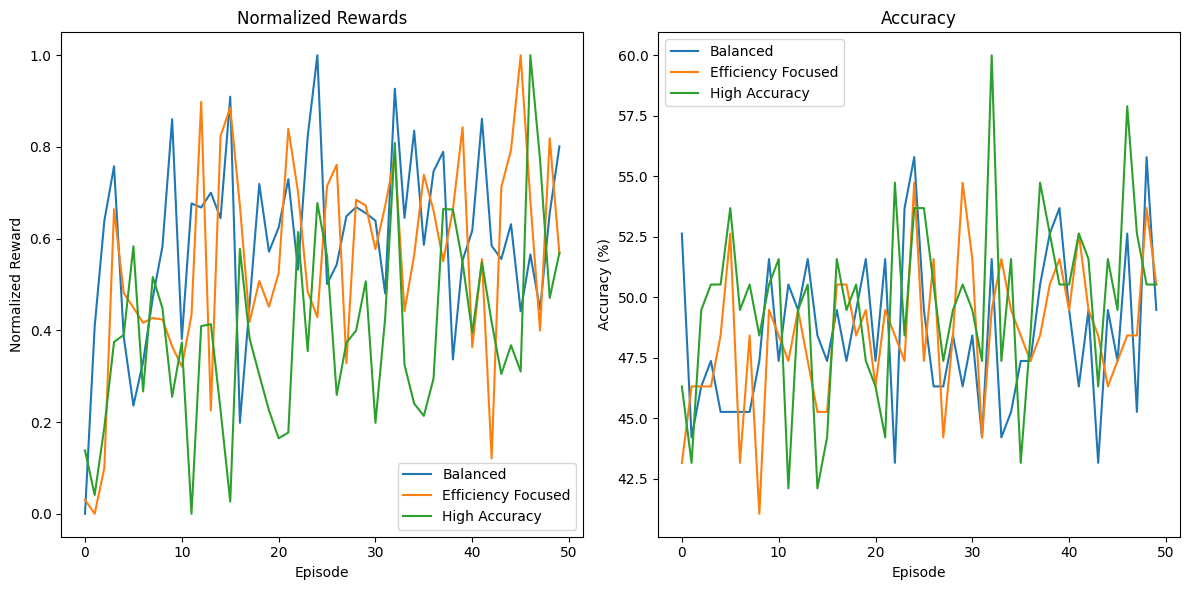

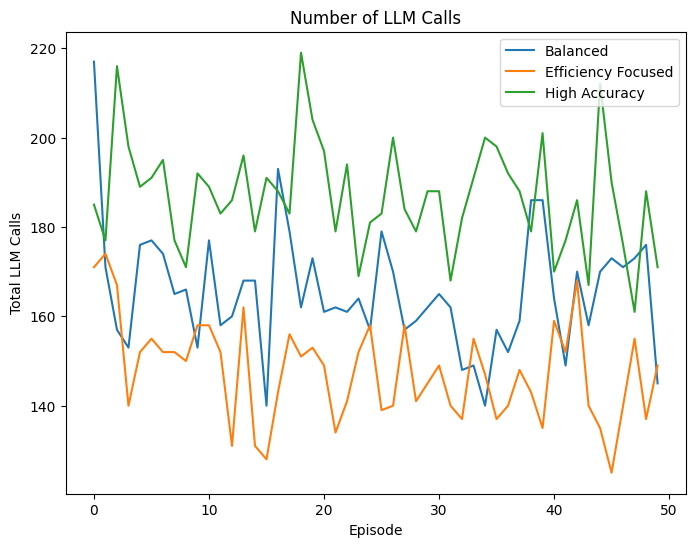

In [ ]:
import matplotlib.pyplot as plt

# Get rewards, accuracy and number of LLM calls for each configuration
balanced_rewards = accuracy_rewards_numcalls["Balanced"]["rewards"]
balanced_accuracy = accuracy_rewards_numcalls["Balanced"]["accuracy"]
balanced_num_calls = accuracy_rewards_numcalls["Balanced"]["num_calls"]

efficiency_rewards = accuracy_rewards_numcalls["Efficiency_Focused"]["rewards"]
efficiency_accuracy = accuracy_rewards_numcalls["Efficiency_Focused"]["accuracy"]
efficiency_num_calls = accuracy_rewards_numcalls["Efficiency_Focused"]["num_calls"]

high_accuracy_accuracy = accuracy_rewards_numcalls["High_Accuracy"]["accuracy"]
high_accuracy_rewards = accuracy_rewards_numcalls["High_Accuracy"]["rewards"]
high_accuracy_num_calls = accuracy_rewards_numcalls["High_Accuracy"]["num_calls"]

# min max scaling for rewards
balanced_rewards = (balanced_rewards - np.min(balanced_rewards)) / (np.max(balanced_rewards) - np.min(balanced_rewards))
efficiency_rewards = (efficiency_rewards - np.min(efficiency_rewards)) / (np.max(efficiency_rewards) - np.min(efficiency_rewards))
high_accuracy_rewards = (high_accuracy_rewards - np.min(high_accuracy_rewards)) / (np.max(high_accuracy_rewards) - np.min(high_accuracy_rewards))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(balanced_rewards, label="Balanced")
plt.plot(efficiency_rewards, label="Efficiency Focused")
plt.plot(high_accuracy_rewards, label="High Accuracy")
plt.title("Normalized Rewards")
plt.xlabel("Episode")
plt.ylabel("Normalized Reward")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(balanced_accuracy, label="Balanced")
plt.plot(efficiency_accuracy, label="Efficiency Focused")
plt.plot(high_accuracy_accuracy, label="High Accuracy")
plt.title("Accuracy")
plt.xlabel("Episode")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(balanced_num_calls, label="Balanced")
plt.plot(efficiency_num_calls, label="Efficiency Focused")
plt.plot(high_accuracy_num_calls, label="High Accuracy")
plt.title("Number of LLM Calls")
plt.xlabel("Episode")
plt.ylabel("Total LLM Calls")
plt.legend()
plt.show()

## Try it on test set data of hotpot qa 

In [ ]:
# Evaluate the agent on the test data
def evaluate_agent(agent, data):
    agent.q_network.eval()  # Set the model to evaluation mode
    correct_answers = 0
    total_parent_nodes = 0
    results = []
    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                state = get_state(node)
                action = agent.select_action(state, epsilon=0)  # No exploration during evaluation
                chosen_answer = None
                fallback_used = False  # Track if a fallback was used
                fallback_action = None

                # Simulate the action (choose answer based on action)
                if action == 0:  # CB
                    chosen_answer = node.get("cb_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to OB
                        chosen_answer = node.get("ob_answer", [None])[0]
                        fallback_action = 1
                        fallback_used = True
                elif action == 1:  # OB
                    chosen_answer = node.get("ob_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB
                        chosen_answer = node.get("cb_answer", [None])[0]
                        fallback_action = 0
                        fallback_used = True
                elif action == 2:  # Child
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                    for child_idx in node.get("sons", []):
                        child = example[child_idx]
                        child_state = get_state(child, depth=1)
                        child_action = agent.select_action(child_state, epsilon=0)  # Greedy policy
                        if child_action == 0:  # CB
                            child_answer = child.get("cb_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to OB
                                child_answer = child.get("ob_answer", [None])
                        elif child_action == 1:  # OB
                            child_answer = child.get("ob_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to CB
                                child_answer = child.get("cb_answer", [None])

                        tree_with_answers_chosen_by_agent[child_idx]["answer"] = child_answer

                    # Generate child_answer for the parent node
                    # print("tree_with_answers_chosen_by_agent", tree_with_answers_chosen_by_agent)
                    node["child_answer"], node["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                    chosen_answer = node["child_answer"][0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB or OB
                        chosen_answer = node.get("cb_answer", [None])[0]  # Try CB first
                        # fallback_used = True
                        if "unknown" in chosen_answer.lower().strip():
                            chosen_answer = node.get("ob_answer", [None])[0]  # Try OB next

                # Compute reward
                gold_answer, _ = q2gold[node["question_text"].strip()]
                # if chosen_answer and normalize_answer(chosen_answer) == normalize_answer(gold_answer):
                if chosen_answer and are_answers_equivalent_using_llm(chosen_answer, gold_answer):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": chosen_answer,
                    "gold": gold_answer,
                    "method": action_space[action] if not fallback_used else action_space[fallback_action]
                })

    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    return results, correct_answers, total_parent_nodes

import json
import torch

# Load test data
with open('results-testset-hotpotqa.json', 'r') as file:
    test_data = json.load(file)

# Load ground truth answers
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        print("ERROR CASE", e)

# List of trained models to evaluate
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"}
]

predictions_per_config = {}
correct_answers_per_config = {}
total_parent_nodes_per_config = {}
accuracy_per_config = {}

# Evaluate each model
for config in configurations:
    config_name = config["name"]
    model_path = f"saved_models/best_agent_{config_name}.pth"

    # Load the trained model
    agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)
    agent.q_network.load_state_dict(torch.load(model_path))
    agent.q_network.eval()  # Set model to evaluation mode

    print(f"\nEvaluating model: {config_name}")
    
    # Run evaluation
    rl_predictions, correct_answers, total_parent_nodes = evaluate_agent(agent, test_data)
    predictions_per_config[config_name] = rl_predictions
    correct_answers_per_config[config_name] = correct_answers
    total_parent_nodes_per_config[config_name] = total_parent_nodes

    # Print final accuracy
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    accuracy_per_config[config_name] = accuracy
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%\n")



Evaluating model: High_Accuracy
Evaluation Accuracy: 55.00%
Final Accuracy for High_Accuracy: 55.00%


Evaluating model: Balanced
Evaluation Accuracy: 53.00%
Final Accuracy for Balanced: 53.00%


Evaluating model: Efficiency_Focused
Evaluation Accuracy: 57.00%
Final Accuracy for Efficiency_Focused: 57.00%



In [ ]:
# dict of config and each value is dict of method and count
methods_count_per_config = {}

# Print the results of the agent for each configuration
for config_name, rl_predictions in predictions_per_config.items():
    print(f"Results for {config_name}:")
    for result in rl_predictions:
        print(f"Node {result['idx']}:")
        print(f"  Question: {result['question']}")
        print(f"  Answer: {result['answer']}")
        print(f"  Gold Answer: {result['gold']}")
        print(f"  Method: {result['method']}")
        method = result['method']
        if config_name not in methods_count_per_config:
            methods_count_per_config[config_name] = {}
        if method not in methods_count_per_config[config_name]:
            methods_count_per_config[config_name][method] = 0
        methods_count_per_config[config_name][method] += 1
        print()


# Print the count of methods used by the agent for each configuration
for config_name, method_counts in methods_count_per_config.items():
    print(f"Method Counts for {config_name}:")
    for method, count in method_counts.items():
        print(f"  {method}: {count}")
    print()

Results for High_Accuracy:
Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: American.
  Gold Answer: American
  Method: CB

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: Child

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: South Korea and the United States.
  Gold Answer: South Korea
  Method: CB

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question:

In [ ]:
# Print the final accuracy for each configuration
for config_name, accuracy in accuracy_per_config.items():
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%")
    print(f"Total parent nodes: {total_parent_nodes_per_config[config_name]}")
    print(f"Times answer matches gold answer: {correct_answers_per_config[config_name]}")
    print()

Final Accuracy for High_Accuracy: 55.00%
Total parent nodes: 100
Times answer matches gold answer: 55

Final Accuracy for Balanced: 53.00%
Total parent nodes: 100
Times answer matches gold answer: 53

Final Accuracy for Efficiency_Focused: 57.00%
Total parent nodes: 100
Times answer matches gold answer: 57



In [ ]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: Child

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable films include

In [ ]:
# compare between rl_predictions and probtree for each configuration
for config in configurations:
    config_name = config["name"]
    count = 0
    print(f"\nComparing results for {config_name} with the Probtree results:")
    for rl_pred, prob_tree_result in zip(predictions_per_config[config_name], results):
        if rl_pred['method'] == prob_tree_result['method'] or rl_pred['answer'] == prob_tree_result['answer']:
            continue
        count += 1
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
        print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
    print()
    print(f"Total mismatches: {count}")
    print("------------------------------------------------------------")



Comparing results for High_Accuracy with the Probtree results:
Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
Gold Answer: American
RL Prediction: American., ProbTree Result: United States.
RL Method: CB, ProbTree Method: Child
Question: Where was Nexon who was composed by Adam Gubman located at?
Gold Answer: South Korea
RL Prediction: South Korea and the United States., ProbTree Result: Tokyo, Japan.
RL Method: CB, ProbTree Method: Child
Question: Cooperative Living Organization is located in a city that is the county seat of what county in Florida?
Gold Answer: Alachua
RL Prediction: Orange County., ProbTree Result: Alachua County.
RL Method: CB, ProbTree Method: OB
Question: The 1978 NBA World Championship Series had as MVP which Hall of Fame class member of 1988?
Gold Answer: Westley Sissel Unseld
RL Prediction: Bill Walton., ProbTree Result: Wes Unseld.
RL Method: CB, ProbTree Method: Child

# RL Approach with deep learning (using Question + cb + ob + Reformulation of question)

In [ ]:
# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset-hotpotqa.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)


In [ ]:
action_space = ['CB', 'OB', 'Child', 'CB_REFORMULATE', 'OB_REFORMULATE', 'Child_REFORMULATE']
success_counts = {"cb": 0, "ob": 0, "child": 0, "cb_reformulate": 0, "ob_reformulate": 0, "child_reformulate": 0}
attempt_counts = {"cb": 0, "ob": 0, "child": 0, "cb_reformulate": 0, "ob_reformulate": 0, "child_reformulate": 0}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


def pad_or_truncate(logprobs, max_length=50, pad_value=-100):
    if len(logprobs) < max_length:
        # Pad with pad_value
        return logprobs + [pad_value] * (max_length - len(logprobs))
    else:
        # Truncate to max_length
        return logprobs[:max_length]

# # Define the reward function
# def get_reward(chosen_answer, gold_answer):
#     if normalize_answer(chosen_answer) == normalize_answer(gold_answer):
#         return 1
#     else:
#         return -1

from sentence_transformers import SentenceTransformer, util
# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
# def get_reward(chosen_answer, gold_answer):
#     # Compute embeddings for the chosen and gold answers
#     chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
#     gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
#     # Compute cosine similarity
#     similarity = util.cos_sim(chosen_embedding, gold_embedding).item()
#     return similarity  # Reward is the similarity score (between -1 and 1)

def get_reward(chosen_answer, gold_answer, action, num_llm_calls, alpha=1.0, beta=0.1):
    """
    Reward function with tradeoff between accuracy and efficiency.
    :param chosen_answer: Answer chosen by the agent.
    :param gold_answer: Ground truth answer.
    :param action: The action selected by the agent (0=CB, 1=OB, 2=Child).
    :param num_llm_calls: The number of LLM calls made during the current decision.
    :param alpha: Weight for accuracy reward.
    :param beta: Weight for efficiency penalty.
    :return: A reward value that balances accuracy and efficiency.
    """
    # Compute Accuracy Reward
    chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
    gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
    similarity = util.cos_sim(chosen_embedding, gold_embedding).item()  # Value between -1 (opposite) and 1 (exact match)
    accuracy_reward = max(0, similarity)  # Ensure rewards are non-negative

    # Define LLM cost for each action
    ACTION_COSTS = {
        0: 1,  # CB cost
        1: 1,  # OB cost (higher than CB because of retrieval)
        2: 1,  # Child decomposition cost (higher due to multiple child evaluations)
        3: 1,  # CB Reformulation cost
        4: 1,  # OB Reformulation cost
        5: 1   # Child Reformulation cost
    }

    # Compute Efficiency Penalty
    action_cost = ACTION_COSTS.get(action, 1)  # Default to 1 if action is unrecognized
    efficiency_penalty = num_llm_calls * action_cost  # Penalize based on LLM usage

    # Combine Accuracy and Efficiency
    reward = alpha * accuracy_reward - beta * efficiency_penalty

    return reward


def get_state(node, depth=0, max_length=50):
    # Extract raw features
    cb_logprob = node.get("cb_answer", [None, None, None, []])[3] or []
    ob_logprob = node.get("ob_answer", [None, None, None, []])[3] or []
    # child_logprob = node.get("child_answer", [None, None, None, []])[3] or []

    # Pad or truncate logprobs each is of length 50
    cb_logprob = pad_or_truncate(cb_logprob, max_length)
    ob_logprob = pad_or_truncate(ob_logprob, max_length)
    # child_logprob = pad_or_truncate(child_logprob, max_length)

    # Other features (7)
    has_children = 1 if len(node.get("sons", [])) else 0
    question_length = len(node.get("question_text", "").split())
    question_type = encode_question_type(node.get("question_text", ""))
    num_children = len(node.get("sons", []))
    cb_success_rate = get_success_rate("cb")
    ob_success_rate = get_success_rate("ob")
    child_success_rate = get_success_rate("child")

    # Semantic features
    # Each embedding is a 384-dimensional vector and they are total 3 = 1152
    question_text = node.get("question_text", "")
    question_embedding = model.encode(question_text, convert_to_tensor=False)
    cb_answer_embedding = model.encode(node.get("cb_answer", [""])[0], convert_to_tensor=False)
    ob_answer_embedding = model.encode(node.get("ob_answer", [""])[0], convert_to_tensor=False)
    # child_answer_embedding = model.encode(node.get("child_answer", [""])[0], convert_to_tensor=False)

    # Confidence and uncertainty (total 2)
    cb_confidence = node.get("cb_answer", [None, None, None, []])[1] or 0.0
    ob_confidence = node.get("ob_answer", [None, None, None, []])[1] or 0.0
    child_confidence = node.get("child_answer", [None, None, None, []])[1] or 0.0

    # Structural features (total 2)
    tree_depth = depth
    tree_position = 0 if depth == 0 else 1  # 0 for root, 1 for intermediate/leaf

    # Temporal features (example: sliding window of last 3 actions) 
    # action_history = node.get("action_history", [0, 0, 0])  # Placeholder for action history
    # action_success_history = node.get("action_success_history", [0, 0, 0])  # Placeholder for success history

    # External knowledge features
    # num_retrieved_documents = node.get("num_retrieved_documents", 0)
    # entity_linking_confidence = node.get("entity_linking_confidence", 0.0)

    # Answer quality (total 2)
    cb_answer_length = len(node.get("cb_answer", [""])[0].split())
    ob_answer_length = len(node.get("ob_answer", [""])[0].split())
    # child_answer_length = len(node.get("child_answer", [""])[0].split())

    # Build state vector
    state = (
        cb_logprob +  # CB log probabilities
        ob_logprob +  # OB log probabilities
        [has_children, question_length, question_type, num_children, cb_success_rate, ob_success_rate, child_success_rate] +  # Basic features
        list(question_embedding) +  # Semantic embedding of the question
        list(cb_answer_embedding) +  # Semantic embedding of the CB answer
        list(ob_answer_embedding) +  # Semantic embedding of the OB answer
        [cb_confidence, ob_confidence] +  # Confidence scores for CB and OB
        [tree_depth, tree_position] +  # Structural features
        [cb_answer_length, ob_answer_length]  # Answer quality features
    )

    # maybe try question only by masking all and add log probs for the solved one and try adding verification step in the end.

    return torch.FloatTensor(state)

class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3, gamma=0.99):
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.replay_buffer = []

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            if state[100] == 0:  # has children = 0, meaning child actions are not possible
                return random.choice([0, 1, 3, 4])  # Exclude actions 2 and 5
            else:
                return random.randint(0, 5)  # Choose from all 6 actions
        else:
            with torch.no_grad():
                q_values = self.q_network(state).clone()  # Clone to avoid in-place modification issues
                
                if state[100] == 0:  # has children = 0
                    q_values[2] = -float('inf')  # Mask action 2
                    q_values[5] = -float('inf')  # Mask action 5

                return torch.argmax(q_values).item()


    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        batch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.stack(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.stack(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q-values for current states
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # update the success rates
        for i, action in enumerate(actions):
            if rewards[i] == 1:
                update_success_rate(action_space[action], True)
            else:
                update_success_rate(action_space[action], False)

        # Compute loss and update the network
        loss = nn.MSELoss()(q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [ ]:
# state_dim = 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
# action_dim = len(action_space)  # Number of actions (CB, OB, Child)
# hidden_dim = 128  # Hidden layer size
# lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
# gamma = 0.99  # Discount factor
# epsilon = 1.0  # Initial exploration rate
# epsilon_min = 0.01  # Minimum exploration rate
# epsilon_decay = 0.98  # Decay rate for exploration
# batch_size = 128  # Mini-batch size
# num_episodes = 50  # Number of training episodes

# agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)

In [ ]:
def reformulate_question(question):
   """
   Reformulates a question using a language model based on pre-defined reformulation rules.
   :param question: The original question to reformulate.
   :return: Reformulated question text.
   """

   REFORMULATION_PROMPT = f"""
   Reformulate the question to improve readability, grammar, and clarity. Simplify complex phrasing and structure the question in a way that is easier to understand, without changing the core intent or meaning. Avoid adding or removing any information. Follow these steps:
   1. Simplify the question by removing unnecessary or overly complex wording.
   2. Fix grammar and punctuation issues to improve readability.
   3. Rewrite the question in a way that keeps the meaning identical but makes it easier to interpret.
   4. Return the result directly without any additional information.

   Examples:

   1. Original: "What are the possible reasons for the decline in monarch butterfly populations, and how does urbanization contribute to this issue?"
      Reformulated: "What causes the decline in monarch butterfly populations, and how does urbanization play a role?"

   2. Original: "How is social media influencing the mental health of teenagers, specifically with regard to anxiety and depression levels?"
      Reformulated: "How does social media affect teenagers' mental health, particularly with respect to anxiety and depression?"

   3. Original: "What is known about the origin of black holes and how do they affect the galaxies they exist in?"
      Reformulated: "What do we know about the origin of black holes, and how do they affect their galaxies?"

   4. Original: "Describe the ways in which renewable energy sources like solar and wind power are replacing fossil fuels in energy production."
      Reformulated: "How are renewable energy sources like solar and wind replacing fossil fuels in energy production?"

   Now, reformulate the question below:

   Original Question:
   {question}

   Reformulated Question:
   """
   
   # Format the prompt
   prompt = REFORMULATION_PROMPT.format(question=question)

   # Use LLM API to get the reformulated question
   response, tag = togetherai_caller.req2provider(prompt=prompt, max_tokens=None, stop= None, use_cache=True)
   response = response[0]
   return response['message']['content'].strip()

In [ ]:
import os
import torch
import copy

# Create directory for saved models
os.makedirs("saved_models", exist_ok=True)

# Define different configurations for alpha and beta
# configurations = [
#     {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
#     {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
#     {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"}
# ]
configurations = [
    {
        "hidden_dim": 128,
        "lr": 1e-3,
        "gamma": 0.99,
        "epsilon": 1.0,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.995,
        "batch_size": 128,
        "num_episodes": 100,
        "alpha": 5.0,
        "beta": 0.05,
        "name": "High_Accuracy_Priority"
    },
    {
        "hidden_dim": 128,
        "lr": 1e-3,
        "gamma": 0.99,
        "epsilon": 1.0,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.995,
        "batch_size": 128,
        "num_episodes": 200,
        "alpha": 1.0,
        "beta": 0.1,
        "name": "Balanced_Reward_Tradeoff"
    },
    {
        "hidden_dim": 128,
        "lr": 5e-4,
        "gamma": 0.99,
        "epsilon": 1.0,
        "epsilon_min": 0.1,
        "epsilon_decay": 0.990,
        "batch_size": 64,
        "num_episodes": 150,
        "alpha": 0.5,
        "beta": 2.0,
        "name": "Efficiency_Focused"
    },
    {
        "hidden_dim": 64,
        "lr": 1e-3,
        "gamma": 0.95,
        "epsilon": 1.0,
        "epsilon_min": 0.1,
        "epsilon_decay": 0.98,
        "batch_size": 128,
        "num_episodes": 100,
        "alpha": 2.0,
        "beta": 0.1,
        "name": "Exploration_Focused"
    }
]

# Dictionary to store results
accuracy_rewards_numcalls = {}

# Loop through different settings
for config in configurations:
    alpha = config["alpha"]
    beta = config["beta"]
    
    epsilon = config["epsilon"]
    epsilon_min = config["epsilon_min"]
    epsilon_decay = config["epsilon_decay"]
    batch_size = config["batch_size"]
    num_episodes = config["num_episodes"]
    lr = config["lr"]
    gamma = config["gamma"]
    hidden_dim = config["hidden_dim"]

    config_name = config["name"]
    agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)

    print(f"\nTraining with {config_name} (alpha={alpha}, beta={beta})")

    max_accuracy = 0
    best_agent = None

    # Store rewards, accuracy and total number of LLM calls for each episode
    rewards_list = []
    accuracy_list = []
    total_num_llm_calls_list = []

    # Set model to training mode
    agent.q_network.train()

    for episode in range(num_episodes):
        print(f"Episode {episode + 1}/{num_episodes}")
        total_reward = 0
        correct_answers = 0
        total_parent_nodes = 0
        total_num_llm_calls = 0

        for example in data:
            for node in example:
                if "fa" not in node:  # Only process parent nodes
                    total_parent_nodes += 1
                    state = get_state(node)  
                    action = agent.select_action(state, epsilon)  
                    chosen_answer = None
                    fallback_used = False  
                    num_llm_calls = None

                    # Simulate the action
                    if action == 0:
                        chosen_answer = node.get("cb_answer", [None])
                        num_llm_calls = 1
                    elif action == 1:  
                        chosen_answer = node.get("ob_answer", [None])
                        num_llm_calls = 1
                    elif action == 2:  
                        tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                        child_experiences = []

                        for node_ in tree_with_answers_chosen_by_agent:
                            question = node_["question_text"].strip()
                            ref_tokens = re.findall(r"<\d+>", question)
                            topic_entities = []
                            for ref_token in ref_tokens:
                                if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                    ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                    if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                        question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                        topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                            node_["question"] = question
                        
                            if len(node_["sons"]) == 0:
                                child_state = get_state(node_, depth=1)
                                child_action = agent.select_action(child_state, epsilon)
                                if child_action == 0:  
                                    node_["cb_answer"] = get_cb_answer(question)
                                    child_answer = node_.get("cb_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 1  
                                        node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                        child_answer = node_.get("ob_answer", [None])
                                elif child_action == 1:  
                                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 0  
                                        node_["cb_answer"] = get_cb_answer(question)
                                        child_answer = node_.get("cb_answer", [None])
                                elif child_action == 3:
                                    # CB with reformulation
                                    reformulated_question = reformulate_question(question)
                                    node_["cb_answer"] = get_cb_answer(reformulated_question)
                                    child_answer = node_.get("cb_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 4
                                        node_["ob_answer"] = get_singlehop_ob_answer(reformulated_question, topic_entities)
                                        child_answer = node_.get("ob_answer", [None])
                                        # num_llm_calls += 1 # for fallback
                                elif child_action == 4:
                                    # OB with reformulation
                                    reformulated_question = reformulate_question(question)
                                    node_["ob_answer"] = get_singlehop_ob_answer(reformulated_question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 3
                                        node_["cb_answer"] = get_cb_answer(reformulated_question)
                                        child_answer = node_.get("cb_answer", [None])
                                        # num_llm_calls += 1 # for fallback
                                else:
                                    # Throw exception
                                    raise ValueError("Invalid action selected for child node : " + action_space[child_action])

                                node_["answer"] = child_answer
                                child_experiences.append((child_state, child_action, 0, child_state, False))  
                            else:
                                # If the node has children, aggregate the answers
                                node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node_, tree_with_answers_chosen_by_agent)
                                chosen_answer = node_["child_answer"]
                        
                        num_llm_calls = len(child_experiences) + 1 + 1  # number of children + 1 (decomposition) + 1 (aggregation) 
                        # TODO i am not counting fallbacks here in the children
                    elif action == 3:
                        # CB with reformulation
                        question = node.get("question_text", "").strip()
                        reformulated_question = reformulate_question(question)
                        chosen_answer = get_cb_answer(reformulated_question)
                        num_llm_calls = 2  # 1 for reformulation, 1 for CB
                    
                    elif action == 4:
                        # OB with reformulation
                        question = node.get("question_text", "").strip()
                        reformulated_question = reformulate_question(question)
                        tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                        for node_ in tree_with_answers_chosen_by_agent:
                            question = node_["question_text"].strip()
                            ref_tokens = re.findall(r"<\d+>", question)
                            topic_entities = []
                            for ref_token in ref_tokens:
                                if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                    ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                    if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                        question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                        topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                            node_["question"] = question
                        chosen_answer = get_singlehop_ob_answer(reformulated_question, topic_entities)
                        num_llm_calls = 2  # 1 for reformulation, 1 for OB
                    
                    elif action == 5:
                        # Child with reformulation
                        tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                        child_experiences = []
                        num_llm_calls = 0

                        for node_ in tree_with_answers_chosen_by_agent:
                            question = node_["question_text"].strip()
                            ref_tokens = re.findall(r"<\d+>", question)
                            topic_entities = []
                            for ref_token in ref_tokens:
                                if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                    ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                    if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                        question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                        topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                            node_["question"] = question

                            if len(node_["sons"]) == 0:
                                child_state = get_state(node_, depth=1)
                                child_action = agent.select_action(child_state, epsilon)
                                # num_llm_calls += 1 # for solving the child
                                if child_action == 0:  
                                    node_["cb_answer"] = get_cb_answer(question)
                                    child_answer = node_.get("cb_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 1  
                                        node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                        child_answer = node_.get("ob_answer", [None])
                                        # num_llm_calls += 1 # for fallback
                                elif child_action == 1:  
                                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 0  
                                        node_["cb_answer"] = get_cb_answer(question)
                                        child_answer = node_.get("cb_answer", [None])
                                        # num_llm_calls += 1 # for fallback
                                elif child_action == 3:
                                    # CB with reformulation
                                    reformulated_question = reformulate_question(question)
                                    node_["cb_answer"] = get_cb_answer(reformulated_question)
                                    child_answer = node_.get("cb_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 4
                                        node_["ob_answer"] = get_singlehop_ob_answer(reformulated_question, topic_entities)
                                        child_answer = node_.get("ob_answer", [None])
                                        # num_llm_calls += 1 # for fallback
                                elif child_action == 4:
                                    # OB with reformulation
                                    reformulated_question = reformulate_question(question)
                                    node_["ob_answer"] = get_singlehop_ob_answer(reformulated_question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 3
                                        node_["cb_answer"] = get_cb_answer(reformulated_question)
                                        child_answer = node_.get("cb_answer", [None])
                                        # num_llm_calls += 1 # for fallback
                                else:
                                    # throw error
                                    raise Exception('Wrong action decided for the children ?? ') # Don't! If you catch, likely to hide bugs.


                                node_["answer"] = child_answer
                                child_experiences.append((child_state, child_action, 0, child_state, False))  
                            else:
                                node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node_, tree_with_answers_chosen_by_agent)
                                chosen_answer = node_["child_answer"]
                        
                        num_llm_calls = len(child_experiences) + 1 + 1  # 1 (decomposition) + 1 (aggregation)                        

                    if "unknown" in chosen_answer[0].lower().strip():
                        # num_llm_calls += 1  # Fallback to CB or OB
                        fallback_used = True
                        if action == 0 or action == 3:  
                            fallback_action = 1
                            chosen_answer = node.get("ob_answer", [None])
                        elif action == 1 or action == 4:  
                            fallback_action = 0
                            chosen_answer = node.get("cb_answer", [None])
                        elif action == 2 or action == 5:  
                            fallback_action = 0
                            chosen_answer = node.get("cb_answer", [None])

                    # Compute reward
                    gold_answer, _ = q2gold[node["question_text"].strip()]
                    reward = get_reward(chosen_answer[0], gold_answer, action, num_llm_calls, alpha, beta)
                    total_reward += reward

                    # if normalize_answer(chosen_answer[0]) == normalize_answer(gold_answer):
                    if are_answers_equivalent_using_llm(gold_answer, chosen_answer[0]):
                        correct_answers += 1

                    next_state = get_state(node)

                    if not fallback_used:
                        agent.replay_buffer.append((state, action, reward, next_state, False))  
                    else:
                        agent.replay_buffer.append((state, fallback_action, reward, next_state, False))

                    if action == 2 or action == 5:
                        num_children = len(node.get("sons", []))
                        child_reward = reward / num_children  
                        for child_state, child_action, _, next_child_state, done in child_experiences:
                            agent.replay_buffer.append((child_state, child_action, reward, next_child_state, done))

                    # update total number of llm calls in this episode
                    total_num_llm_calls += num_llm_calls

                    agent.train(batch_size)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % 10 == 0:
            agent.update_target_network()

        accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
        rewards_list.append(total_reward)
        accuracy_list.append(accuracy)
        total_num_llm_calls_list.append(total_num_llm_calls)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_agent = copy.deepcopy(agent)

        print(f"Total Reward: {total_reward}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Total LLM Calls in this episode: {total_num_llm_calls}")
        print(f"Epsilon: {epsilon:.4f}")
        print()

    # Store the rewards and accuracy for this configuration
    accuracy_rewards_numcalls[config_name] = {
        "rewards": rewards_list,
        "accuracy": accuracy_list,
        "num_calls": total_num_llm_calls_list
    }

    # Save model after training with each configuration
    model_path = f"saved_models/agent_{config_name}.pth"
    torch.save(agent.q_network.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the best model overall
    if best_agent is not None:
        best_model_path = f"saved_models/best_agent_{config_name}.pth"
        torch.save(best_agent.q_network.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")



Training with High_Accuracy_Priority (alpha=5.0, beta=0.05)
Episode 1/100
Total Reward: 285.17240444570774
Accuracy: 43.16%
Total LLM Calls in this episode: 205
Epsilon: 0.9950

Episode 2/100
Total Reward: 293.58250423967837
Accuracy: 43.16%
Total LLM Calls in this episode: 211
Epsilon: 0.9900

Episode 3/100
Total Reward: 306.8192158728838
Accuracy: 48.42%
Total LLM Calls in this episode: 192
Epsilon: 0.9851

Episode 4/100
Total Reward: 288.39613798856726
Accuracy: 40.00%
Total LLM Calls in this episode: 218
Epsilon: 0.9801

Episode 5/100
Total Reward: 294.09449751526114
Accuracy: 47.37%
Total LLM Calls in this episode: 233
Epsilon: 0.9752

Episode 6/100
Total Reward: 297.09374780058863
Accuracy: 42.11%
Total LLM Calls in this episode: 223
Epsilon: 0.9704

Episode 7/100
Total Reward: 289.64053623378277
Accuracy: 42.11%
Total LLM Calls in this episode: 225
Epsilon: 0.9655

Episode 8/100
Total Reward: 277.0611959189177
Accuracy: 36.84%
Total LLM Calls in this episode: 212
Epsilon: 0.960

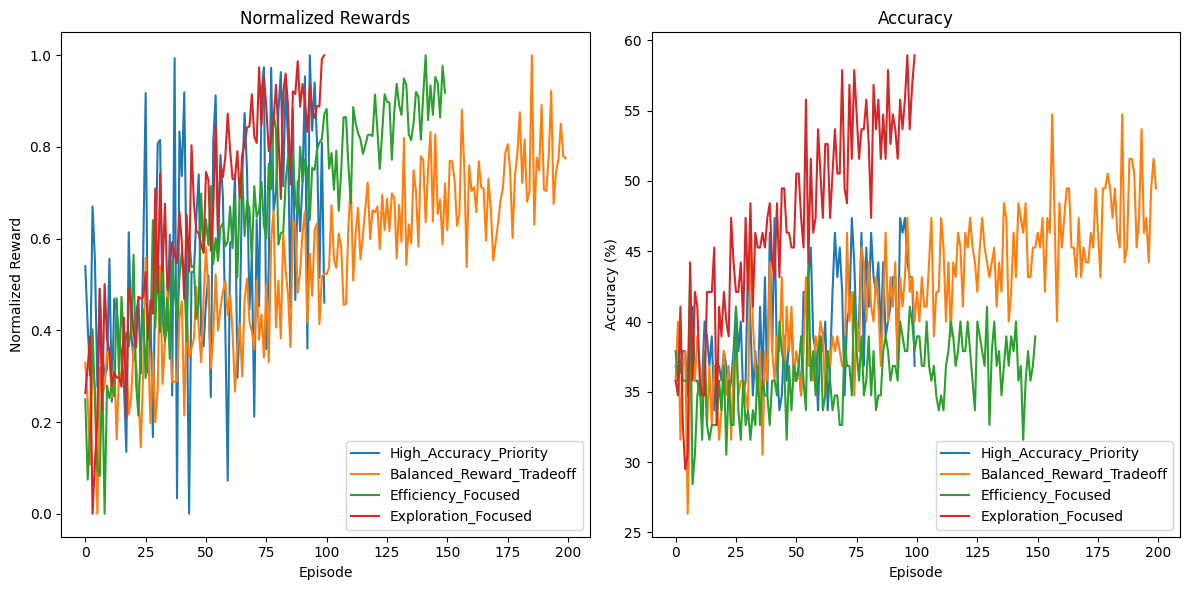

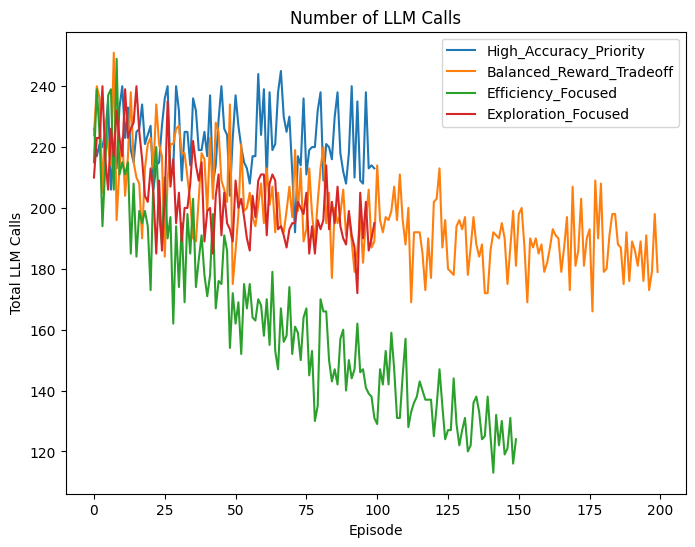

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Dynamically extract data for each configuration
config_names = list(accuracy_rewards_numcalls.keys())
normalized_rewards = {}
accuracies = {}
num_calls = {}

for config_name in config_names:
    rewards = np.array(accuracy_rewards_numcalls[config_name]["rewards"])
    accuracy = accuracy_rewards_numcalls[config_name]["accuracy"]
    calls = accuracy_rewards_numcalls[config_name]["num_calls"]

    # Normalize rewards
    normalized_rewards[config_name] = (rewards - np.min(rewards)) / (np.max(rewards) - np.min(rewards))
    accuracies[config_name] = accuracy
    num_calls[config_name] = calls

# Plotting normalized rewards
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for config_name in config_names:
    plt.plot(normalized_rewards[config_name], label=config_name)
plt.title("Normalized Rewards")
plt.xlabel("Episode")
plt.ylabel("Normalized Reward")
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
for config_name in config_names:
    plt.plot(accuracies[config_name], label=config_name)
plt.title("Accuracy")
plt.xlabel("Episode")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting number of LLM calls
plt.figure(figsize=(8, 6))
for config_name in config_names:
    plt.plot(num_calls[config_name], label=config_name)
plt.title("Number of LLM Calls")
plt.xlabel("Episode")
plt.ylabel("Total LLM Calls")
plt.legend()
plt.show()


## Try it on test set data of hotpot qa 

In [ ]:
# Evaluate the agent on the test data
def evaluate_agent(agent, data):
    agent.q_network.eval()  # Set the model to evaluation mode
    correct_answers = 0
    total_parent_nodes = 0
    results = []
    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                state = get_state(node)
                action = agent.select_action(state, epsilon=0)  # No exploration during evaluation
                chosen_answer = None
                fallback_used = False  # Track if a fallback was used
                fallback_action = None

                # Simulate the action
                if action == 0:  
                    chosen_answer = node.get("cb_answer", [None])
                elif action == 1:  
                    chosen_answer = node.get("ob_answer", [None])
                elif action == 2:  
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)

                    for node_ in tree_with_answers_chosen_by_agent:
                        question = node_["question_text"].strip()
                        ref_tokens = re.findall(r"<\d+>", question)
                        topic_entities = []
                        for ref_token in ref_tokens:
                            if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                    question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                    topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                        node_["question"] = question
                    
                        if len(node_["sons"]) == 0:
                            child_state = get_state(node_, depth=1)
                            child_action = agent.select_action(child_state, epsilon)
                            if child_action == 0:  
                                node_["cb_answer"] = get_cb_answer(question)
                                child_answer = node_.get("cb_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():
                                    child_action = 1  
                                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                            elif child_action == 1:  
                                node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                child_answer = node_.get("ob_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():
                                    child_action = 0  
                                    node_["cb_answer"] = get_cb_answer(question)
                                    child_answer = node_.get("cb_answer", [None])
                            elif child_action == 3:
                                # CB with reformulation
                                reformulated_question = reformulate_question(question)
                                node_["cb_answer"] = get_cb_answer(reformulated_question)
                                child_answer = node_.get("cb_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():
                                    child_action = 4
                                    node_["ob_answer"] = get_singlehop_ob_answer(reformulated_question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                            elif child_action == 4:
                                # OB with reformulation
                                reformulated_question = reformulate_question(question)
                                node_["ob_answer"] = get_singlehop_ob_answer(reformulated_question, topic_entities)
                                child_answer = node_.get("ob_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():
                                    child_action = 3
                                    node_["cb_answer"] = get_cb_answer(reformulated_question)
                                    child_answer = node_.get("cb_answer", [None])
                            else:
                                # Throw exception
                                raise ValueError("Invalid action selected for child node : " + action_space[child_action])

                            node_["answer"] = child_answer
                        else:
                            # If the node has children, aggregate the answers
                            node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node_, tree_with_answers_chosen_by_agent)
                            chosen_answer = node_["child_answer"]
                    
                    # TODO i am not counting fallbacks here in the children
                elif action == 3:
                    # CB with reformulation
                    question = node.get("question_text", "").strip()
                    reformulated_question = reformulate_question(question)
                    chosen_answer = get_cb_answer(reformulated_question)
                
                elif action == 4:
                    # OB with reformulation
                    question = node.get("question_text", "").strip()
                    reformulated_question = reformulate_question(question)
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                    for node_ in tree_with_answers_chosen_by_agent:
                        question = node_["question_text"].strip()
                        ref_tokens = re.findall(r"<\d+>", question)
                        topic_entities = []
                        for ref_token in ref_tokens:
                            if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                    question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                    topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                        node_["question"] = question
                    chosen_answer = get_singlehop_ob_answer(reformulated_question, topic_entities)
                
                elif action == 5:
                    # Child with reformulation
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)

                    for node_ in tree_with_answers_chosen_by_agent:
                        question = node_["question_text"].strip()
                        ref_tokens = re.findall(r"<\d+>", question)
                        topic_entities = []
                        for ref_token in ref_tokens:
                            if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                    question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                    topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                        node_["question"] = question

                        if len(node_["sons"]) == 0:
                            child_state = get_state(node_, depth=1)
                            child_action = agent.select_action(child_state, epsilon)
                            if child_action == 0:  
                                node_["cb_answer"] = get_cb_answer(question)
                                child_answer = node_.get("cb_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():
                                    child_action = 1  
                                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                            elif child_action == 1:  
                                node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                child_answer = node_.get("ob_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():
                                    child_action = 0  
                                    node_["cb_answer"] = get_cb_answer(question)
                                    child_answer = node_.get("cb_answer", [None])
                            elif child_action == 3:
                                # CB with reformulation
                                reformulated_question = reformulate_question(question)
                                node_["cb_answer"] = get_cb_answer(reformulated_question)
                                child_answer = node_.get("cb_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():
                                    child_action = 4
                                    node_["ob_answer"] = get_singlehop_ob_answer(reformulated_question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                            elif child_action == 4:
                                # OB with reformulation
                                reformulated_question = reformulate_question(question)
                                node_["ob_answer"] = get_singlehop_ob_answer(reformulated_question, topic_entities)
                                child_answer = node_.get("ob_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():
                                    child_action = 3
                                    node_["cb_answer"] = get_cb_answer(reformulated_question)
                                    child_answer = node_.get("cb_answer", [None])
                            else:
                                # throw error
                                raise Exception('Wrong action decided for the children ?? ') # Don't! If you catch, likely to hide bugs.

                            node_["answer"] = child_answer
                        else:
                            node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node_, tree_with_answers_chosen_by_agent)
                            chosen_answer = node_["child_answer"]
                    

                if "unknown" in chosen_answer[0].lower().strip():
                    fallback_used = True
                    if action == 0 or action == 3:
                        fallback_action = 1
                        chosen_answer = node.get("ob_answer", [None])
                    elif action == 1 or action == 4:
                        fallback_action = 0
                        chosen_answer = node.get("cb_answer", [None])
                    elif action == 2 or action == 5:  
                        fallback_action = 0
                        chosen_answer = node.get("cb_answer", [None])

                # Compute reward
                gold_answer, _ = q2gold[node["question_text"].strip()]
                # if chosen_answer and normalize_answer(chosen_answer[0]) == normalize_answer(gold_answer):
                if chosen_answer and are_answers_equivalent_using_llm(gold_answer, chosen_answer[0]):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": chosen_answer[0],
                    "gold": gold_answer,
                    "method": action_space[action] if not fallback_used else action_space[fallback_action]
                })

    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    return results, correct_answers, total_parent_nodes

import json
import torch

# Load test data
with open('results-testset-hotpotqa.json', 'r') as file:
    test_data = json.load(file)

# Load ground truth answers
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        print("ERROR CASE", e)


predictions_per_config = {}
correct_answers_per_config = {}
total_parent_nodes_per_config = {}
accuracy_per_config = {}

# Evaluate each model
for config in configurations:
    
    epsilon = config["epsilon"]
    epsilon_min = config["epsilon_min"]
    epsilon_decay = config["epsilon_decay"]
    batch_size = config["batch_size"]
    num_episodes = config["num_episodes"]
    lr = config["lr"]
    gamma = config["gamma"]
    hidden_dim = config["hidden_dim"]

    config_name = config["name"]
    # model_path = f"saved_models/best_agent_{config_name}.pth"

    model_path = f"saved_models/agent_{config_name}.pth"


    print(f"\nEvaluating model: {config_name}, hidden_dim={hidden_dim}, lr={lr}, gamma={gamma}")
    # Load the trained model
    best_agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)
    best_agent.q_network.load_state_dict(torch.load(model_path))
    best_agent.q_network.eval()  # Set model to evaluation mode

    
    # Run evaluation
    rl_predictions, correct_answers, total_parent_nodes = evaluate_agent(best_agent, test_data)
    predictions_per_config[config_name] = rl_predictions
    correct_answers_per_config[config_name] = correct_answers
    total_parent_nodes_per_config[config_name] = total_parent_nodes

    # Print final accuracy
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    accuracy_per_config[config_name] = accuracy
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%\n")



Evaluating model: High_Accuracy_Priority, hidden_dim=128, lr=0.001, gamma=0.99
Evaluation Accuracy: 44.00%
Final Accuracy for High_Accuracy_Priority: 44.00%


Evaluating model: Balanced_Reward_Tradeoff, hidden_dim=128, lr=0.001, gamma=0.99
Evaluation Accuracy: 42.00%
Final Accuracy for Balanced_Reward_Tradeoff: 42.00%


Evaluating model: Efficiency_Focused, hidden_dim=128, lr=0.0005, gamma=0.99
Evaluation Accuracy: 50.00%
Final Accuracy for Efficiency_Focused: 50.00%


Evaluating model: Exploration_Focused, hidden_dim=64, lr=0.001, gamma=0.95
Evaluation Accuracy: 40.00%
Final Accuracy for Exploration_Focused: 40.00%



In [ ]:
# dict of config and each value is dict of method and count
methods_count_per_config = {}

# Print the results of the agent for each configuration
for config_name, rl_predictions in predictions_per_config.items():
    print(f"Results for {config_name}:")
    for result in rl_predictions:
        print(f"Node {result['idx']}:")
        print(f"  Question: {result['question']}")
        print(f"  Answer: {result['answer']}")
        print(f"  Gold Answer: {result['gold']}")
        print(f"  Method: {result['method']}")
        method = result['method']
        if config_name not in methods_count_per_config:
            methods_count_per_config[config_name] = {}
        if method not in methods_count_per_config[config_name]:
            methods_count_per_config[config_name][method] = 0
        methods_count_per_config[config_name][method] += 1
        print()


# Print the count of methods used by the agent for each configuration
for config_name, method_counts in methods_count_per_config.items():
    print(f"Method Counts for {config_name}:")
    for method, count in method_counts.items():
        print(f"  {method}: {count}")
    print()

Results for High_Accuracy_Priority:
Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: American.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: South Korea and the United States.
  Gold Answer: South Korea
  Method: CB

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  

In [ ]:
# Print the final accuracy for each configuration
for config_name, accuracy in accuracy_per_config.items():
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%")
    print(f"Total parent nodes: {total_parent_nodes_per_config[config_name]}")
    print(f"Times answer matches gold answer: {correct_answers_per_config[config_name]}")
    print()

Final Accuracy for High_Accuracy_Priority: 44.00%
Total parent nodes: 100
Times answer matches gold answer: 44

Final Accuracy for Balanced_Reward_Tradeoff: 42.00%
Total parent nodes: 100
Times answer matches gold answer: 42

Final Accuracy for Efficiency_Focused: 50.00%
Total parent nodes: 100
Times answer matches gold answer: 50

Final Accuracy for Exploration_Focused: 40.00%
Total parent nodes: 100
Times answer matches gold answer: 40



In [ ]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable films include a 

In [ ]:
# compare between rl_predictions and probtree for each configuration
for config in configurations:
    config_name = config["name"]
    count = 0
    print(f"\nComparing results for {config_name} with the Probtree results:")
    for rl_pred, prob_tree_result in zip(predictions_per_config[config_name], results):
        if rl_pred['method'] == prob_tree_result['method'] or rl_pred['answer'] == prob_tree_result['answer']:
            continue
        count += 1
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
        print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
    print()
    print(f"Total mismatches: {count}")
    print("------------------------------------------------------------")



Comparing results for High_Accuracy_Priority with the Probtree results:
Question: Where was Nexon who was composed by Adam Gubman located at?
Gold Answer: South Korea
RL Prediction: South Korea and the United States., ProbTree Result: Tokyo, Japan.
RL Method: CB, ProbTree Method: Child
Question: Chun Woo-hee's notable films include a South Korean horror film about  a policeman who investigates a series of mysterious killings and what?
Gold Answer: illnesses
RL Prediction: illnesses., ProbTree Result: The Wailing.
RL Method: OB, ProbTree Method: CB
Question: What team had Tony Roberts replaced by an American sportscaster from Buffalo, New York when he retired?
Gold Answer: Notre Dame Fighting Irish football
RL Prediction: Buffalo Sabres., ProbTree Result: Notre Dame.
RL Method: CB, ProbTree Method: OB
Question: Are Catasetum and Origanum in the same family?
Gold Answer: no
RL Prediction: no., ProbTree Result: No.
RL Method: CB, ProbTree Method: OB
Question: Cooperative Living Organizat

# RL Approach with deep learning (Transformers) using question only in state

In [ ]:
# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset-hotpotqa.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class TransformerQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, nhead=4, num_transformer_layers=2):
        super(TransformerQNetwork, self).__init__()
        
        # Input embedding (maps state_dim to hidden_dim)
        self.embedding_layer = nn.Linear(state_dim, hidden_dim)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim * 4)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        
        # Output layer (maps Transformer output to action_dim)
        self.output_layer = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, state):
        """
        Input: 
          state -> Shape: [sequence_length, batch_size, state_dim]
        Output:
          Q-values for each action -> Shape: [batch_size, action_dim]
        """
        # Embed input state
        embedded_state = self.embedding_layer(state)  # Shape: [sequence_length, batch_size, hidden_dim]
        
        # Pass through Transformer Encoder
        transformer_output = self.transformer_encoder(embedded_state)  # Shape: [sequence_length, batch_size, hidden_dim]
        
        # Use only the first sequence element (sequence_length=1) and map to action_dim
        q_values = self.output_layer(transformer_output.squeeze(0))  # Shape: [batch_size, action_dim]
        return q_values




def pad_or_truncate(logprobs, max_length=50, pad_value=-100):
    if len(logprobs) < max_length:
        # Pad with pad_value
        return logprobs + [pad_value] * (max_length - len(logprobs))
    else:
        # Truncate to max_length
        return logprobs[:max_length]

# # Define the reward function
# def get_reward(chosen_answer, gold_answer):
#     if normalize_answer(chosen_answer) == normalize_answer(gold_answer):
#         return 1
#     else:
#         return -1

from sentence_transformers import SentenceTransformer, util
# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
# def get_reward(chosen_answer, gold_answer):
#     # Compute embeddings for the chosen and gold answers
#     chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
#     gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
#     # Compute cosine similarity
#     similarity = util.cos_sim(chosen_embedding, gold_embedding).item()
#     return similarity  # Reward is the similarity score (between -1 and 1)

def get_reward(chosen_answer, gold_answer, action, num_llm_calls, alpha=1.0, beta=0.1):
    """
    Reward function with tradeoff between accuracy and efficiency.
    :param chosen_answer: Answer chosen by the agent.
    :param gold_answer: Ground truth answer.
    :param action: The action selected by the agent (0=CB, 1=OB, 2=Child).
    :param num_llm_calls: The number of LLM calls made during the current decision.
    :param alpha: Weight for accuracy reward.
    :param beta: Weight for efficiency penalty.
    :return: A reward value that balances accuracy and efficiency.
    """
    # Compute Accuracy Reward
    chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
    gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
    similarity = util.cos_sim(chosen_embedding, gold_embedding).item()  # Value between -1 (opposite) and 1 (exact match)
    accuracy_reward = max(0, similarity)  # Ensure rewards are non-negative

    # Define LLM cost for each action
    ACTION_COSTS = {
        0: 1,  # CB cost
        1: 1,  # OB cost (higher than CB because of retrieval)
        2: 1,  # Child decomposition cost (higher due to multiple child evaluations)
    }

    # Compute Efficiency Penalty
    action_cost = ACTION_COSTS.get(action, 1)  # Default to 1 if action is unrecognized
    efficiency_penalty = num_llm_calls * action_cost  # Penalize based on LLM usage

    # Combine Accuracy and Efficiency
    reward = alpha * accuracy_reward - beta * efficiency_penalty

    return reward


def get_state(node, depth=0, max_length=50):
    # Extract raw features
    cb_logprob = node.get("cb_answer", [None, None, None, []])[3] or []
    ob_logprob = node.get("ob_answer", [None, None, None, []])[3] or []
    # child_logprob = node.get("child_answer", [None, None, None, []])[3] or []

    # Pad or truncate logprobs each is of length 50
    cb_logprob = pad_or_truncate(cb_logprob, max_length)
    ob_logprob = pad_or_truncate(ob_logprob, max_length)
    # child_logprob = pad_or_truncate(child_logprob, max_length)

    # Other features (7)
    has_children = 1 if len(node.get("sons", [])) else 0
    question_length = len(node.get("question_text", "").split())
    question_type = encode_question_type(node.get("question_text", ""))
    num_children = len(node.get("sons", []))
    cb_success_rate = get_success_rate("cb")
    ob_success_rate = get_success_rate("ob")
    child_success_rate = get_success_rate("child")

    # Semantic features
    # Each embedding is a 384-dimensional vector and they are total 3 = 1152
    question_text = node.get("question_text", "")
    question_embedding = model.encode(question_text, convert_to_tensor=False)
    cb_answer_embedding = model.encode(node.get("cb_answer", [""])[0], convert_to_tensor=False)
    ob_answer_embedding = model.encode(node.get("ob_answer", [""])[0], convert_to_tensor=False)
    # child_answer_embedding = model.encode(node.get("child_answer", [""])[0], convert_to_tensor=False)

    # Confidence and uncertainty (total 2)
    cb_confidence = node.get("cb_answer", [None, None, None, []])[1] or 0.0
    ob_confidence = node.get("ob_answer", [None, None, None, []])[1] or 0.0
    child_confidence = node.get("child_answer", [None, None, None, []])[1] or 0.0

    # Structural features (total 2)
    tree_depth = depth
    tree_position = 0 if depth == 0 else 1  # 0 for root, 1 for intermediate/leaf

    # Temporal features (example: sliding window of last 3 actions) 
    # action_history = node.get("action_history", [0, 0, 0])  # Placeholder for action history
    # action_success_history = node.get("action_success_history", [0, 0, 0])  # Placeholder for success history

    # External knowledge features
    # num_retrieved_documents = node.get("num_retrieved_documents", 0)
    # entity_linking_confidence = node.get("entity_linking_confidence", 0.0)

    # Answer quality (total 2)
    cb_answer_length = len(node.get("cb_answer", [""])[0].split())
    ob_answer_length = len(node.get("ob_answer", [""])[0].split())
    # child_answer_length = len(node.get("child_answer", [""])[0].split())

    # Build state vector
    state = (
        # cb_logprob +  # CB log probabilities
        # ob_logprob +  # OB log probabilities
        [has_children, question_length, question_type, num_children, cb_success_rate, ob_success_rate, child_success_rate] +  # Basic features
        list(question_embedding) +  # Semantic embedding of the question
        # list(cb_answer_embedding) +  # Semantic embedding of the CB answer
        # list(ob_answer_embedding) +  # Semantic embedding of the OB answer
        [cb_confidence, ob_confidence] +  # Confidence scores for CB and OB
        [tree_depth, tree_position] +  # Structural features
        [cb_answer_length, ob_answer_length]  # Answer quality features
    )

    # maybe try question only by masking all and add log probs for the solved one and try adding verification step in the end.

    return torch.FloatTensor(state)

HAS_CHILDREN_INDEX = 0


class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3, gamma=0.99):
        self.q_network = TransformerQNetwork(state_dim, action_dim, hidden_dim)
        self.target_network = TransformerQNetwork(state_dim, action_dim, hidden_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.replay_buffer = []

    def select_action(self, state, epsilon):
        # Add sequence and batch dimensions for a single state, required by Transformer
        state = state.unsqueeze(0).unsqueeze(0)  # Shape becomes [1 (sequence_length), 1 (batch_size), state_dim]

        if random.random() < epsilon:  # Exploration (random action)
            # Check if the current node has children; restrict actions accordingly
            if state[0, 0, HAS_CHILDREN_INDEX] == 0:  # No children, Child action is invalid
                return random.randint(0, len(action_space) - 2)  # Choose CB or OB
            else:
                return random.randint(0, len(action_space) - 1)  # Choose CB, OB, or Child
        else:  # Exploitation (choose best action using Q-network)
            with torch.no_grad():
                # Forward pass through Q-network to get Q-values for available actions
                q_values = self.q_network(state).squeeze(0).squeeze(0)  # Output shape: [action_dim]
                
                # Mask invalid actions (disable "Child" action if node has no children)
                if state[0, 0, HAS_CHILDREN_INDEX] == 0:  # No children
                    q_values[-1] = -float('inf')  # Mask out "Child" action

                # Select action with the highest Q-value
                return torch.argmax(q_values).item()


    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        
        # Sample a mini-batch of transitions
        batch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert lists to PyTorch Tensors
        states = torch.stack(states)  # Shape: [batch_size, state_dim]
        actions = torch.LongTensor(actions)  # Shape: [batch_size]
        rewards = torch.FloatTensor(rewards)  # Shape: [batch_size]
        next_states = torch.stack(next_states)  # Shape: [batch_size, state_dim]
        dones = torch.FloatTensor(dones)  # Shape: [batch_size]

        # Add sequence length dimension (sequence_length=1) for Transformer input
        states = states.unsqueeze(0)  # Shape: [sequence_length=1, batch_size, state_dim]
        next_states = next_states.unsqueeze(0)  # Shape: [sequence_length=1, batch_size, state_dim]

        # Compute Q-values for current states using the QNetwork
        q_values = self.q_network(states)  # Shape: [sequence_length=1, batch_size, action_dim]
        q_values = q_values.squeeze(0)  # Remove sequence dimension: [batch_size, action_dim]
        q_values = q_values.gather(1, actions.unsqueeze(1))  # Q-values of taken actions: [batch_size, 1]

        # Compute target Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states)  # Shape: [sequence_length=1, batch_size, action_dim]
            next_q_values = next_q_values.squeeze(0)  # Remove sequence dimension: [batch_size, action_dim]
            max_next_q_values = next_q_values.max(1)[0]  # Max Q-values for each batch: [batch_size]

            # Bellman equation for target Q-values
            target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)  # Shape: [batch_size]

        # Compute loss and backpropagate
        loss = nn.MSELoss()(q_values.squeeze(), target_q_values)  # q_values.squeeze(): [batch_size], target_q_values: [batch_size]
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [ ]:
# action_space = ['CB', 'OB', 'Child']  # Possible actions
# state_dim = 7 + 384 + 2 + 2 + 2  # 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
# action_dim = len(action_space)  # Number of actions (CB, OB, Child)
# hidden_dim = 128  # Hidden layer size
# lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
# gamma = 0.99  # Discount factor
# epsilon = 1.0  # Initial exploration rate
# epsilon_min = 0.01  # Minimum exploration rate
# epsilon_decay = 0.98  # Decay rate for exploration
# batch_size = 32  # Mini-batch size
# num_episodes = 50  # Number of training episodes

In [ ]:
import os
import torch
import copy

# Create directory for saved models
os.makedirs("saved_models_question_only_state", exist_ok=True)

# Define different configurations for alpha and beta
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"}
]

# Dictionary to store results
accuracy_rewards_numcalls = {}

# Loop through different settings
for config in configurations:
    alpha = config["alpha"]
    beta = config["beta"]
    config_name = config["name"]
    
    # Define hyperparameters
    action_space = ['CB', 'OB', 'Child']  # Possible actions
    state_dim = 7 + 384 + 2 + 2 + 2  # 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
    action_dim = len(action_space)  # Number of actions (CB, OB, Child)
    hidden_dim = 128  # Hidden layer size
    lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
    gamma = 0.99  # Discount factor
    epsilon = 1.0  # Initial exploration rate
    epsilon_min = 0.01  # Minimum exploration rate
    epsilon_decay = 0.98  # Decay rate for exploration
    batch_size = 32  # Mini-batch size
    num_episodes = 50  # Number of training episodes
    agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)

    print(f"\nTraining with {config_name} (alpha={alpha}, beta={beta})")

    max_accuracy = 0
    best_agent = None

    # Store rewards, accuracy and total number of LLM calls for each episode
    rewards_list = []
    accuracy_list = []
    total_num_llm_calls_list = []

    # Set model to training mode
    agent.q_network.train()

    for episode in range(num_episodes):
        print(f"Episode {episode + 1}/{num_episodes}")
        total_reward = 0
        correct_answers = 0
        total_parent_nodes = 0
        total_num_llm_calls = 0

        for example in data:
            for node in example:
                if "fa" not in node:  # Only process parent nodes
                    total_parent_nodes += 1
                    state = get_state(node)  
                    action = agent.select_action(state, epsilon)  
                    chosen_answer = None
                    fallback_used = False  
                    num_llm_calls = None

                    # Simulate the action
                    if action == 0:  
                        chosen_answer = node.get("cb_answer", [None])
                        num_llm_calls = 1
                    elif action == 1:  
                        chosen_answer = node.get("ob_answer", [None])
                        num_llm_calls = 1
                    elif action == 2:  
                        tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                        child_experiences = []

                        for node_ in tree_with_answers_chosen_by_agent:
                            question = node_["question_text"].strip()
                            ref_tokens = re.findall(r"<\d+>", question)
                            topic_entities = []
                            for ref_token in ref_tokens:
                                if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                    ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                    if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                        question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                        topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                            node_["question"] = question
                        
                            if len(node_["sons"]) == 0:
                                child_state = get_state(node_, depth=1)
                                child_action = agent.select_action(child_state, epsilon)
                                if child_action == 0:  
                                    node_["cb_answer"] = get_cb_answer(question)
                                    child_answer = node_.get("cb_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 1  
                                        node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                        child_answer = node_.get("ob_answer", [None])
                                elif child_action == 1:  
                                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                    child_answer = node_.get("ob_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():
                                        child_action = 0  
                                        node_["cb_answer"] = get_cb_answer(question)
                                        child_answer = node_.get("cb_answer", [None])

                                node_["answer"] = child_answer
                                child_experiences.append((child_state, child_action, 0, child_state, False))  
                            else:
                                node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                                chosen_answer = node["child_answer"]
                        
                        num_llm_calls = len(child_experiences) + 1 + 1  # number of children + 1 (decomposition) + 1 (aggregation)

                    if "unknown" in chosen_answer[0].lower().strip():
                        fallback_used = True
                        if action == 0:  
                            fallback_action = 1
                            chosen_answer = node.get("ob_answer", [None])
                        elif action == 1:  
                            fallback_action = 0
                            chosen_answer = node.get("cb_answer", [None])
                        elif action == 2:  
                            fallback_action = 0
                            chosen_answer = node.get("cb_answer", [None])

                    # Compute reward
                    gold_answer, _ = q2gold[node["question_text"].strip()]
                    reward = get_reward(chosen_answer[0], gold_answer, action, num_llm_calls, alpha, beta)
                    total_reward += reward

                    # if normalize_answer(chosen_answer[0]) == normalize_answer(gold_answer):
                    if are_answers_equivalent_using_llm(gold_answer, chosen_answer[0]):
                        correct_answers += 1

                    next_state = get_state(node)

                    if not fallback_used:
                        agent.replay_buffer.append((state, action, reward, next_state, False))  
                    else:
                        agent.replay_buffer.append((state, fallback_action, reward, next_state, False))

                    if action == 2:
                        num_children = len(node.get("sons", []))
                        child_reward = reward / num_children  
                        for child_state, child_action, _, next_child_state, done in child_experiences:
                            agent.replay_buffer.append((child_state, child_action, reward, next_child_state, done))

                    # update total number of llm calls in this episode
                    total_num_llm_calls += num_llm_calls

                    agent.train(batch_size)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % 10 == 0:
            agent.update_target_network()

        accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
        rewards_list.append(total_reward)
        accuracy_list.append(accuracy)
        total_num_llm_calls_list.append(total_num_llm_calls)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_agent = copy.deepcopy(agent)

        print(f"Total Reward: {total_reward}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Total LLM Calls in this episode: {total_num_llm_calls}")
        print(f"Epsilon: {epsilon:.4f}")
        print()

    # Store the rewards and accuracy for this configuration
    accuracy_rewards_numcalls[config_name] = {
        "rewards": rewards_list,
        "accuracy": accuracy_list,
        "num_calls": total_num_llm_calls_list
    }

    # Save model after training with each configuration
    model_path = f"saved_models_question_only_state/agent_{config_name}.pth"
    torch.save(agent.q_network.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the best model overall
    if best_agent is not None:
        best_model_path = f"saved_models_question_only_state/best_agent_{config_name}.pth"
        torch.save(best_agent.q_network.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")


/Users/ahmed.ehab/Desktop/Guided-Research/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Training with High_Accuracy (alpha=2.0, beta=0.05)
Episode 1/50
Total Reward: 114.20993246138103
Accuracy: 49.47%
Total LLM Calls in this episode: 195
Epsilon: 0.9950

Episode 2/50
Total Reward: 114.50759299397477
Accuracy: 45.26%
Total LLM Calls in this episode: 169
Epsilon: 0.9900

Episode 3/50
Total Reward: 116.49233399331573
Accuracy: 51.58%
Total LLM Calls in this episode: 205
Epsilon: 0.9851

Episode 4/50
Total Reward: 110.21226777136329
Accuracy: 42.11%
Total LLM Calls in this episode: 200
Epsilon: 0.9801

Episode 5/50
Total Reward: 119.21163809895522
Accuracy: 49.47%
Total LLM Calls in this episode: 183
Epsilon: 0.9752

Episode 6/50
Total Reward: 115.25570997297766
Accuracy: 50.53%
Total LLM Calls in this episode: 216
Epsilon: 0.9704

Episode 7/50
Total Reward: 114.12485600113872
Accuracy: 47.37%
Total LLM Calls in this episode: 193
Epsilon: 0.9655

Episode 8/50
Total Reward: 118.83316070735462
Accuracy: 51.58%
Total LLM Calls in this episode: 182
Epsilon: 0.9607

Episode 9/50

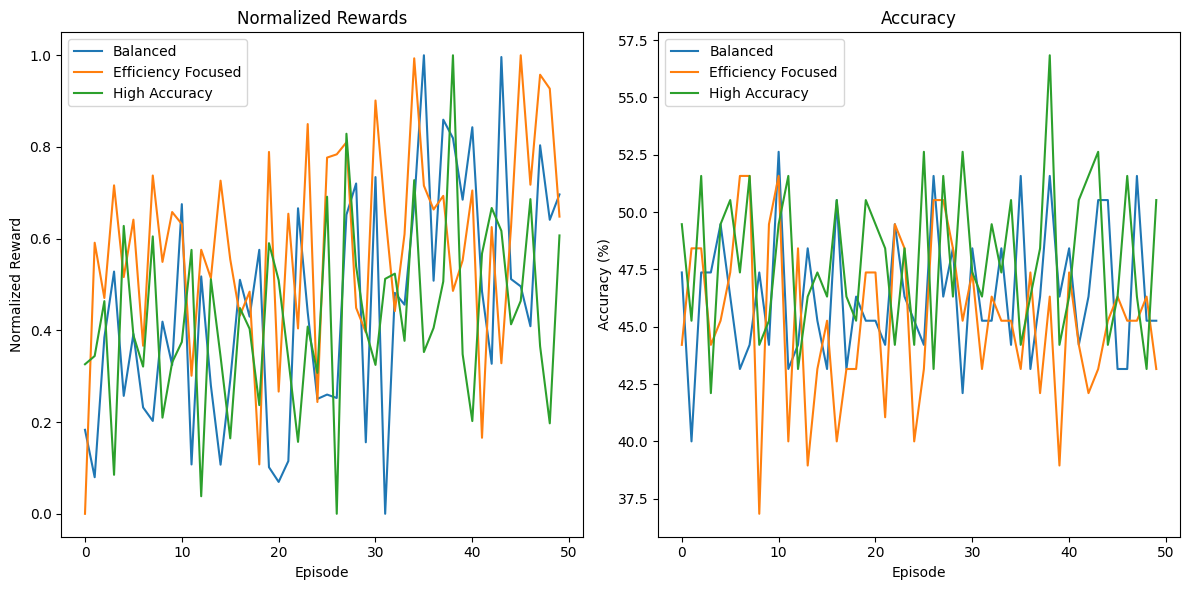

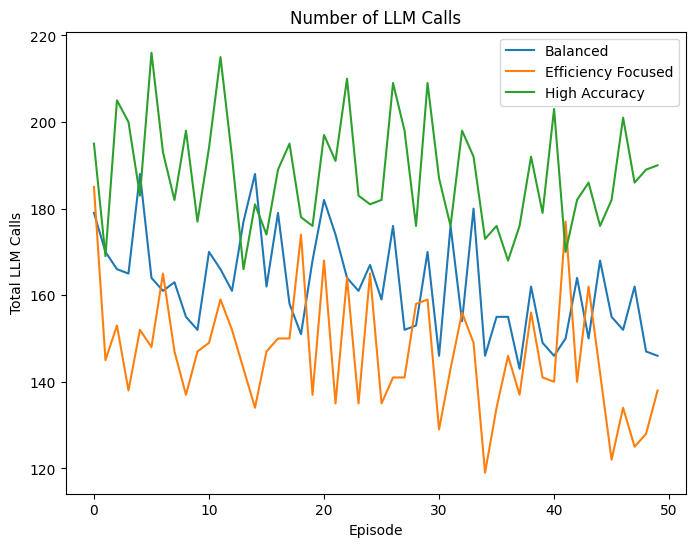

In [ ]:
import matplotlib.pyplot as plt

# Get rewards, accuracy and number of LLM calls for each configuration
balanced_rewards = accuracy_rewards_numcalls["Balanced"]["rewards"]
balanced_accuracy = accuracy_rewards_numcalls["Balanced"]["accuracy"]
balanced_num_calls = accuracy_rewards_numcalls["Balanced"]["num_calls"]

efficiency_rewards = accuracy_rewards_numcalls["Efficiency_Focused"]["rewards"]
efficiency_accuracy = accuracy_rewards_numcalls["Efficiency_Focused"]["accuracy"]
efficiency_num_calls = accuracy_rewards_numcalls["Efficiency_Focused"]["num_calls"]

high_accuracy_accuracy = accuracy_rewards_numcalls["High_Accuracy"]["accuracy"]
high_accuracy_rewards = accuracy_rewards_numcalls["High_Accuracy"]["rewards"]
high_accuracy_num_calls = accuracy_rewards_numcalls["High_Accuracy"]["num_calls"]

# min max scaling for rewards
balanced_rewards = (balanced_rewards - np.min(balanced_rewards)) / (np.max(balanced_rewards) - np.min(balanced_rewards))
efficiency_rewards = (efficiency_rewards - np.min(efficiency_rewards)) / (np.max(efficiency_rewards) - np.min(efficiency_rewards))
high_accuracy_rewards = (high_accuracy_rewards - np.min(high_accuracy_rewards)) / (np.max(high_accuracy_rewards) - np.min(high_accuracy_rewards))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(balanced_rewards, label="Balanced")
plt.plot(efficiency_rewards, label="Efficiency Focused")
plt.plot(high_accuracy_rewards, label="High Accuracy")
plt.title("Normalized Rewards")
plt.xlabel("Episode")
plt.ylabel("Normalized Reward")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(balanced_accuracy, label="Balanced")
plt.plot(efficiency_accuracy, label="Efficiency Focused")
plt.plot(high_accuracy_accuracy, label="High Accuracy")
plt.title("Accuracy")
plt.xlabel("Episode")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(balanced_num_calls, label="Balanced")
plt.plot(efficiency_num_calls, label="Efficiency Focused")
plt.plot(high_accuracy_num_calls, label="High Accuracy")
plt.title("Number of LLM Calls")
plt.xlabel("Episode")
plt.ylabel("Total LLM Calls")
plt.legend()
plt.show()

## Try it on test set data of hotpot qa 

In [ ]:
# Evaluate the agent on the test data
def evaluate_agent(agent, data):
    agent.q_network.eval()  # Set the model to evaluation mode
    correct_answers = 0
    total_parent_nodes = 0
    results = []
    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                state = get_state(node)
                action = agent.select_action(state, epsilon=0)  # No exploration during evaluation
                chosen_answer = None
                fallback_used = False  # Track if a fallback was used
                fallback_action = None

                # Simulate the action (choose answer based on action)
                if action == 0:  # CB
                    chosen_answer = node.get("cb_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to OB
                        chosen_answer = node.get("ob_answer", [None])[0]
                        fallback_action = 1
                        fallback_used = True
                elif action == 1:  # OB
                    chosen_answer = node.get("ob_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB
                        chosen_answer = node.get("cb_answer", [None])[0]
                        fallback_action = 0
                        fallback_used = True
                elif action == 2:  # Child
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                    for child_idx in node.get("sons", []):
                        child = example[child_idx]
                        child_state = get_state(child, depth=1)
                        child_action = agent.select_action(child_state, epsilon=0)  # Greedy policy
                        if child_action == 0:  # CB
                            child_answer = child.get("cb_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to OB
                                child_answer = child.get("ob_answer", [None])
                        elif child_action == 1:  # OB
                            child_answer = child.get("ob_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to CB
                                child_answer = child.get("cb_answer", [None])

                        tree_with_answers_chosen_by_agent[child_idx]["answer"] = child_answer

                    # Generate child_answer for the parent node
                    # print("tree_with_answers_chosen_by_agent", tree_with_answers_chosen_by_agent)
                    node["child_answer"], node["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                    chosen_answer = node["child_answer"][0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB or OB
                        chosen_answer = node.get("cb_answer", [None])[0]  # Try CB first
                        # fallback_used = True
                        if "unknown" in chosen_answer.lower().strip():
                            chosen_answer = node.get("ob_answer", [None])[0]  # Try OB next

                # Compute reward
                gold_answer, _ = q2gold[node["question_text"].strip()]
                # if chosen_answer and normalize_answer(chosen_answer) == normalize_answer(gold_answer):
                if chosen_answer and are_answers_equivalent_using_llm(chosen_answer, gold_answer):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": chosen_answer,
                    "gold": gold_answer,
                    "method": action_space[action] if not fallback_used else action_space[fallback_action]
                })

    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    return results, correct_answers, total_parent_nodes

import json
import torch

# Load test data
with open('results-testset-hotpotqa.json', 'r') as file:
    test_data = json.load(file)

# Load ground truth answers
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        print("ERROR CASE", e)

# List of trained models to evaluate
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"}
]

predictions_per_config = {}
correct_answers_per_config = {}
total_parent_nodes_per_config = {}
accuracy_per_config = {}

# Evaluate each model
for config in configurations:
    config_name = config["name"]
    model_path = f"saved_models_question_only_state/best_agent_{config_name}.pth"

    # Load the trained model
    agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)
    agent.q_network.load_state_dict(torch.load(model_path))
    agent.q_network.eval()  # Set model to evaluation mode

    print(f"\nEvaluating model: {config_name}")
    
    # Run evaluation
    rl_predictions, correct_answers, total_parent_nodes = evaluate_agent(agent, test_data)
    predictions_per_config[config_name] = rl_predictions
    correct_answers_per_config[config_name] = correct_answers
    total_parent_nodes_per_config[config_name] = total_parent_nodes

    # Print final accuracy
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    accuracy_per_config[config_name] = accuracy
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%\n")



Evaluating model: High_Accuracy
Evaluation Accuracy: 65.00%
Final Accuracy for High_Accuracy: 65.00%


Evaluating model: Balanced
Evaluation Accuracy: 65.00%
Final Accuracy for Balanced: 65.00%


Evaluating model: Efficiency_Focused
Evaluation Accuracy: 47.00%
Final Accuracy for Efficiency_Focused: 47.00%



In [ ]:
# dict of config and each value is dict of method and count
methods_count_per_config = {}

# Print the results of the agent for each configuration
for config_name, rl_predictions in predictions_per_config.items():
    print(f"Results for {config_name}:")
    for result in rl_predictions:
        print(f"Node {result['idx']}:")
        print(f"  Question: {result['question']}")
        print(f"  Answer: {result['answer']}")
        print(f"  Gold Answer: {result['gold']}")
        print(f"  Method: {result['method']}")
        method = result['method']
        if config_name not in methods_count_per_config:
            methods_count_per_config[config_name] = {}
        if method not in methods_count_per_config[config_name]:
            methods_count_per_config[config_name][method] = 0
        methods_count_per_config[config_name][method] += 1
        print()


# Print the count of methods used by the agent for each configuration
for config_name, method_counts in methods_count_per_config.items():
    print(f"Method Counts for {config_name}:")
    for method, count in method_counts.items():
        print(f"  {method}: {count}")
    print()

Results for High_Accuracy:
Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: American.
  Gold Answer: American
  Method: OB

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Wembley Stadium, London.
  Gold Answer: Wembley Stadium
  Method: OB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: South Korea and the United States.
  Gold Answer: South Korea
  Method: CB

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Q

In [ ]:
# Print the final accuracy for each configuration
for config_name, accuracy in accuracy_per_config.items():
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%")
    print(f"Total parent nodes: {total_parent_nodes_per_config[config_name]}")
    print(f"Times answer matches gold answer: {correct_answers_per_config[config_name]}")
    print()

Final Accuracy for High_Accuracy: 65.00%
Total parent nodes: 100
Times answer matches gold answer: 65

Final Accuracy for Balanced: 65.00%
Total parent nodes: 100
Times answer matches gold answer: 65

Final Accuracy for Efficiency_Focused: 47.00%
Total parent nodes: 100
Times answer matches gold answer: 47



In [ ]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(answer, final_answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable films include a 

In [ ]:
# compare between rl_predictions and probtree for each configuration
for config in configurations:
    config_name = config["name"]
    count = 0
    print(f"\nComparing results for {config_name} with the Probtree results:")
    for rl_pred, prob_tree_result in zip(predictions_per_config[config_name], results):
        if rl_pred['method'] == prob_tree_result['method'] or are_answers_equivalent_using_llm(rl_pred['answer'], prob_tree_result['answer']):
            continue
        count += 1
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
        print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
        print()
    print()
    print(f"Total mismatches: {count}")
    print("------------------------------------------------------------")



Comparing results for High_Accuracy with the Probtree results:
Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
Gold Answer: Wembley Stadium
RL Prediction: Wembley Stadium, London., ProbTree Result: Old Trafford.
RL Method: OB, ProbTree Method: CB

Question: Where was Nexon who was composed by Adam Gubman located at?
Gold Answer: South Korea
RL Prediction: South Korea and the United States., ProbTree Result: Tokyo, Japan.
RL Method: CB, ProbTree Method: Child

Question: Chun Woo-hee's notable films include a South Korean horror film about  a policeman who investigates a series of mysterious killings and what?
Gold Answer: illnesses
RL Prediction: illnesses., ProbTree Result: The Wailing.
RL Method: OB, ProbTree Method: CB

Question: Little Brown Stein is a rivalry trophy that imitates a mug made out of what item?
Gold Answer: stoneware
RL Prediction: earthenware., ProbTree Result: a stein mug.
RL Method: OB, ProbTree Me

# RL Approach with deep learning (Pretrained transformers taking input as text)

In [ ]:
# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset-hotpotqa.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel

class PretrainedTransformerQNetwork(nn.Module):
    def __init__(self, pretrained_model_name="bert-medium-uncased", num_classes=3):
        super(PretrainedTransformerQNetwork, self).__init__()
        
        # Load pretrained transformer model (e.g., BERT)
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
        self.bert = BertModel.from_pretrained(pretrained_model_name)  # Pretrained transformer model
        
        # Classification head (maps BERT [CLS] output to the action space)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 128),  # Intermediate layer with hidden size
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, num_classes)  # Output layer for 3 actions: CB, OB, Child
        )

        # Freeze BERT parameters (no gradient updates for BERT)
        for param in self.bert.parameters():
            param.requires_grad = False  # Freeze BERT weights

    def forward(self, input_texts):
        """
        Forward pass through the model to predict actions.

        Args:
        - input_texts: List of strings formatted as `<Question> </Question> <Children> <child> ... </Children>`.

        Returns:
        - logits: Predicted Q-values for the action space for each input.
        """
        # Tokenize the input text
        tokens = self.tokenizer(
            input_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        # Run input through the pretrained BERT model
        outputs = self.bert(input_ids=tokens["input_ids"], attention_mask=tokens["attention_mask"])
        pooled_output = outputs.pooler_output  # [CLS] token embedding (batch_size, hidden_size)

        # Pass the [CLS] output through the classification head
        logits = self.classifier(pooled_output)  # Shape: [batch_size, num_classes]

        return logits


class DQNAgent:
    def __init__(self, pretrained_model_name, num_classes, lr=1e-5, gamma=0.99):
        self.q_network = PretrainedTransformerQNetwork(pretrained_model_name, num_classes)
        self.target_network = PretrainedTransformerQNetwork(pretrained_model_name, num_classes)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.replay_buffer = []

    def select_action(self, input_text, epsilon):
        """
        Select an action based on the input text using epsilon-greedy strategy.

        Args:
        - input_text: String formatted as `<Question> ... </Question> <Children> ... </Children>`.
        - epsilon: Exploration probability.

        Returns:
        - Action index (0 = CB, 1 = OB, or 2 = Child [allowed only for parent nodes]).
        """
        # Determine if the node is a parent or a leaf based on `<Children>` in input_text
        is_parent_node = "<Children>" in input_text and "<child>" in input_text
        
        # Restrict valid actions based on node type
        if is_parent_node:
            valid_actions = [0, 1, 2]  # CB, OB, and Child actions are valid for parent
        else:
            valid_actions = [0, 1]  # CB and OB only for leaf nodes (Child action not allowed)

        if random.random() < epsilon:  # Exploration (random action)
            # Choose from valid actions randomly
            return random.choice(valid_actions)
        else:  # Exploitation (predict using Q-network)
            with torch.no_grad():
                # Forward pass through the Q-network
                logits = self.q_network([input_text])  # Input must be a list of text
                q_values = logits.squeeze(0)  # Shape: [action_dim]
                
                # Mask invalid actions by setting their Q-values to a very low value
                masked_q_values = q_values.clone()  # Clone to avoid modifying original Q-values
                for action in range(q_values.size(0)):
                    if action not in valid_actions:
                        masked_q_values[action] = -float('inf')  # Mask invalid actions
                
                # Select action with the highest Q-value from the valid set
                action = torch.argmax(masked_q_values).item()
                return action


    def train(self, batch_size):
        """
        Train the Q-network.
        """
        if len(self.replay_buffer) < batch_size:
            return

        # Sample mini-batch of transitions
        batch = random.sample(self.replay_buffer, batch_size)
        input_texts, actions, rewards, next_input_texts, dones = zip(*batch)

        # Compute Q-values for current states
        logits = self.q_network(list(input_texts))  # List of input texts
        q_values = logits.gather(1, torch.tensor(actions).unsqueeze(1)).squeeze(1)

        # Compute target Q-values using target network
        with torch.no_grad():
            next_logits = self.target_network(list(next_input_texts))  # List of next input texts
            max_next_q_values = next_logits.max(1)[0]  # Max Q-value for next states
            dones_tensor = torch.tensor(dones, dtype=torch.float32)  # Convert dones to float tensor
            target_q_values = torch.tensor(rewards) + self.gamma * max_next_q_values * (1 - dones_tensor)

        # Compute loss and backpropagate
        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        """
        Update the target network with the weights of the Q-network.
        """
        self.target_network.load_state_dict(self.q_network.state_dict())


In [ ]:
# action_space = ['CB', 'OB', 'Child']  # Possible actions
# state_dim = 7 + 384 + 2 + 2 + 2  # 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
# action_dim = len(action_space)  # Number of actions (CB, OB, Child)
# hidden_dim = 128  # Hidden layer size
# lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
# gamma = 0.99  # Discount factor
# epsilon = 1.0  # Initial exploration rate
# epsilon_min = 0.01  # Minimum exploration rate
# epsilon_decay = 0.98  # Decay rate for exploration
# batch_size = 32  # Mini-batch size
# num_episodes = 50  # Number of training episodes

In [ ]:
import os
import torch
import copy

# Create directory for saved models
os.makedirs("saved_models_pretrained_transformer_question_only_state", exist_ok=True)

# Define different configurations for alpha and beta
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"}
]

# Dictionary to store results
accuracy_rewards_numcalls = {}

# Loop through different settings
for config in configurations:
    alpha = config["alpha"]
    beta = config["beta"]
    config_name = config["name"]
    # Define hyperparameters
    action_space = ['CB', 'OB', 'Child']  # Possible actions
    state_dim = 7 + 384 + 2 + 2 + 2  # 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
    action_dim = len(action_space)  # Number of actions (CB, OB, Child)
    hidden_dim = 128  # Hidden layer size
    lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
    gamma = 0.99  # Discount factor
    epsilon = 1.0  # Initial exploration rate
    epsilon_min = 0.01  # Minimum exploration rate
    epsilon_decay = 0.98  # Decay rate for exploration
    batch_size = 32  # Mini-batch size
    num_episodes = 50  # Number of training episodes
    agent = DQNAgent(pretrained_model_name="bert-base-uncased", num_classes=3, lr=lr, gamma=gamma)

    print(f"\nTraining with {config_name} (alpha={alpha}, beta={beta})")

    max_accuracy = 0
    best_agent = None

    # Store rewards, accuracy and total number of LLM calls for each episode
    rewards_list = []
    accuracy_list = []
    total_num_llm_calls_list = []

    # Set model to training mode
    agent.q_network.train()

    for episode in range(num_episodes):
        print(f"Episode {episode + 1}/{num_episodes}")
        total_reward = 0
        correct_answers = 0
        total_parent_nodes = 0
        total_num_llm_calls = 0

        for example in data:
            for node in example:
                if "fa" not in node:  # Only process parent nodes
                    total_parent_nodes += 1

                    # **Construct Input Text as BERT-Compatible Format**
                    # Example: <Question> ... </Question> <Children> <child> ... </child> </Children>
                    question = node.get("question_text", "").strip()
                    child_texts = []
                    for child_idx in node.get("sons", []):  # Process child nodes
                        child_node = example[child_idx]
                        child_question = child_node["question_text"].strip()
                        child_texts.append(f"<child> {child_question} </child>")

                    # Final Input Format for the Node
                    input_text = f"<Question> {question} </Question> <Children> {' '.join(child_texts)} </Children>"

                    # Select Action Using the Agent
                    action = agent.select_action(input_text, epsilon)
                    chosen_answer = None
                    fallback_used = False
                    num_llm_calls = None

                    # Simulate the Action
                    if action == 0:  # CB
                        chosen_answer = node.get("cb_answer", [None])
                        num_llm_calls = 1
                    elif action == 1:  # OB
                        chosen_answer = node.get("ob_answer", [None])
                        num_llm_calls = 1
                    elif action == 2:  # Child Agg:
                        # Recursively process children
                        tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                        child_experiences = []

                        for node_ in tree_with_answers_chosen_by_agent:  # Process each node in the copied tree
                            # Build Input Text for Child Node
                            question = node_["question_text"].strip()
                            ref_tokens = re.findall(r"<\d+>", question)
                            topic_entities = []
                            for ref_token in ref_tokens:
                                if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                    ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                    if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                        question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                        topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                            node_["question"] = question

                            # Leaf Node -> Execute Child-Specific Actions
                            if len(node_["sons"]) == 0:  
                                child_input_text = f"<Question> {node_['question_text']} </Question>"
                                child_action = agent.select_action(child_input_text, epsilon)
                                # print("question", question)
                                if child_action == 0:  # CB
                                    node_["cb_answer"] = get_cb_answer(question)
                                    # print("cb_answer", node_["cb_answer"][0])
                                    child_answer = node_.get("cb_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():  # Fallback to OB
                                        child_action = 1
                                        node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                        # print("fall back to ob_answer", node_["ob_answer"][0])
                                        child_answer = node_.get("ob_answer", [None])
                                elif child_action == 1:  # OB
                                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                    # print("ob_answer", node_["ob_answer"][0])
                                    child_answer = node_.get("ob_answer", [None])
                                    if "unknown" in child_answer[0].lower().strip():  # Fallback to CB
                                        child_action = 0
                                        node_["cb_answer"] = get_cb_answer(question)
                                        # print("fall back to cb_answer", node_["cb_answer"][0])
                                        child_answer = node_.get("cb_answer", [None])
                                else:
                                    raise Exception("Incorrect action chosen")
                                node_["answer"] = child_answer
                                child_experiences.append((child_input_text, child_action, 0, child_input_text, False))
                            else:  # Process Non-Leaf Nodes
                                # print("tree_with_answers_chosen_by_agent", tree_with_answers_chosen_by_agent)
                                node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                                chosen_answer = node["child_answer"]

                        num_llm_calls = len(child_experiences) + 1 + 1  # Number of children + Decomposition + Aggregation

                    # Fallback Handling (if "unknown" result occurs)
                    if "unknown" in chosen_answer[0].lower().strip():
                        fallback_used = True
                        if action == 0:  # Fallback from CB to OB
                            fallback_action = 1
                            chosen_answer = node.get("ob_answer", [None])
                        elif action == 1:  # Fallback from OB to CB
                            fallback_action = 0
                            chosen_answer = node.get("cb_answer", [None])
                        elif action == 2:  # Fallback from Child Agg to CB
                            fallback_action = 0
                            chosen_answer = node.get("cb_answer", [None])

                    # Compute Reward
                    gold_answer, _ = q2gold[node["question_text"].strip()]
                    reward = get_reward(chosen_answer[0], gold_answer, action, num_llm_calls, alpha, beta)
                    total_reward += reward

                    # if normalize_answer(chosen_answer[0]) == normalize_answer(gold_answer):
                    if are_answers_equivalent_using_llm(gold_answer, chosen_answer[0]):
                        correct_answers += 1

                    # Append State, Action, and Reward to Replay Buffer
                    next_input_text = input_text  # Keep input text same as state (no numerical states)
                    if not fallback_used:
                        agent.replay_buffer.append((input_text, action, reward, next_input_text, False))
                    else:
                        agent.replay_buffer.append((input_text, fallback_action, reward, next_input_text, False))

                    if action == 2:  # Append child experiences to replay buffer
                        num_children = len(node.get("sons", []))
                        child_reward = reward / num_children
                        for child_input_text, child_action, _, next_child_input_text, done in child_experiences:
                            agent.replay_buffer.append((child_input_text, child_action, child_reward, next_child_input_text, done))

                    # Update total number of LLM calls in this episode
                    total_num_llm_calls += num_llm_calls

                    # Train the Agent with Replay Buffer
                    agent.train(batch_size)

        # Epsilon Decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Update Target Network
        if episode % 10 == 0:
            agent.update_target_network()

        # Calculate Accuracy
        accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
        rewards_list.append(total_reward)
        accuracy_list.append(accuracy)
        total_num_llm_calls_list.append(total_num_llm_calls)

        print(f"Episode {episode+1} - Total Reward: {total_reward}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Total LLM Calls: {total_num_llm_calls}")
        print(f"Epsilon: {epsilon:.4f}\n")

        print()

    # Store the rewards and accuracy for this configuration
    accuracy_rewards_numcalls[config_name] = {
        "rewards": rewards_list,
        "accuracy": accuracy_list,
        "num_calls": total_num_llm_calls_list
    }

    # Save model after training with each configuration
    model_path = f"saved_models_pretrained_transformer_question_only_state/agent_{config_name}.pth"
    torch.save(agent.q_network.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the best model overall
    if best_agent is not None:
        best_model_path = f"saved_models_pretrained_transformer_question_only_state/best_agent_{config_name}.pth"
        torch.save(best_agent.q_network.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")


Token indices sequence length is longer than the specified maximum sequence length for this model (1632 > 1024). Running this sequence through the model will result in indexing errors



Training with High_Accuracy (alpha=2.0, beta=0.05)
Episode 1/50
Episode 1 - Total Reward: 114.92323032319554
Accuracy: 36.84%
Total LLM Calls: 164
Epsilon: 0.9950


Episode 2/50
Episode 2 - Total Reward: 118.86192830801018
Accuracy: 45.26%
Total LLM Calls: 207
Epsilon: 0.9900


Episode 3/50
Episode 3 - Total Reward: 115.6708823025227
Accuracy: 37.89%
Total LLM Calls: 214
Epsilon: 0.9851


Episode 4/50
Episode 4 - Total Reward: 114.66105130016813
Accuracy: 35.79%
Total LLM Calls: 176
Epsilon: 0.9801


Episode 5/50
Episode 5 - Total Reward: 119.07697103321557
Accuracy: 42.11%
Total LLM Calls: 207
Epsilon: 0.9752


Episode 6/50
Episode 6 - Total Reward: 111.94868095219144
Accuracy: 34.74%
Total LLM Calls: 185
Epsilon: 0.9704


Episode 7/50
Episode 7 - Total Reward: 113.97956050038344
Accuracy: 37.89%
Total LLM Calls: 198
Epsilon: 0.9655


Episode 8/50
Episode 8 - Total Reward: 115.48361401855952
Accuracy: 40.00%
Total LLM Calls: 188
Epsilon: 0.9607


Episode 9/50
Episode 9 - Total Reward

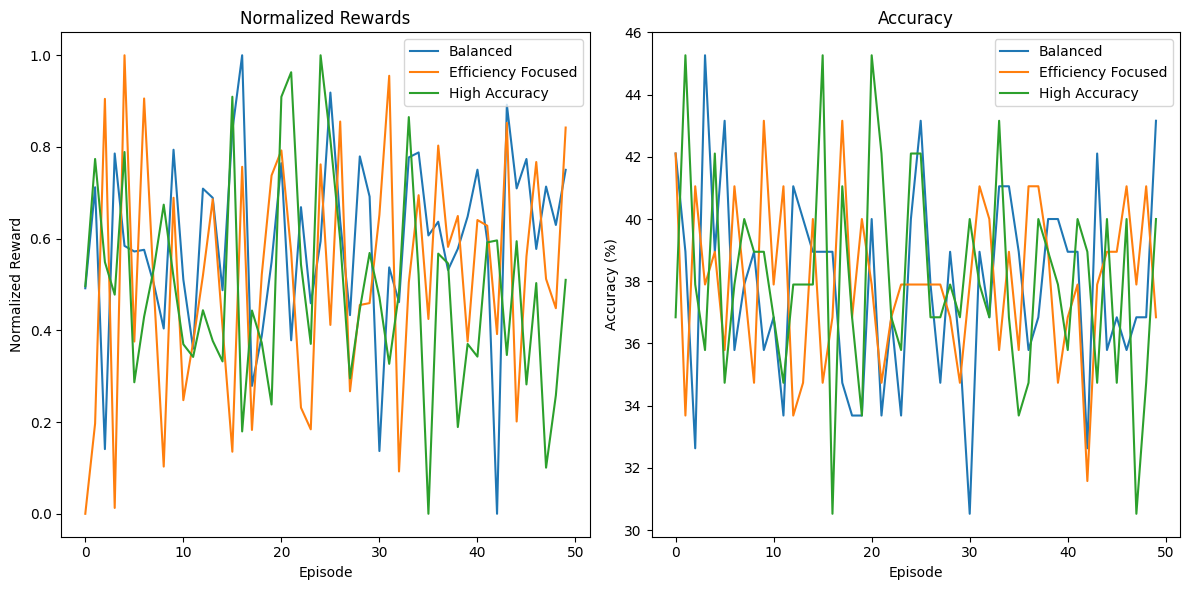

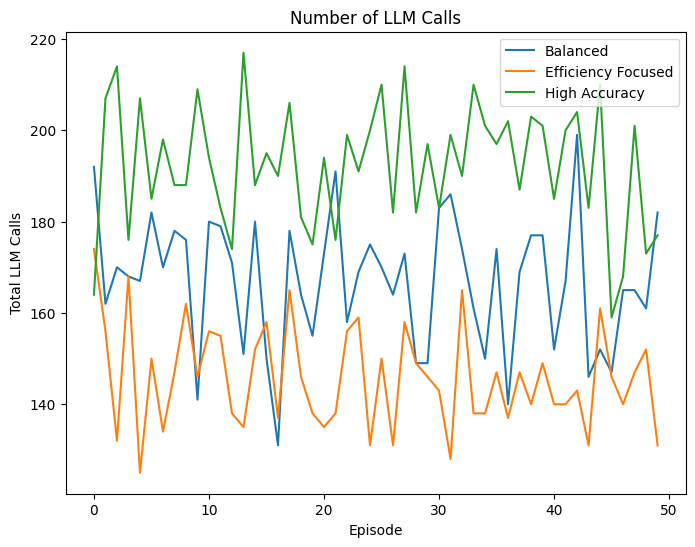

In [ ]:
import matplotlib.pyplot as plt

# Get rewards, accuracy and number of LLM calls for each configuration
balanced_rewards = accuracy_rewards_numcalls["Balanced"]["rewards"]
balanced_accuracy = accuracy_rewards_numcalls["Balanced"]["accuracy"]
balanced_num_calls = accuracy_rewards_numcalls["Balanced"]["num_calls"]

efficiency_rewards = accuracy_rewards_numcalls["Efficiency_Focused"]["rewards"]
efficiency_accuracy = accuracy_rewards_numcalls["Efficiency_Focused"]["accuracy"]
efficiency_num_calls = accuracy_rewards_numcalls["Efficiency_Focused"]["num_calls"]

high_accuracy_accuracy = accuracy_rewards_numcalls["High_Accuracy"]["accuracy"]
high_accuracy_rewards = accuracy_rewards_numcalls["High_Accuracy"]["rewards"]
high_accuracy_num_calls = accuracy_rewards_numcalls["High_Accuracy"]["num_calls"]

# min max scaling for rewards
balanced_rewards = (balanced_rewards - np.min(balanced_rewards)) / (np.max(balanced_rewards) - np.min(balanced_rewards))
efficiency_rewards = (efficiency_rewards - np.min(efficiency_rewards)) / (np.max(efficiency_rewards) - np.min(efficiency_rewards))
high_accuracy_rewards = (high_accuracy_rewards - np.min(high_accuracy_rewards)) / (np.max(high_accuracy_rewards) - np.min(high_accuracy_rewards))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(balanced_rewards, label="Balanced")
plt.plot(efficiency_rewards, label="Efficiency Focused")
plt.plot(high_accuracy_rewards, label="High Accuracy")
plt.title("Normalized Rewards")
plt.xlabel("Episode")
plt.ylabel("Normalized Reward")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(balanced_accuracy, label="Balanced")
plt.plot(efficiency_accuracy, label="Efficiency Focused")
plt.plot(high_accuracy_accuracy, label="High Accuracy")
plt.title("Accuracy")
plt.xlabel("Episode")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(balanced_num_calls, label="Balanced")
plt.plot(efficiency_num_calls, label="Efficiency Focused")
plt.plot(high_accuracy_num_calls, label="High Accuracy")
plt.title("Number of LLM Calls")
plt.xlabel("Episode")
plt.ylabel("Total LLM Calls")
plt.legend()
plt.show()

## Try it on test set data of hotpot qa 

In [ ]:
# Evaluate the agent on the test data
def evaluate_agent(agent, data):
    agent.q_network.eval()  # Set the model to evaluation mode
    correct_answers = 0
    total_parent_nodes = 0
    results = []

    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1

                # **Construct Input Text as BERT-Compatible Format**
                # Example: <Question> ... </Question> <Children> <child> ... </child> </Children>
                question = node.get("question_text", "").strip()
                child_texts = []
                for child_idx in node.get("sons", []):  # Process child nodes
                    child_node = example[child_idx]
                    child_question = child_node["question_text"].strip()
                    child_texts.append(f"<child> {child_question} </child>")

                # Final Input Format for the Node
                input_text = f"<Question> {question} </Question> <Children> {' '.join(child_texts)} </Children>"

                # Select Action Using the Agent
                action = agent.select_action(input_text, epsilon)
                chosen_answer = None
                fallback_used = False

                # Simulate the Action
                if action == 0:  # CB
                    chosen_answer = node.get("cb_answer", [None])
                elif action == 1:  # OB
                    chosen_answer = node.get("ob_answer", [None])
                elif action == 2:  # Child Agg:
                    # Recursively process children
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                    child_experiences = []

                    for node_ in tree_with_answers_chosen_by_agent:  # Process each node in the copied tree
                        # Build Input Text for Child Node
                        question = node_["question_text"].strip()
                        ref_tokens = re.findall(r"<\d+>", question)
                        topic_entities = []
                        for ref_token in ref_tokens:
                            if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                    question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                    topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                        node_["question"] = question

                        # Leaf Node -> Execute Child-Specific Actions
                        if len(node_["sons"]) == 0:  
                            child_input_text = f"<Question> {node_['question_text']} </Question>"
                            child_action = agent.select_action(child_input_text, epsilon)
                            # print("question", question)
                            if child_action == 0:  # CB
                                node_["cb_answer"] = get_cb_answer(question)
                                # print("cb_answer", node_["cb_answer"][0])
                                child_answer = node_.get("cb_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():  # Fallback to OB
                                    child_action = 1
                                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                    # print("fall back to ob_answer", node_["ob_answer"][0])
                                    child_answer = node_.get("ob_answer", [None])
                            elif child_action == 1:  # OB
                                node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                                # print("ob_answer", node_["ob_answer"][0])
                                child_answer = node_.get("ob_answer", [None])
                                if "unknown" in child_answer[0].lower().strip():  # Fallback to CB
                                    child_action = 0
                                    node_["cb_answer"] = get_cb_answer(question)
                                    # print("fall back to cb_answer", node_["cb_answer"][0])
                                    child_answer = node_.get("cb_answer", [None])
                            else:
                                raise Exception("Incorrect action chosen")
                            node_["answer"] = child_answer
                            child_experiences.append((child_input_text, child_action, 0, child_input_text, False))
                        else:  # Process Non-Leaf Nodes
                            # print("tree_with_answers_chosen_by_agent", tree_with_answers_chosen_by_agent)
                            node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                            chosen_answer = node["child_answer"]

                # Fallback Handling (if "unknown" result occurs)
                if "unknown" in chosen_answer[0].lower().strip():
                    fallback_used = True
                    if action == 0:  # Fallback from CB to OB
                        fallback_action = 1
                        chosen_answer = node.get("ob_answer", [None])
                    elif action == 1:  # Fallback from OB to CB
                        fallback_action = 0
                        chosen_answer = node.get("cb_answer", [None])
                    elif action == 2:  # Fallback from Child Agg to CB
                        fallback_action = 0
                        chosen_answer = node.get("cb_answer", [None])

                # Compute Reward
                gold_answer, _ = q2gold[node["question_text"].strip()]
                # if normalize_answer(chosen_answer[0]) == normalize_answer(gold_answer):
                if are_answers_equivalent_using_llm(chosen_answer[0], gold_answer):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": chosen_answer,
                    "gold": gold_answer,
                    "method": action_space[action] if not fallback_used else action_space[fallback_action]
                })
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    return results, correct_answers, total_parent_nodes

import json
import torch

# Load test data
with open('results-testset-hotpotqa.json', 'r') as file:
    test_data = json.load(file)

# Load ground truth answers
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        print("ERROR CASE", e)

# List of trained models to evaluate
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"}
]

predictions_per_config = {}
correct_answers_per_config = {}
total_parent_nodes_per_config = {}
accuracy_per_config = {}

# Evaluate each model
for config in configurations:
    config_name = config["name"]
    model_path = f"saved_models_pretrained_transformer_question_only_state/agent_{config_name}.pth"

    # Load the trained model
    best_agent = DQNAgent(pretrained_model_name="bert-base-uncased", num_classes=3, lr=lr, gamma=gamma)
    best_agent.q_network.load_state_dict(torch.load(model_path))
    best_agent.q_network.eval()  # Set model to evaluation mode

    print(f"\nEvaluating model: {config_name}")
    
    # Run evaluation
    rl_predictions, correct_answers, total_parent_nodes = evaluate_agent(best_agent, test_data)
    predictions_per_config[config_name] = rl_predictions
    correct_answers_per_config[config_name] = correct_answers
    total_parent_nodes_per_config[config_name] = total_parent_nodes

    # Print final accuracy
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    accuracy_per_config[config_name] = accuracy
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%\n")



Evaluating model: High_Accuracy
Evaluation Accuracy: 47.00%
Final Accuracy for High_Accuracy: 47.00%


Evaluating model: Balanced
Evaluation Accuracy: 44.00%
Final Accuracy for Balanced: 44.00%


Evaluating model: Efficiency_Focused
Evaluation Accuracy: 48.00%
Final Accuracy for Efficiency_Focused: 48.00%



In [ ]:
# dict of config and each value is dict of method and count
methods_count_per_config = {}

# Print the results of the agent for each configuration
for config_name, rl_predictions in predictions_per_config.items():
    print(f"Results for {config_name}:")
    for result in rl_predictions:
        print(f"Node {result['idx']}:")
        print(f"  Question: {result['question']}")
        print(f"  Answer: {result['answer']}")
        print(f"  Gold Answer: {result['gold']}")
        print(f"  Method: {result['method']}")
        method = result['method']
        if config_name not in methods_count_per_config:
            methods_count_per_config[config_name] = {}
        if method not in methods_count_per_config[config_name]:
            methods_count_per_config[config_name][method] = 0
        methods_count_per_config[config_name][method] += 1
        print()


# Print the count of methods used by the agent for each configuration
for config_name, method_counts in methods_count_per_config.items():
    print(f"Method Counts for {config_name}:")
    for method, count in method_counts.items():
        print(f"  {method}: {count}")
    print()

Results for High_Accuracy:
Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: ['United States.', -0.05797316894724785, "The context states that Michael P. Fay is the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same, and his nationality is United States. So the answer is: United States.", [-0.40429688, -0.875, -0.14160156, -0.0010223389, -0.049804688, -3.5762787e-07, -3.8146973e-06, 0, -0.03173828, -0.0040893555, -3.5762787e-07, -0.57421875, -7.1525574e-07, -2.9683113e-05, -2.3841858e-07, -1.1920929e-06, 0, -2.3841858e-07, -1.1920929e-07, -0.00045204163, 0, -1.1920929e-07, -1.66893e-06, -0.0002670288, 0, 0, -0.00579834, -5.9604645e-07, -0.32617188, 0, -2.3841858e-07, -0.25195312, -1.1920929e-07, -4.6014786e-05, -0.001953125, -4.7683716e-07, 0, 0, 0, -1.04904175e-05, 0, -5.00679e-06, -1.9073486e-06]]
  Gold Answer: American
  Method: Ch

In [ ]:
# Print the final accuracy for each configuration
for config_name, accuracy in accuracy_per_config.items():
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%")
    print(f"Total parent nodes: {total_parent_nodes_per_config[config_name]}")
    print(f"Times answer matches gold answer: {correct_answers_per_config[config_name]}")
    print()

Final Accuracy for High_Accuracy: 47.00%
Total parent nodes: 100
Times answer matches gold answer: 47

Final Accuracy for Balanced: 44.00%
Total parent nodes: 100
Times answer matches gold answer: 44

Final Accuracy for Efficiency_Focused: 48.00%
Total parent nodes: 100
Times answer matches gold answer: 48



In [ ]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(answer, final_answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable films include a 

In [ ]:
# compare between rl_predictions and probtree for each configuration
for config in configurations:
    config_name = config["name"]
    count = 0
    print(f"\nComparing results for {config_name} with the Probtree results:")
    for rl_pred, prob_tree_result in zip(predictions_per_config[config_name], results):
        if rl_pred['method'] == prob_tree_result['method'] or rl_pred['answer'] == prob_tree_result['answer']:
            continue
        count += 1
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
        print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
    print()
    print(f"Total mismatches: {count}")
    print("------------------------------------------------------------")



Comparing results for High_Accuracy with the Probtree results:
Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
Gold Answer: Andrew Lloyd Webber and Tim Rice
RL Prediction: ['Rod Argent and Jim Webb.', -0.19244990811931284, 'The 1970 international hit song Murray Head is most recognized for is "Judy Garland\'s \'Come Shine with Me\'". The song "Judy Garland\'s \'Come Shine with Me\'" was written by Rod Argent and Jim Webb. So the answer is: Rod Argent and Jim Webb.', [-0.62109375, -0.19921875, -1.1920929e-07, -2.3841858e-07, -1.3113022e-06, -2.3841858e-07, 0, -0.20214844, -5.9604645e-07, -4.7683716e-07, -1.1920929e-07, -5.6028366e-06, -0.00026130676, -0.0003299713, -0.0015411377, -1.125, -0.82421875, -1.5234375, -0.78125, -0.34570312, -0.484375, -0.45117188, -0.06982422, -0.00039482117, -0.018920898, -0.27539062, -0.9921875, -0.08154297, -0.265625, -0.079589844, -0.0009841919, -1.1920929e-07, -1.347065e-05, -1.5377998e-05, -3.8146973e-06, -1.0728

In [ ]:
# compare between rl_predictions and probtree for each configuration
for config in configurations:
    config_name = config["name"]
    print(f"\Incorrect Examples for {config_name}:")
    for rl_pred, prob_tree_result in zip(predictions_per_config[config_name], results):
        # if normalize_answer(rl_pred['answer'][0]) == normalize_answer(q2gold[rl_pred['question']][0]):
        if are_answers_equivalent_using_llm(rl_pred['answer'][0], q2gold[rl_pred['question']][0]):
            continue
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer'][0]}")
        print(f"RL Method: {rl_pred['method']}")
        print()
    print("------------------------------------------------------------")


\Incorrect Examples for High_Accuracy:
Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
Gold Answer: American
RL Prediction: United States.
RL Method: Child

Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
Gold Answer: Andrew Lloyd Webber and Tim Rice
RL Prediction: Rod Argent and Jim Webb.
RL Method: CB

Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
Gold Answer: Wembley Stadium
RL Prediction: Old Trafford.
RL Method: CB

Question: Where was Nexon who was composed by Adam Gubman located at?
Gold Answer: South Korea
RL Prediction: Tokyo, Japan.
RL Method: Child

Question: What team had Tony Roberts replaced by an American sportscaster from Buffalo, New York when he retired?
Gold Answer: Notre Dame Fighting Irish football
RL Prediction: Buffalo Sabres.
RL Method: CB

Question: Cooperative Livi

# Random Solver

## Try it on test set data of hotpot qa 

In [ ]:
def select_random_action(is_child):
    if is_child == True:
        return random.randint(0, len(action_space) - 2)
    else:
        return random.randint(0, len(action_space) - 1)
            
# Evaluate the agent on the test data
def evaluate_random_agent(data):
    correct_answers = 0
    total_parent_nodes = 0
    results = []
    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                if len(node.get("sons", [])) != 0:  # Leaf node
                    action = select_random_action(is_child=False)
                else:
                    action = select_random_action(is_child=True)
                chosen_answer = None
                fallback_used = False  # Track if a fallback was used
                fallback_action = None

                # Simulate the action (choose answer based on action)
                if action == 0:  # CB
                    chosen_answer = node.get("cb_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to OB
                        chosen_answer = node.get("ob_answer", [None])[0]
                        fallback_action = 1
                        fallback_used = True
                elif action == 1:  # OB
                    chosen_answer = node.get("ob_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB
                        chosen_answer = node.get("cb_answer", [None])[0]
                        fallback_action = 0
                        fallback_used = True
                elif action == 2:  # Child
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                    for child_idx in node.get("sons", []):
                        child = example[child_idx]
                        child_action = select_random_action(is_child=True)
                        if child_action == 0:  # CB
                            child["cb_answer"] = get_cb_answer(child["question_text"])
                            child_answer = child.get("cb_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to OB
                                child_action = 1
                                child["ob_answer"] = get_singlehop_ob_answer(child["question_text"])
                                child_answer = child.get("ob_answer", [None])
                        elif child_action == 1:  # OB
                            child_answer = child.get("ob_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to CB
                                child_action = 0
                                child["cb_answer"] = get_cb_answer(child["question_text"])
                                child_answer = child.get("cb_answer", [None])

                        tree_with_answers_chosen_by_agent[child_idx]["answer"] = child_answer

                    # Generate child_answer for the parent node
                    # print("tree_with_answers_chosen_by_agent", tree_with_answers_chosen_by_agent)
                    node["child_answer"], node["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                    chosen_answer = node["child_answer"][0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB or OB
                        chosen_answer = node.get("cb_answer", [None])[0]  # Try CB first
                        # fallback_used = True
                        if "unknown" in chosen_answer.lower().strip():
                            chosen_answer = node.get("ob_answer", [None])[0]  # Try OB next

                # Compute reward
                gold_answer, _ = q2gold[node["question_text"].strip()]
                # if chosen_answer and normalize_answer(chosen_answer) == normalize_answer(gold_answer):
                if chosen_answer and are_answers_equivalent_using_llm(chosen_answer, gold_answer):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": chosen_answer,
                    "gold": gold_answer,
                    "method": action_space[action] if not fallback_used else action_space[fallback_action]
                })

    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    return results, correct_answers, total_parent_nodes

import json
import torch

# Load test data
with open('results-testset-hotpotqa.json', 'r') as file:
    test_data = json.load(file)

# Load ground truth answers
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        print("ERROR CASE", e)

# List of trained models to evaluate
configurations = [
    {"name": "Random"},
]

predictions_per_config = {}
correct_answers_per_config = {}
total_parent_nodes_per_config = {}
accuracy_per_config = {}

# Evaluate each model
for config in configurations:
    config_name = config["name"]
    model_path = f"saved_models_random/best_agent_{config_name}.pth"

    print(f"\nEvaluating model: {config_name}")
    
    # Run evaluation
    rl_predictions, correct_answers, total_parent_nodes = evaluate_random_agent(test_data)
    predictions_per_config[config_name] = rl_predictions
    correct_answers_per_config[config_name] = correct_answers
    total_parent_nodes_per_config[config_name] = total_parent_nodes

    # Print final accuracy
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    accuracy_per_config[config_name] = accuracy
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%\n")


Evaluating model: Random


NameError: name 'random' is not defined

In [ ]:
# dict of config and each value is dict of method and count
methods_count_per_config = {}

# Print the results of the agent for each configuration
for config_name, rl_predictions in predictions_per_config.items():
    print(f"Results for {config_name}:")
    for result in rl_predictions:
        print(f"Node {result['idx']}:")
        print(f"  Question: {result['question']}")
        print(f"  Answer: {result['answer']}")
        print(f"  Gold Answer: {result['gold']}")
        print(f"  Method: {result['method']}")
        method = result['method']
        if config_name not in methods_count_per_config:
            methods_count_per_config[config_name] = {}
        if method not in methods_count_per_config[config_name]:
            methods_count_per_config[config_name][method] = 0
        methods_count_per_config[config_name][method] += 1
        print()


# Print the count of methods used by the agent for each configuration
for config_name, method_counts in methods_count_per_config.items():
    print(f"Method Counts for {config_name}:")
    for method, count in method_counts.items():
        print(f"  {method}: {count}")
    print()

Results for Random:
Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: American.
  Gold Answer: American
  Method: OB

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Wembley Stadium, London.
  Gold Answer: Wembley Stadium
  Method: OB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: South Korea and the United States.
  Gold Answer: South Korea
  Method: CB

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: Child

Node 2:
  Quest

In [ ]:
# Print the final accuracy for each configuration
for config_name, accuracy in accuracy_per_config.items():
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%")
    print(f"Total parent nodes: {total_parent_nodes_per_config[config_name]}")
    print(f"Times answer matches gold answer: {correct_answers_per_config[config_name]}")
    print()

Final Accuracy for Random: 44.00%
Total parent nodes: 100
Times answer matches gold answer: 44



In [ ]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(answer, final_answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: Child

Node 2:
  Question: Chun Woo-hee's notable films include

In [ ]:
# compare between rl_predictions and probtree for each configuration
for config in configurations:
    config_name = config["name"]
    count = 0
    print(f"\nComparing results for {config_name} with the Probtree results:")
    for rl_pred, prob_tree_result in zip(predictions_per_config[config_name], results):
        if rl_pred['method'] == prob_tree_result['method'] or rl_pred['answer'] == prob_tree_result['answer']:
            continue
        count += 1
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
        print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
    print()
    print(f"Total mismatches: {count}")
    print("------------------------------------------------------------")



Comparing results for Random with the Probtree results:
Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
Gold Answer: American
RL Prediction: American., ProbTree Result: United States.
RL Method: OB, ProbTree Method: Child
Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
Gold Answer: Wembley Stadium
RL Prediction: Wembley Stadium, London., ProbTree Result: Old Trafford.
RL Method: OB, ProbTree Method: CB
Question: Where was Nexon who was composed by Adam Gubman located at?
Gold Answer: South Korea
RL Prediction: South Korea and the United States., ProbTree Result: Tokyo, Japan.
RL Method: CB, ProbTree Method: Child
Question: What team had Tony Roberts replaced by an American sportscaster from Buffalo, New York when he retired?
Gold Answer: Notre Dame Fighting Irish football
RL Prediction: Buffalo Sabres., ProbTree Result: Notre Dame

In [ ]:
# compare between rl_predictions and probtree for each configuration
for config in configurations:
    config_name = config["name"]
    print(f"\Incorrect Examples for {config_name}:")
    for rl_pred, prob_tree_result in zip(predictions_per_config[config_name], results):
        # if normalize_answer(rl_pred['answer'][0]) == normalize_answer(q2gold[rl_pred['question']][0]):
        if are_answers_equivalent_using_llm(rl_pred['answer'][0], q2gold[rl_pred['question']][0]):
            continue
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer'][0]}")
        print(f"RL Method: {rl_pred['method']}")
        print()
    print("------------------------------------------------------------")


\Incorrect Examples for Random:
Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
Gold Answer: American
RL Prediction: A
RL Method: OB

Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
Gold Answer: Andrew Lloyd Webber and Tim Rice
RL Prediction: T
RL Method: OB

Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
Gold Answer: Wembley Stadium
RL Prediction: W
RL Method: OB

Question: Where was Nexon who was composed by Adam Gubman located at?
Gold Answer: South Korea
RL Prediction: S
RL Method: CB

Question: What event in 1920 was established by the director of the play "The Miracle"?
Gold Answer: Salzburg Festival
RL Prediction: S
RL Method: Child

Question: Chun Woo-hee's notable films include a South Korean horror film about  a policeman who investigates a series of mysterious killings and what?
G

# RL Approach with deep learning (using Question + cb + ob + RESAMPLING ACTION)

In [ ]:
# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset-hotpotqa"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('results-devset-hotpotqa.json', 'r') as file:
    data = json.load(file)


In [93]:
action_space = ['CB', 'OB', 'Child', 'ResampleTreeDecompositionThenSolve']  # Possible actions
success_counts = {"cb": 0, "ob": 0, "child": 0, "resampletreedecompositionthensolve": 0}
attempt_counts = {"cb": 0, "ob": 0, "child": 0, "resampletreedecompositionthensolve": 0}

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.init_weights()


    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    
    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)


def pad_or_truncate(logprobs, max_length=50, pad_value=-100):
    if len(logprobs) < max_length:
        # Pad with pad_value
        return logprobs + [pad_value] * (max_length - len(logprobs))
    else:
        # Truncate to max_length
        return logprobs[:max_length]


from sentence_transformers import SentenceTransformer, util
# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# def get_reward(chosen_answer, gold_answer, action, num_llm_calls, alpha=1.0, beta=0.1):
#     """
#     Reward function with tradeoff between accuracy and efficiency.
#     :param chosen_answer: Answer chosen by the agent.
#     :param gold_answer: Ground truth answer.
#     :param action: The action selected by the agent (0=CB, 1=OB, 2=Child).
#     :param num_llm_calls: The number of LLM calls made during the current decision.
#     :param alpha: Weight for accuracy reward.
#     :param beta: Weight for efficiency penalty.
#     :return: A reward value that balances accuracy and efficiency.
#     """
#     # Compute Accuracy Reward
#     chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
#     gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
#     similarity = util.cos_sim(chosen_embedding, gold_embedding).item()  # Value between -1 (opposite) and 1 (exact match)
#     accuracy_reward = (similarity + 1) / 2  # Normalize to range [0, 1]

#     # Define LLM cost for each action
#     ACTION_COSTS = {
#         0: 1,  # CB cost
#         1: 1,  # OB cost (higher than CB because of retrieval)
#         2: 1,  # Child decomposition cost (higher due to multiple child evaluations)
#         3: 1,  # Tree Resampling cost
#     }

#     # Compute Efficiency Penalty
#     action_cost = ACTION_COSTS.get(action, 1)  # Default to 1 if action is unrecognized
#     efficiency_penalty = num_llm_calls * action_cost  # Penalize based on LLM usage

#     print(f"Action: {action}, Chosen Answer: {chosen_answer}, Gold Answer: {gold_answer}, accuracy_reward: {accuracy_reward:.2f}, Efficiency Penalty: {efficiency_penalty}")
#     # Combine Accuracy and Efficiency
#     reward = alpha * accuracy_reward - beta * efficiency_penalty

#     return reward

# use llm to get the reward
def get_reward(action, accuracy_reward, num_llm_calls, alpha=1.0, beta=0.1):

    # Define LLM cost for each action
    ACTION_COSTS = {
        0: 1,  # CB cost
        1: 1,  # OB cost (higher than CB because of retrieval)
        2: 1,  # Child decomposition cost (higher due to multiple child evaluations)
        3: 1,  # Tree Resampling cost
    }

    # Compute Efficiency Penalty
    action_cost = ACTION_COSTS.get(action, 1)  # Default to 1 if action is unrecognized
    efficiency_penalty = num_llm_calls * action_cost  # Penalize based on LLM usage

    # print(f"Action: {action}, accuracy_reward: {accuracy_reward:.2f}, Efficiency Penalty: {efficiency_penalty}")
    # Combine Accuracy and Efficiency
    reward = alpha * accuracy_reward - beta * efficiency_penalty

    return reward

def get_state(node, depth=0, max_length=50):
    # Extract raw features
    cb_logprob = node.get("cb_answer", [None, None, None, []])[3] or []
    ob_logprob = node.get("ob_answer", [None, None, None, []])[3] or []
    child_logprob = node.get("child_answer", [None, None, None, []])[3] or []

    # Pad or truncate logprobs each is of length 50
    cb_logprob = pad_or_truncate(cb_logprob, max_length)
    ob_logprob = pad_or_truncate(ob_logprob, max_length)
    child_logprob = pad_or_truncate(child_logprob, max_length)

    # Other features (7)
    has_children = 1 if len(node.get("sons", [])) else 0
    question_length = len(node.get("question_text", "").split())
    question_type = encode_question_type(node.get("question_text", ""))
    num_children = len(node.get("sons", []))
    cb_success_rate = get_success_rate("cb")
    ob_success_rate = get_success_rate("ob")
    child_success_rate = get_success_rate("child")

    # Semantic features
    # Each embedding is a 384-dimensional vector and they are total 4 = 384*4 = 1536
    question_text = node.get("question_text", "")
    question_embedding = model.encode(question_text, convert_to_tensor=False)
    cb_answer_embedding = model.encode(node.get("cb_answer", [""])[0], convert_to_tensor=False)
    ob_answer_embedding = model.encode(node.get("ob_answer", [""])[0], convert_to_tensor=False)
    child_answer_embedding = model.encode(node.get("child_answer", [""])[0], convert_to_tensor=False)

    # Confidence and uncertainty (total 3)
    cb_confidence = node.get("cb_answer", [None, None, None, []])[1] or 0.0
    ob_confidence = node.get("ob_answer", [None, None, None, []])[1] or 0.0
    child_confidence = node.get("child_answer", [None, None, None, []])[1] or 0.0

    # Structural features (total 2)
    tree_depth = depth
    tree_position = 0 if depth == 0 else 1  # 0 for root, 1 for intermediate/leaf

    # Temporal features (example: sliding window of last 3 actions) 
    # action_history = node.get("action_history", [0, 0, 0])  # Placeholder for action history
    # action_success_history = node.get("action_success_history", [0, 0, 0])  # Placeholder for success history

    # External knowledge features
    # num_retrieved_documents = node.get("num_retrieved_documents", 0)
    # entity_linking_confidence = node.get("entity_linking_confidence", 0.0)

    # Answer quality (total 3)
    cb_answer_length = len(node.get("cb_answer", [""])[0].split())
    ob_answer_length = len(node.get("ob_answer", [""])[0].split())
    child_answer_length = len(node.get("child_answer", [""])[0].split())

    # Build state vector
    state = (
        cb_logprob +  # CB log probabilities
        ob_logprob +  # OB log probabilities
        child_logprob +  # Child log probabilities
        # Discretized log probabilities
        [has_children, question_length, question_type, num_children, cb_success_rate, ob_success_rate, child_success_rate] +  # Basic features
        list(question_embedding) +  # Semantic embedding of the question
        list(cb_answer_embedding) +  # Semantic embedding of the CB answer
        list(ob_answer_embedding) +  # Semantic embedding of the OB answer
        list(child_answer_embedding) +  # Semantic embedding of the Child answer
        [cb_confidence, ob_confidence, child_confidence] +  # Confidence scores
        [tree_depth, tree_position] +  # Structural features
        [cb_answer_length, ob_answer_length, child_answer_length]  # Answer lengths
    )

    # maybe try question only by masking all and add log probs for the solved one and try adding verification step in the end.
    return torch.FloatTensor(state)

class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3, gamma=0.99):
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.replay_buffer = []

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            if state[150] == 0: # has children = 0, because child is not possible
                return random.choice([0, 1]) # CB or OB
            else:
                return random.choice([0, 1, 2, 3]) # CB, OB or Child or resample
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                # print(q_values)
                if state[150] == 0: # has children = 0
                    q_values[-1] = -float('inf')
                    q_values[-2] = -float('inf')
                return torch.argmax(q_values).item()

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        batch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.stack(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.stack(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q-values for current states
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # update the success rates
        for i, action in enumerate(actions):
            if rewards[i] == 1:
                update_success_rate(action_space[action], True)
            else:
                update_success_rate(action_space[action], False)

        # Compute loss and update the network
        
        # loss = nn.MSELoss()(q_values.squeeze(), target_q_values)
        loss = nn.SmoothL1Loss()(q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [95]:
# state_dim = 150 + 7 + 1536 + 3 + 2 + 3 # Number of features in the state vector
# action_dim = len(action_space)  # Number of actions (CB, OB, Child)
# hidden_dim = 128  # Hidden layer size
# lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
# gamma = 0.99  # Discount factor
# epsilon = 1.0  # Initial exploration rate
# epsilon_min = 0.01  # Minimum exploration rate
# epsilon_decay = 0.95  # Decay rate for exploration
# batch_size = 128  # Mini-batch size
# num_episodes = 30  # Number of training episodes

In [96]:
def child_aggregation(example):
    tree_with_answers_chosen_by_agent = copy.deepcopy(example)
    child_experiences = []
    chosen_answer = None
    for node_ in tree_with_answers_chosen_by_agent:
        question = node_["question_text"].strip()
        ref_tokens = re.findall(r"<\d+>", question)
        topic_entities = []
        for ref_token in ref_tokens:
            if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                    question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                    topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
        node_["question"] = question

        if len(node_["sons"]) == 0:
            child_state = get_state(node_, depth=1)
            child_action = agent.select_action(child_state, epsilon)
            if child_action == 0:  
                node_["cb_answer"] = get_cb_answer(question)
                child_answer = node_.get("cb_answer", [None])
                if "unknown" in child_answer[0].lower().strip():
                    child_action = 1  
                    node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                    child_answer = node_.get("ob_answer", [None])
            elif child_action == 1:  
                node_["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                child_answer = node_.get("ob_answer", [None])
                if "unknown" in child_answer[0].lower().strip():
                    child_action = 0  
                    node_["cb_answer"] = get_cb_answer(question)
                    child_answer = node_.get("cb_answer", [None])
            else:
                print("Invalid action for child node", child_action)
                raise ValueError("Invalid action for child node")

            node_["answer"] = child_answer
            child_experiences.append((child_state, child_action, 0, child_state, False))  
        else:
            node_["child_answer"], node_["answer"] = aggregate_multihop_answer(node_, tree_with_answers_chosen_by_agent)
            chosen_answer = node_["child_answer"]

    return child_experiences, chosen_answer

In [98]:
import os
import torch
import copy

# Create directory for saved models
os.makedirs("saved_models_with_resampling", exist_ok=True)

# Define different configurations for alpha and beta
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"},
]

# Dictionary to store results
accuracy_rewards_numcalls = {}

# Loop through different settings
for config in configurations:
    alpha = config["alpha"]
    beta = config["beta"]
    config_name = config["name"]
    # initialize the parameters
    state_dim = 150 + 7 + 1536 + 3 + 2 + 3 # Number of features in the state vector
    action_dim = len(action_space)  # Number of actions (CB, OB, Child)
    hidden_dim = 128  # Hidden layer size
    lr = 5e-3  # Increase from 1e-3  //     1e-3  # Learning rate
    gamma = 0.99  # Discount factor
    epsilon = 1.0  # Initial exploration rate
    epsilon_min = 0.01  # Minimum exploration rate
    epsilon_decay = 0.95  # Decay rate for exploration
    batch_size = 128  # Mini-batch size
    num_episodes = 50  # Number of training episodes
    
    agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)

    print(f"\nTraining with {config_name} (alpha={alpha}, beta={beta})")

    max_accuracy = 0
    best_agent = None

    # Store rewards, accuracy and total number of LLM calls for each episode
    rewards_list = []
    accuracy_list = []
    total_num_llm_calls_list = []

    # Set model to training mode
    agent.q_network.train()

    for episode in range(num_episodes):
        print(f"Episode {episode + 1}/{num_episodes}")
        total_reward = 0
        correct_answers = 0
        total_parent_nodes = 0
        total_num_llm_calls = 0

        for example in data:
            for node in example:
                if "fa" not in node:  # Only process parent nodes
                    total_parent_nodes += 1
                    state = get_state(node)  
                    action = agent.select_action(state, epsilon)
                    # print("action selected ", action)
                    done_resampling = False

                    # saving original node question because maybe after resampling the question is changed
                    original_node_question = node["question_text"]
                    if action == 3: # ResampleTreeDecompositionThenSolve
                        # root_question = node["question_text"].strip()
                        root_question = node["question_text"] # dont strip it, because we will search the original question
                        # print("example before resampling", example)
                        example = tree_resampling_pipeline.resample_tree(root_question)
                        # print("example after resampling", example)
                        # get the parent node again because maybe the tree is changed in term of the order
                        for node_ in example:
                            if "fa" not in node_:
                                node = node_
                                break
                        done_resampling = True
                        action = 2 # Set action now to Child to execute child aggregation
                    chosen_answer = None
                    fallback_used = False  
                    num_llm_calls = None

                    # Simulate the action
                    if action == 0:
                        node['cb_answer'] = get_cb_answer(node["question_text"].strip())
                        chosen_answer = node.get("cb_answer", [None])
                        # chosen_answer = node.get("cb_answer", [None])
                        num_llm_calls = 1
                    elif action == 1:
                        # since you are the parent, so topic entities are empty because no references
                        node['ob_answer'] = get_singlehop_ob_answer(node["question_text"].strip(), [])
                        chosen_answer = node.get("ob_answer", [None])
                        num_llm_calls = 1
                    elif action == 2:
                        # Call child aggregation function
                        child_experiences, chosen_answer = child_aggregation(example)
                        num_llm_calls = len(child_experiences) + 1 + 1  # number of children + 1 (decomposition) + 1 (aggregation)

                    if done_resampling:
                        # if the original action was resampling, then reset the action to 3
                        # print("original action was resampling, so set action to 3")
                        action = 3
                        num_llm_calls += 1 # because of the resampling

                    # Get Q-values for the current state deep copy
                    q_values = agent.q_network(state).clone()
                    while (chosen_answer is None or "unknown" in chosen_answer[0].lower().strip()):
                        fallback_used = True    

                        # Mask the Q-value of the originally chosen action
                        q_values[action] = -float('inf')  # Ignore the originally chosen action

                        # if all q_values are -inf, then break
                        if torch.all(q_values == -float('inf')):
                            print("All actions are invalid, skipping fallback")
                            break

                        # Mask invalid actions if applicable
                        # For example, if state[150] == 0 (has_children == 0), disable actions 2 (Child) and 3 (Resample)
                        if state[150] == 0:
                            q_values[2] = -float('inf')  # Child aggregation
                            q_values[3] = -float('inf')  # ResampleTreeDecomposition

                        # Select the next best action
                        fallback_action = torch.argmax(q_values).item()
                        
                        # set q_values of the fallback action to -inf in order to not select it again
                        q_values[fallback_action] = -float('inf')  # Ignore the originally chosen action

                        # Execute the fallback action
                        if fallback_action == 0:  # CB
                            chosen_answer = get_cb_answer(node["question_text"].strip())
                            fallback_llm_calls = 1
                        elif fallback_action == 1:  # OB
                            chosen_answer = get_singlehop_ob_answer(node["question_text"].strip(), [])
                            fallback_llm_calls = 1
                        elif fallback_action == 2:  # Child
                            # Call your tree decomposition/resampling logic if required
                            child_experiences, chosen_answer = child_aggregation(example)
                            fallback_llm_calls = len(child_experiences) + 1 + 1  # number of children + 1 (decomposition) + 1 (aggregation)
                        elif fallback_action == 3:  # Resample
                            # Call your tree resampling logic if required
                            example = tree_resampling_pipeline.resample_tree(node["question_text"].strip())
                            child_experiences, chosen_answer = child_aggregation(example)
                            fallback_llm_calls = len(child_experiences) + 1 + 1 + 1 # number of children + 1 (decomposition) + 1 (aggregation) + 1 (resampling)
                        
                        # print("Fallback used, ", "original action:", action , "fallback action:", fallback_action, "chosen answer:", chosen_answer)

                    # Compute reward
                    gold_answer, _ = q2gold[original_node_question]
                    
                    equivalent = are_answers_equivalent_using_llm(gold_answer, chosen_answer[0])
                    if equivalent:
                        correct_answers += 1

                    reward = get_reward(action, equivalent, num_llm_calls, alpha, beta)
                    total_reward += reward

                    next_state = get_state(node)

                    if not fallback_used:
                        agent.replay_buffer.append((state, action, reward, next_state, False))  
                    else:
                        # if we used fallback, we need to add the fallback action to the replay buffer
                        fallback_reward = get_reward(fallback_action, equivalent, num_llm_calls + fallback_llm_calls, alpha, beta)
                        total_reward += reward
                        agent.replay_buffer.append((state, fallback_action, fallback_reward, next_state, False))

                    if action == 2 or action == 3:  # If the action was Child or ResampleTreeDecompositionThenSolve
                        num_children = len(node.get("sons", []))
                        child_reward = reward / num_children  
                        for child_state, child_action, _, next_child_state, done in child_experiences:
                            agent.replay_buffer.append((child_state, child_action, child_reward, next_child_state, done))

                    # update total number of llm calls in this episode
                    total_num_llm_calls += num_llm_calls

                    agent.train(batch_size)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % 10 == 0:
            agent.update_target_network()

        accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
        rewards_list.append(total_reward)
        accuracy_list.append(accuracy)
        total_num_llm_calls_list.append(total_num_llm_calls)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_agent = copy.deepcopy(agent)

        print(f"Total Reward: {total_reward}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Total LLM Calls in this episode: {total_num_llm_calls}")
        print(f"Epsilon: {epsilon:.4f}")
        print()

    # Store the rewards and accuracy for this configuration
    accuracy_rewards_numcalls[config_name] = {
        "rewards": rewards_list,
        "accuracy": accuracy_list,
        "num_calls": total_num_llm_calls_list
    }

    # Save model after training with each configuration
    model_path = f"saved_models_with_resampling/agent_{config_name}.pth"
    torch.save(agent.q_network.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the best model overall
    if best_agent is not None:
        best_model_path = f"saved_models_with_resampling/best_agent_{config_name}.pth"
        torch.save(best_agent.q_network.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")



Training with High_Accuracy (alpha=2.0, beta=0.05)
Episode 1/50
Total Reward: 108.10000000000004
Accuracy: 54.74%
Total LLM Calls in this episode: 271
Epsilon: 0.9500

Episode 2/50
Total Reward: 110.05000000000008
Accuracy: 54.74%
Total LLM Calls in this episode: 232
Epsilon: 0.9025

Episode 3/50
Total Reward: 113.30000000000004
Accuracy: 61.05%
Total LLM Calls in this episode: 325
Epsilon: 0.8574

Episode 4/50
Total Reward: 119.00000000000006
Accuracy: 60.00%
Total LLM Calls in this episode: 286
Epsilon: 0.8145

Episode 5/50
Total Reward: 117.50000000000006
Accuracy: 60.00%
Total LLM Calls in this episode: 312
Epsilon: 0.7738

Episode 6/50
Total Reward: 113.10000000000004
Accuracy: 57.89%
Total LLM Calls in this episode: 329
Epsilon: 0.7351

Episode 7/50
Total Reward: 104.45000000000003
Accuracy: 55.79%
Total LLM Calls in this episode: 310
Epsilon: 0.6983

Episode 8/50
Total Reward: 100.55000000000001
Accuracy: 55.79%
Total LLM Calls in this episode: 347
Epsilon: 0.6634

Episode 9/50

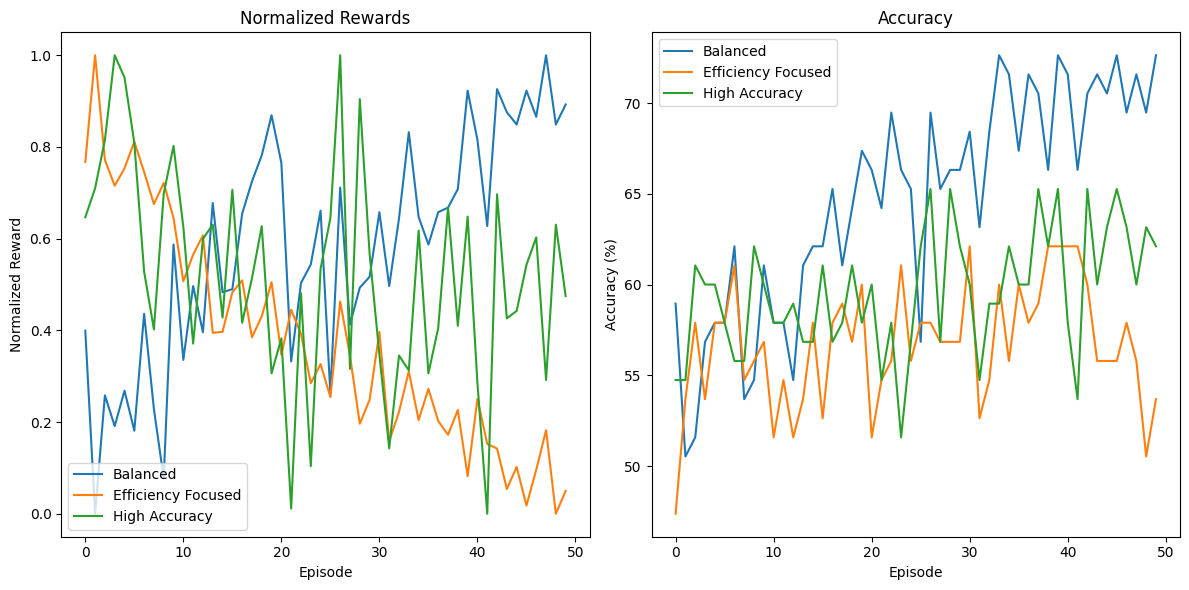

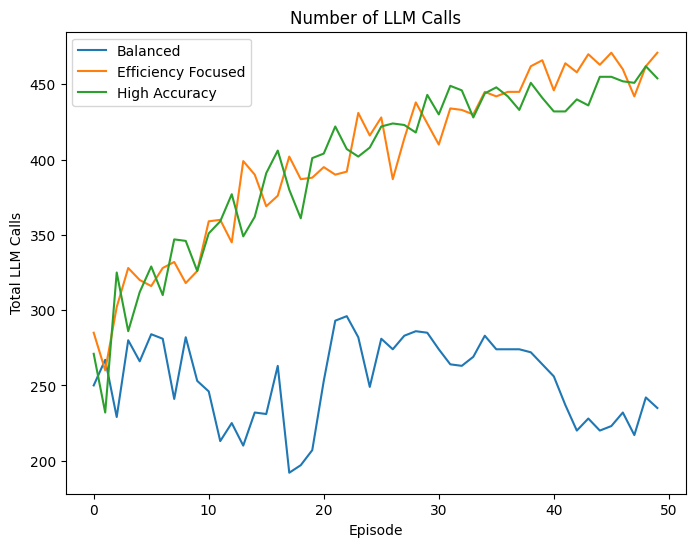

In [99]:
import matplotlib.pyplot as plt

# Get rewards, accuracy and number of LLM calls for each configuration
balanced_rewards = accuracy_rewards_numcalls["Balanced"]["rewards"]
balanced_accuracy = accuracy_rewards_numcalls["Balanced"]["accuracy"]
balanced_num_calls = accuracy_rewards_numcalls["Balanced"]["num_calls"]

efficiency_rewards = accuracy_rewards_numcalls["Efficiency_Focused"]["rewards"]
efficiency_accuracy = accuracy_rewards_numcalls["Efficiency_Focused"]["accuracy"]
efficiency_num_calls = accuracy_rewards_numcalls["Efficiency_Focused"]["num_calls"]

high_accuracy_accuracy = accuracy_rewards_numcalls["High_Accuracy"]["accuracy"]
high_accuracy_rewards = accuracy_rewards_numcalls["High_Accuracy"]["rewards"]
high_accuracy_num_calls = accuracy_rewards_numcalls["High_Accuracy"]["num_calls"]

# min max scaling for rewards
balanced_rewards = (balanced_rewards - np.min(balanced_rewards)) / (np.max(balanced_rewards) - np.min(balanced_rewards))
efficiency_rewards = (efficiency_rewards - np.min(efficiency_rewards)) / (np.max(efficiency_rewards) - np.min(efficiency_rewards))
high_accuracy_rewards = (high_accuracy_rewards - np.min(high_accuracy_rewards)) / (np.max(high_accuracy_rewards) - np.min(high_accuracy_rewards))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(balanced_rewards, label="Balanced")
plt.plot(efficiency_rewards, label="Efficiency Focused")
plt.plot(high_accuracy_rewards, label="High Accuracy")
plt.title("Normalized Rewards")
plt.xlabel("Episode")
plt.ylabel("Normalized Reward")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(balanced_accuracy, label="Balanced")
plt.plot(efficiency_accuracy, label="Efficiency Focused")
plt.plot(high_accuracy_accuracy, label="High Accuracy")
plt.title("Accuracy")
plt.xlabel("Episode")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(balanced_num_calls, label="Balanced")
plt.plot(efficiency_num_calls, label="Efficiency Focused")
plt.plot(high_accuracy_num_calls, label="High Accuracy")
plt.title("Number of LLM Calls")
plt.xlabel("Episode")
plt.ylabel("Total LLM Calls")
plt.legend()
plt.show()

## Try it on test set data of hotpot qa 

In [ ]:
# Evaluate the agent on the test data
def evaluate_agent(agent, data):
    agent.q_network.eval()  # Set the model to evaluation mode
    correct_answers = 0
    total_parent_nodes = 0
    results = []

    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                state = get_state(node)
                action = agent.select_action(state, epsilon=0)
                print("action selected ", action)
                done_resampling = False

                # saving original node question because maybe after resampling the question is changed
                original_node_question = node["question_text"]
                if action == 3: # ResampleTreeDecompositionThenSolve
                    root_question = node["question_text"]
                    # print("example before resampling", example)
                    example = tree_resampling_pipeline.resample_tree(root_question)
                    # print("example after resampling", example)
                    # get the parent node again because maybe the tree is changed in term of the order
                    for node_ in example:
                        if "fa" not in node_:
                            node = node_
                            break
                    done_resampling = True
                    action = 2 # Set action now to Child to execute child aggregation
                chosen_answer = None
                fallback_used = False
                fallback_action = None

                # Simulate the action
                if action == 0:
                    node['cb_answer'] = get_cb_answer(node["question_text"].strip())
                    chosen_answer = node.get("cb_answer", [None])
                    # chosen_answer = node.get("cb_answer", [None])
                elif action == 1:
                    # since you are the parent, so topic entities are empty because no references
                    node['ob_answer'] = get_singlehop_ob_answer(node["question_text"].strip(), [])
                    chosen_answer = node.get("ob_answer", [None])
                elif action == 2:
                    # Call child aggregation function
                    _, chosen_answer = child_aggregation(example)
                    
                if done_resampling:
                    # if the original action was resampling, then reset the action to 3
                    # print("original action was resampling, so set action to 3")
                    action = 3 
                
                # Get Q-values for the current state deep copy
                q_values = agent.q_network(state).clone()
                while (chosen_answer is None or "unknown" in chosen_answer[0].lower().strip()):
                    fallback_used = True    

                    # Mask the Q-value of the originally chosen action
                    q_values[action] = -float('inf')  # Ignore the originally chosen action

                    # if all q_values are -inf, then break
                    if torch.all(q_values == -float('inf')):
                        print("All actions are invalid, skipping fallback")
                        break

                    # Mask invalid actions if applicable
                    # For example, if state[150] == 0 (has_children == 0), disable actions 2 (Child) and 3 (Resample)
                    if state[150] == 0:
                        q_values[2] = -float('inf')  # Child aggregation
                        q_values[3] = -float('inf')  # ResampleTreeDecomposition

                    # Select the next best action
                    fallback_action = torch.argmax(q_values).item()
                    
                    # set q_values of the fallback action to -inf in order to not select it again
                    q_values[fallback_action] = -float('inf')  # Ignore the originally chosen action

                    # Execute the fallback action
                    if fallback_action == 0:  # CB
                        chosen_answer = get_cb_answer(node["question_text"].strip())
                    elif fallback_action == 1:  # OB
                        chosen_answer = get_singlehop_ob_answer(node["question_text"].strip(), [])
                    elif fallback_action == 2:  # Child
                        # Call your tree decomposition/resampling logic if required
                        _, chosen_answer = child_aggregation(example)
                    elif fallback_action == 3:  # Resample
                        # Call your tree resampling logic if required
                        example = tree_resampling_pipeline.resample_tree(node["question_text"].strip())
                        _, chosen_answer = child_aggregation(example)
                    
                    print("Fallback used, ", "original action:", action , "fallback action:", fallback_action, "chosen answer:", chosen_answer)


                # Compute reward
                gold_answer, _ = q2gold[original_node_question]

                # if normalize_answer(chosen_answer[0]) == normalize_answer(gold_answer):
                if chosen_answer and are_answers_equivalent_using_llm(gold_answer, chosen_answer[0]):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": original_node_question,
                    "answer": chosen_answer[0],
                    "gold": gold_answer,
                    "tree-decomposition": example,
                    "method": action_space[action] if not fallback_used else action_space[fallback_action]
                })

    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    return results, correct_answers, total_parent_nodes

import json
import torch

# Load test data
with open('results-testset-hotpotqa.json', 'r') as file:
    test_data = json.load(file)

# Load ground truth answers
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        print("ERROR CASE", e)

# List of trained models to evaluate
configurations = [
    {"alpha": 2.0, "beta": 0.05, "name": "High_Accuracy"},
    {"alpha": 1.0, "beta": 0.1, "name": "Balanced"},
    {"alpha": 0.5, "beta": 0.2, "name": "Efficiency_Focused"},
]

predictions_per_config = {}
correct_answers_per_config = {}
total_parent_nodes_per_config = {}
accuracy_per_config = {}

# Evaluate each model
for config in configurations:
    config_name = config["name"]
    agent_model_path = f"saved_models_with_resampling/agent_{config_name}.pth"
    best_model_path = f"saved_models_with_resampling/best_agent_{config_name}.pth"

    # Load the trained model agent and best agent
    agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)
    agent.q_network.load_state_dict(torch.load(agent_model_path))
    agent.q_network.eval()  # Set model to evaluation mode

    best_agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)
    best_agent.q_network.load_state_dict(torch.load(best_model_path))
    best_agent.q_network.eval()  # Set model to evaluation mode

    print(f"\nEvaluating model: {config_name}")
    
    # Run evaluation
    rl_predictions, correct_answers, total_parent_nodes = evaluate_agent(best_agent, test_data)
    predictions_per_config[config_name] = rl_predictions
    correct_answers_per_config[config_name] = correct_answers
    total_parent_nodes_per_config[config_name] = total_parent_nodes

    # Print final accuracy
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    accuracy_per_config[config_name] = accuracy
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%\n")



Evaluating model: High_Accuracy
action selected  3
action selected  3
Fallback used,  original action: 3 fallback action: 2 chosen answer: ('Unknown', -25.036596985448803, 'Murray Head is most recognized for the 1970 international hit song, but the provided context does not clearly state the song he is most recognized for, it only mentions "Superstar" from the rock opera "Jesus Christ Superstar" and another option "One Night in Bangkok". However, it is known that "One Night in Bangkok" is a song from the concept album and musical "Chess", which was written by Benny Andersson and Björn Ulvaeus, and "Superstar" was written by Andrew Lloyd Webber and Tim Rice. So the answer is: Unknown', [-0.084472656, -2.3841858e-07, 0, -5.8174133e-05, -0.69140625, 0, 0, -2.8848648e-05, -0.38671875, 0, 0, -2.2649765e-06, 0, -3.528595e-05, -0.00075912476, -0.123046875, -0.015136719, -0.4375, -2.4437904e-05, -0.36132812, -2.5391579e-05, -0.08300781, -0.0115356445, -0.4921875, -0.65625, -0.68359375, 0, -7.

In [101]:
# dict of config and each value is dict of method and count
methods_count_per_config = {}

# Print the results of the agent for each configuration
for config_name, rl_predictions in predictions_per_config.items():
    print(f"Results for {config_name}:")
    for result in rl_predictions:
        print(f"Node {result['idx']}:")
        print(f"  Question: {result['question']}")
        print(f"  Answer: {result['answer']}")
        print(f"  Gold Answer: {result['gold']}")
        print(f"  Method: {result['method']}")
        method = result['method']
        if config_name not in methods_count_per_config:
            methods_count_per_config[config_name] = {}
        if method not in methods_count_per_config[config_name]:
            methods_count_per_config[config_name][method] = 0
        methods_count_per_config[config_name][method] += 1
        print()


# Print the count of methods used by the agent for each configuration
for config_name, method_counts in methods_count_per_config.items():
    print(f"Method Counts for {config_name}:")
    for method, count in method_counts.items():
        print(f"  {method}: {count}")
    print()

Results for High_Accuracy:
Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: American.
  Gold Answer: American
  Method: ResampleTreeDecompositionThenSolve

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: Andrew Lloyd Webber and Tim Rice.
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: CB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: ResampleTreeDecompositionThenSolve

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: South Korea.
  Gold Answer: South Korea
  Method: CB

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
 

In [102]:
# Print the final accuracy for each configuration
for config_name, accuracy in accuracy_per_config.items():
    print(f"Final Accuracy for {config_name}: {accuracy:.2f}%")
    print(f"Total parent nodes: {total_parent_nodes_per_config[config_name]}")
    print(f"Times answer matches gold answer: {correct_answers_per_config[config_name]}")
    print()

Final Accuracy for High_Accuracy: 63.00%
Total parent nodes: 100
Times answer matches gold answer: 63

Final Accuracy for Balanced: 65.00%
Total parent nodes: 100
Times answer matches gold answer: 65

Final Accuracy for Efficiency_Focused: 72.00%
Total parent nodes: 100
Times answer matches gold answer: 72



In [103]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            # if normalize_answer(answer) == normalize_answer(final_answer):
            if are_answers_equivalent_using_llm(final_answer, answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable films include a 

In [104]:
# compare between rl_predictions and probtree for each configuration
for config in configurations:
    config_name = config["name"]
    count = 0
    print(f"\nComparing results for {config_name} with the Probtree results:")
    for rl_pred, prob_tree_result in zip(predictions_per_config[config_name], results):
        if rl_pred['method'] == prob_tree_result['method'] or are_answers_equivalent_using_llm(rl_pred['answer'], prob_tree_result['answer']):
            continue
        count += 1
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
        print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
    print()
    print(f"Total mismatches: {count}")
    print("------------------------------------------------------------")



Comparing results for High_Accuracy with the Probtree results:
Question: Where was Nexon who was composed by Adam Gubman located at?
Gold Answer: South Korea
RL Prediction: South Korea., ProbTree Result: Tokyo, Japan.
RL Method: CB, ProbTree Method: Child
Question: Chun Woo-hee's notable films include a South Korean horror film about  a policeman who investigates a series of mysterious killings and what?
Gold Answer: illnesses
RL Prediction: illnesses., ProbTree Result: The Wailing.
RL Method: OB, ProbTree Method: CB
Question: What team had Tony Roberts replaced by an American sportscaster from Buffalo, New York when he retired?
Gold Answer: Notre Dame Fighting Irish football
RL Prediction: Carolina Panthers., ProbTree Result: Notre Dame.
RL Method: ResampleTreeDecompositionThenSolve, ProbTree Method: Child
Question: Which star in the Maltese Bippy died in 1987?
Gold Answer: Dan Rowan
RL Prediction: Dan Rowan., ProbTree Result: None.
RL Method: ResampleTreeDecompositionThenSolve, Prob

In [105]:
# Error analysis for each configuration
for config in configurations:
    config_name = config["name"]
    count = 0
    print(f"\nError analysis for {config_name}:")
    for rl_pred in predictions_per_config[config_name]:
        if are_answers_equivalent_using_llm(rl_pred['answer'], rl_pred['gold']):
            continue
        count += 1
        print(f"Question: {rl_pred['question']}")
        print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
        print(f"RL Prediction: {rl_pred['answer']}")
        print(f"RL Method: {rl_pred['method']}")
        print(f"Tree Decomposition: {rl_pred['tree-decomposition']}")
        print()
    print()
    print(f"Total Error cases: {count}")
    print("------------------------------------------------------------")



Error analysis for High_Accuracy:
Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
Gold Answer: Wembley Stadium
RL Prediction: Old Trafford.
RL Method: ResampleTreeDecompositionThenSolve
Tree Decomposition: [{'idx': 0, 'question_text': 'Which match had Chicharito, Antonio Valencia and Dimitar Berbatov scoring goals?', 'sons': [], 'qd_logprob': None, 'fa': 2}, {'idx': 1, 'question_text': 'Where was <1> held?', 'sons': [], 'qd_logprob': None, 'fa': 2}, {'idx': 2, 'question_text': 'Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?', 'sons': [0, 1], 'qd_logprob': -0.0107240759387931}]

Question: What team had Tony Roberts replaced by an American sportscaster from Buffalo, New York when he retired?
Gold Answer: Notre Dame Fighting Irish football
RL Prediction: Carolina Panthers.
RL Method: ResampleTreeDecompositionThenSolve
Tree Decomposition: [{'idx': 0, 'question_text'